# Necessary Modules

In [1]:
import numpy as np
import random
# for inline plots in jupyter
%matplotlib inline
# import matplotlib
import matplotlib.pyplot as plt
# for latex equations
from IPython.display import Math, Latex
# for displaying images
from IPython.core.display import Image
# import seaborn
import seaborn as sns
# settings for seaborn plotting style
sns.set(color_codes=True)
# settings for seaborn plot sizes
sns.set(rc={'figure.figsize':(5,5)})
# makeing Dataframe
import pandas as pd
# for showing progress
from tqdm import tqdm
# euclidean distance
from scipy.spatial import distance

In [2]:
import sys
!{sys.executable} -m pip install -r requirements.txt

     |████████████████████████████████| 67 kB 97 kB/s eta 0:00:0111


### Question 1
Let's see how does our model behave, let's first discuss our events:
1. Someone gets infected.
2. Someone dies.
3. Someone recovers.
4. A recovered person goes through contagtious time.

So, now we will see what happens in each situation:

1. $n_h-=1$,     $n_r$,    $n_u$,       $n_s+=1$,        $n_d$
2. $n_h$,        $n_r$,    $n_u$,       $n_s-=1$,        $n_d+=1$
3. $n_h$,        $n_r+=1$,    $n_u+=1$,        $n_s-=1$,      $n_d$
4. $n_h+=1$ or $n_h$,     $n_r$,     $n_u-=1$,      $n_s$, $n_d$

and there is also the question that do we need to specify our people in the model, which the answer is no, only knowing the numbers are enough.

since all generations are exponential then we can deduse that with probability of $\frac{n_h \mu}{n_h\mu + p_rn_s\mu+p_dn_s\mu+ln(t_u)}$

In [258]:
class SimpleVirus:
    def log(self):        
        df = pd.DataFrame(self.log_data, columns=self.keys)
#         df = df.set_index(['time'])
        return df
    
    def save_episode(self, event):
        self.log_data.append([self.time, event, self.number_healthy, self.number_recovered,
                                    self.number_sick, self.number_dead, self.nu, self.next_infected, 
                                    self.next_recover, self.next_contagious])
    
    def save_dataframe(self,df):
        df.to_csv('BasicSpreadlog.txt', index=False, sep='\t')
        
    def __init__(self, n=10**6, nh=10**6-1, nr=0, nu=0, ns=1, nd=0, pr=0.9, ar=0, mu=2000, br=30, tu=14,
                 healthy_flag=False, update_policy=0):
        
        self.number_healthy=nh   # number of healthy
        self.number_recovered=nr   # number of recavered
        self.nu=nu   # number of u
        self.number_sick=ns   # number of sick
        self.number_dead=nd   # number of dead
        self.number_people=n     # number of people
        self.probability_recover=pr   # probability of recovering
        self.probability_dead=1-pr # probability of death
        
        self.start_interval=ar # a_r
        self.end_interval=br #b_r
        
        self.mu=mu  # mu of infection rate
        self.tu=tu  # time of u
        self.update_policy=update_policy
        
        self.time=0 # time in simulation
        self.next_infected=self.generate_infected() # next infection event
        self.recovery_times=[]
        
        for i in range(self.number_sick):
            self.recovery_times.append(self.recover_time())
            
        self.next_recover=min(self.recovery_times) if self.recovery_times!=[] else float('inf') # next recovery event
        
        self.u_times=[]
        for i in range(self.nu):
            self.u_times.append(np.random.uniform(low=0, high=self.tu))
        
        self.next_contagious=min(self.u_times) if self.u_times!=[] else float('inf') # next contagious time over event
        
        self.healthy_flag=healthy_flag # count recovered for getting the virus again
        
        # Initiate log
        self.keys=['time','event', 'healthy', 'recovered', 'sick', 'dead', 'convalescence', 
          'next infected', 'next recover', 'next contagious']
        self.log_data=[]
        self.save_episode('initaite')
        
    
    def updated_mu(self):
        if self.update_policy == 0:
            return self.mu
        
        elif self.update_policy == 1:
            return self.number_sick * self.mu
        
        else:
            return (self.number_sick + self.nu) * self.mu
        
        
    def infected_time(self):
        return np.random.exponential(1/self.updated_mu())

    def recover_time(self):
        return np.random.uniform(low=self.start_interval, high=self.end_interval)

    def contagtious_time(self):
        return self.tu
        
    def survived(self):
        condition=random.random()
        if condition<=self.probability_recover: return True
        else: return False
    
    def generate_infected(self):
        return self.time + self.infected_time()
    
    def generate_recover(self):
        return self.time + self.recover_time()
    
    def generate_contagtious(self):
        return self.time + self.contagtious_time()
    
    def infect(self):
        self.time=self.next_infected
        self.number_healthy-=1
        self.number_sick=self.number_sick+1
        self.recovery_times.append(self.generate_recover())
        self.next_recover=min(self.recovery_times)
        if self.number_healthy==0: 
            self.next_infected=float('inf')
        else:
            self.next_infected=self.generate_infected()
    
    def recover(self):
        self.time=self.next_recover
        self.recovery_times.remove(self.next_recover)
        self.number_sick-=1
        if self.survived():
            self.number_recovered+=1
            self.nu+=1
            self.u_times.append(self.generate_contagtious())
            self.next_contagious=min(self.u_times)
        else:
            self.number_dead+=1

        if self.number_sick==0:
            self.next_recover=float("inf")
        else:
            self.next_recover=min(self.recovery_times)
        
    def conatagious(self):
        self.time=self.next_contagious
        self.nu-=1
        self.u_times.remove(self.next_contagious)
        self.number_healthy=self.number_healthy+1 if self.healthy_flag else self.number_healthy
        
        if self.nu==0:
            self.next_contagious=float('inf')
        else:
            self.next_contagious=min(self.u_times)
    
    def run(self):
        event=min(self.next_contagious, self.next_infected, self.next_recover)
        if event==self.next_infected:
            self.infect()
            event_name='infection'
        elif event==self.next_recover:
            self.recover()
            event_name='recovery'
        else:
            self.conatagious()
            event_name='convalescence'
        
        self.save_episode(event_name)
    
    def simulate(self,TIME):
        while self.time <=TIME or self.number_healthy==0 or self.number_sick==0:
            self.run()
            
    def plot_simulation(self, TIME, SAVE=False):
        for i in tqdm(range(TIME)):
            self.simulate(i)
        df=self.log()
        
        if SAVE: self.save_dataframe(df)
    
        fig, ax =plt.subplots(1,2, figsize=(10,5))
        for i in ["recovered", "sick", "dead"]:
            sns.lineplot(x="time", y=i, data=df, markers=True, legend='brief', label=i, ax=ax[0])


        ax[0].set(xlabel='Time')
        ax[0].set(ylabel='# People')
        
        sns.lineplot(x="time", y="healthy", data=df, markers=True, legend='brief', label="healthy",ax=ax[1])
        
        plt.title('Simple Simulation')
        plt.show()

In [259]:
test=SimpleVirus()

In [260]:
test.run()
test.log().set_index(['time'])

,event,healthy,recovered,sick,dead,convalescence,next infected,next recover,next contagious
time,,,,,,,,,
0.000000,initaite,1000000,0,1,0,0,0.000521,28.619988,inf
0.000521,infection,999999,0,2,0,0,0.000726,15.112064,inf


## A)

100%|██████████| 244/244 [12:32<00:00,  3.08s/it]


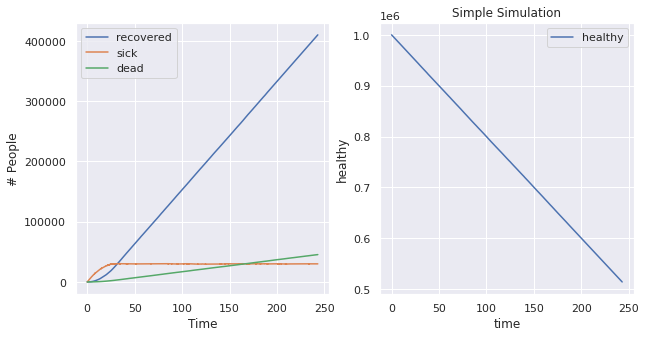

In [261]:
test.plot_simulation(244, SAVE=False)

In [262]:
test.updated_mu()

2000

In [263]:
test.number_dead

45404

In [264]:
test.number_healthy

514351

## B)

In [265]:
test2=SimpleVirus(healthy_flag=True)

100%|██████████| 200/200 [10:29<00:00,  3.15s/it]


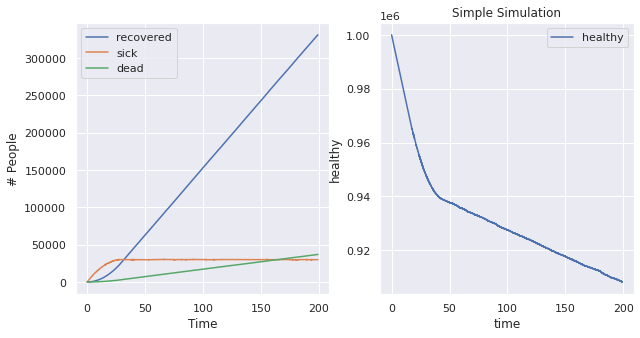

In [266]:
test2.plot_simulation(200, SAVE=False)

# Question 2

# A)

In [312]:
test3=SimpleVirus(healthy_flag=True, mu=1 ,update_policy=1)

100%|██████████| 10/10 [00:00<00:00, 51.66it/s]


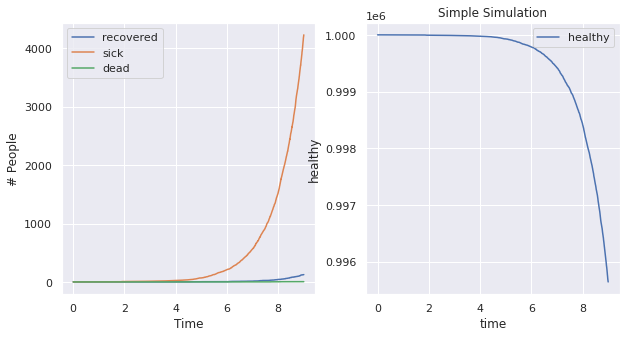

In [313]:
test3.plot_simulation(10, SAVE=False)

In [314]:
test3.number_healthy

995642

In [315]:
test3.number_dead

5

In [316]:
test3.number_recovered

126

In [324]:
test3.number_sick

4228

# B)

In [326]:
test4=SimpleVirus(healthy_flag=True, mu=1 ,update_policy=2)

100%|██████████| 10/10 [00:02<00:00,  4.79it/s]


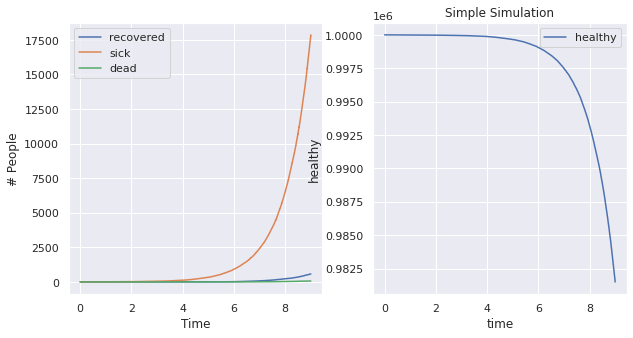

In [327]:
test4.plot_simulation(10, SAVE=False)

In [328]:
test4.number_healthy

981493

In [329]:
test4.number_dead

67

In [330]:
test4.number_recovered

575

In [331]:
test4.number_sick

17866

# Question 3

From what I gathered, We will make a $l\times l$ grid (city) and distribute our people in each district. Then we will make a function named *Distance* and we will be the distance of two district. Here we don't really need to think of each person as an individual but only know that the person is from which district. So each district has $n_s, n_h, n_d,$ etc. So each District acts like a small independent experiment, with the assumption of that no two people would get infected at the same time we can then make a ComplexVirus class that control Districts. We also put a condition that each district has at least $\frac{n}{4l^2}$  of population.

Now, Let's make another assumption the number of people getting infected or recover in a day doesn't affect the development of the disease that day.

<div id="introduction" class="section level2">
<h2>Introduction</h2>
<p>Compartmental models are of great utility in many disciplines and very much so in epidemiology. Let us derive deterministic and stochastic versions of the susceptible-infected-recovered (SIR) model of disease transmission dynamics in a closed population. In so doing, we will use notation that generalizes to more complex systems <a href="http://dx.doi.org/10.1214/08-AOAS201"><span class="citation">(Bretó et al. 2009)</span></a>.</p>
<div class="figure" style="text-align: center">
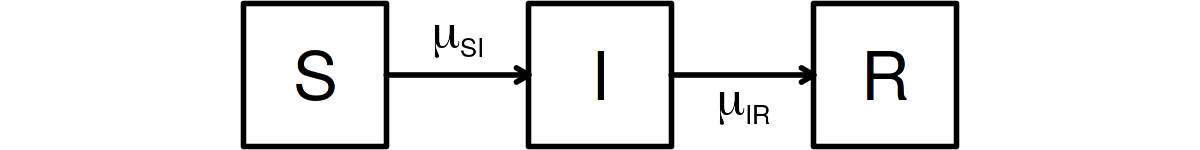
<p class="caption">
Diagram of the SIR compartmental model.
</p>
</div>
<ul>
<li>Let <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-1-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>S</mi></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1" style="width: 0.836em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.658em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.313em, 1000.66em, 2.384em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-2"><span class="mi" id="MathJax-Span-3" style="font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.068em; border-left: 0px solid; width: 0px; height: 1.004em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>S</mi></math></span></span><script type="math/tex" id="MathJax-Element-1">S</script></span>, <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-2-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>I</mi></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-4" style="width: 0.598em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.479em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.372em, 1000.48em, 2.384em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-5"><span class="mi" id="MathJax-Span-6" style="font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.068em; border-left: 0px solid; width: 0px; height: 0.932em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>I</mi></math></span></span><script type="math/tex" id="MathJax-Element-2">I</script></span>, and <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-3-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>R</mi></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-7" style="width: 0.955em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.777em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.372em, 1000.78em, 2.384em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-8"><span class="mi" id="MathJax-Span-9" style="font-family: MathJax_Math-italic;">R</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.068em; border-left: 0px solid; width: 0px; height: 1.004em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>R</mi></math></span></span><script type="math/tex" id="MathJax-Element-3">R</script></span> represent, respectively, the number of susceptible hosts, the number of infected (and, by assumption, infectious) hosts, and the number of recovered or removed hosts.</li>
<li>We suppose that each arrow has an associated <em>per capita</em> rate, so here there is a rate <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-4-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><msub><mi>&amp;#x03BC;</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>S</mi><mi>I</mi></mrow></msub></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-10" style="width: 1.789em; display: inline-block;"><span style="display: inline-block; position: relative; width: 1.491em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.61em, 1001.49em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-11"><span class="msubsup" id="MathJax-Span-12"><span style="display: inline-block; position: relative; width: 1.491em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.6em, 4.408em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-13" style="font-family: MathJax_Math-italic;">μ</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.598em;"><span class="texatom" id="MathJax-Span-14"><span class="mrow" id="MathJax-Span-15"><span class="mi" id="MathJax-Span-16" style="font-size: 70.7%; font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-17" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 0.932em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><msub><mi>μ</mi><mrow class="MJX-TeXAtom-ORD"><mi>S</mi><mi>I</mi></mrow></msub></math></span></span><script type="math/tex" id="MathJax-Element-4">\mu_{SI}</script></span> at which individuals in <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-5-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>S</mi></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-18" style="width: 0.836em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.658em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.313em, 1000.66em, 2.384em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-19"><span class="mi" id="MathJax-Span-20" style="font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.068em; border-left: 0px solid; width: 0px; height: 1.004em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>S</mi></math></span></span><script type="math/tex" id="MathJax-Element-5">S</script></span> transition to <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-6-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>I</mi></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-21" style="width: 0.598em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.479em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.372em, 1000.48em, 2.384em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-22"><span class="mi" id="MathJax-Span-23" style="font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.068em; border-left: 0px solid; width: 0px; height: 0.932em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>I</mi></math></span></span><script type="math/tex" id="MathJax-Element-6">I</script></span>, and <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-7-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><msub><mi>&amp;#x03BC;</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>I</mi><mi>R</mi></mrow></msub></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-24" style="width: 1.908em; display: inline-block;"><span style="display: inline-block; position: relative; width: 1.551em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.61em, 1001.55em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-25"><span class="msubsup" id="MathJax-Span-26"><span style="display: inline-block; position: relative; width: 1.551em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.6em, 4.408em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-27" style="font-family: MathJax_Math-italic;">μ</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.598em;"><span class="texatom" id="MathJax-Span-28"><span class="mrow" id="MathJax-Span-29"><span class="mi" id="MathJax-Span-30" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="mi" id="MathJax-Span-31" style="font-size: 70.7%; font-family: MathJax_Math-italic;">R</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 0.932em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><msub><mi>μ</mi><mrow class="MJX-TeXAtom-ORD"><mi>I</mi><mi>R</mi></mrow></msub></math></span></span><script type="math/tex" id="MathJax-Element-7">\mu_{IR}</script></span> at which individuals in <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-8-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>I</mi></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-32" style="width: 0.598em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.479em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.372em, 1000.48em, 2.384em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-33"><span class="mi" id="MathJax-Span-34" style="font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.068em; border-left: 0px solid; width: 0px; height: 0.932em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>I</mi></math></span></span><script type="math/tex" id="MathJax-Element-8">I</script></span> transition to <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-9-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>R</mi></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-35" style="width: 0.955em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.777em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.372em, 1000.78em, 2.384em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-36"><span class="mi" id="MathJax-Span-37" style="font-family: MathJax_Math-italic;">R</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.068em; border-left: 0px solid; width: 0px; height: 1.004em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>R</mi></math></span></span><script type="math/tex" id="MathJax-Element-9">R</script></span>.</li>
<li>To account for demography (birth/death/migration) we allow the possibility of a source and sink compartment, which is not represented on the flow diagram above.
<ul>
<li>We write <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-10-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><msub><mi>&amp;#x03BC;</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mstyle mathsize=&quot;0.85em&quot;><mo>&amp;#x2219;</mo></mstyle></mrow><mi>S</mi></mrow></msub></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-38" style="width: 1.729em; display: inline-block;"><span style="display: inline-block; position: relative; width: 1.432em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.61em, 1001.43em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-39"><span class="msubsup" id="MathJax-Span-40"><span style="display: inline-block; position: relative; width: 1.432em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.6em, 4.408em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-41" style="font-family: MathJax_Math-italic;">μ</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.598em;"><span class="texatom" id="MathJax-Span-42"><span class="mrow" id="MathJax-Span-43"><span class="texatom" id="MathJax-Span-44"><span class="mrow" id="MathJax-Span-45"><span class="mstyle" id="MathJax-Span-46"><span class="mrow" id="MathJax-Span-47"><span class="mo" id="MathJax-Span-48" style="font-size: 60.1%; font-family: MathJax_Main;">∙</span></span></span></span></span><span class="mi" id="MathJax-Span-49" style="font-size: 70.7%; font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 0.932em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><msub><mi>μ</mi><mrow class="MJX-TeXAtom-ORD"><mrow class="MJX-TeXAtom-ORD"><mstyle mathsize="0.85em"><mo>∙</mo></mstyle></mrow><mi>S</mi></mrow></msub></math></span></span><script type="math/tex" id="MathJax-Element-10">\mu_{{\small\bullet} S}</script></span> for a rate of births into <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-11-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>S</mi></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-50" style="width: 0.836em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.658em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.313em, 1000.66em, 2.384em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-51"><span class="mi" id="MathJax-Span-52" style="font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.068em; border-left: 0px solid; width: 0px; height: 1.004em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>S</mi></math></span></span><script type="math/tex" id="MathJax-Element-11">S</script></span>.</li>
<li>Mortality rates are denoted by <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-12-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><msub><mi>&amp;#x03BC;</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>S</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mstyle mathsize=&quot;0.85em&quot;><mo>&amp;#x2219;</mo></mstyle></mrow></mrow></msub></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-53" style="width: 1.729em; display: inline-block;"><span style="display: inline-block; position: relative; width: 1.432em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.61em, 1001.43em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-54"><span class="msubsup" id="MathJax-Span-55"><span style="display: inline-block; position: relative; width: 1.432em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.6em, 4.408em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-56" style="font-family: MathJax_Math-italic;">μ</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.598em;"><span class="texatom" id="MathJax-Span-57"><span class="mrow" id="MathJax-Span-58"><span class="mi" id="MathJax-Span-59" style="font-size: 70.7%; font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="texatom" id="MathJax-Span-60"><span class="mrow" id="MathJax-Span-61"><span class="mstyle" id="MathJax-Span-62"><span class="mrow" id="MathJax-Span-63"><span class="mo" id="MathJax-Span-64" style="font-size: 60.1%; font-family: MathJax_Main;">∙</span></span></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 0.932em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><msub><mi>μ</mi><mrow class="MJX-TeXAtom-ORD"><mi>S</mi><mrow class="MJX-TeXAtom-ORD"><mstyle mathsize="0.85em"><mo>∙</mo></mstyle></mrow></mrow></msub></math></span></span><script type="math/tex" id="MathJax-Element-12">\mu_{S{\small\bullet}}</script></span>, <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-13-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><msub><mi>&amp;#x03BC;</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>I</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mstyle mathsize=&quot;0.85em&quot;><mo>&amp;#x2219;</mo></mstyle></mrow></mrow></msub></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-65" style="width: 1.61em; display: inline-block;"><span style="display: inline-block; position: relative; width: 1.313em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.61em, 1001.31em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-66"><span class="msubsup" id="MathJax-Span-67"><span style="display: inline-block; position: relative; width: 1.313em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.6em, 4.408em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-68" style="font-family: MathJax_Math-italic;">μ</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.598em;"><span class="texatom" id="MathJax-Span-69"><span class="mrow" id="MathJax-Span-70"><span class="mi" id="MathJax-Span-71" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="texatom" id="MathJax-Span-72"><span class="mrow" id="MathJax-Span-73"><span class="mstyle" id="MathJax-Span-74"><span class="mrow" id="MathJax-Span-75"><span class="mo" id="MathJax-Span-76" style="font-size: 60.1%; font-family: MathJax_Main;">∙</span></span></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 0.932em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><msub><mi>μ</mi><mrow class="MJX-TeXAtom-ORD"><mi>I</mi><mrow class="MJX-TeXAtom-ORD"><mstyle mathsize="0.85em"><mo>∙</mo></mstyle></mrow></mrow></msub></math></span></span><script type="math/tex" id="MathJax-Element-13">\mu_{I{\small\bullet}}</script></span>, <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-14-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><msub><mi>&amp;#x03BC;</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>R</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mstyle mathsize=&quot;0.85em&quot;><mo>&amp;#x2219;</mo></mstyle></mrow></mrow></msub></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-77" style="width: 1.789em; display: inline-block;"><span style="display: inline-block; position: relative; width: 1.491em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.61em, 1001.49em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-78"><span class="msubsup" id="MathJax-Span-79"><span style="display: inline-block; position: relative; width: 1.491em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.6em, 4.408em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-80" style="font-family: MathJax_Math-italic;">μ</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.598em;"><span class="texatom" id="MathJax-Span-81"><span class="mrow" id="MathJax-Span-82"><span class="mi" id="MathJax-Span-83" style="font-size: 70.7%; font-family: MathJax_Math-italic;">R</span><span class="texatom" id="MathJax-Span-84"><span class="mrow" id="MathJax-Span-85"><span class="mstyle" id="MathJax-Span-86"><span class="mrow" id="MathJax-Span-87"><span class="mo" id="MathJax-Span-88" style="font-size: 60.1%; font-family: MathJax_Main;">∙</span></span></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 0.932em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><msub><mi>μ</mi><mrow class="MJX-TeXAtom-ORD"><mi>R</mi><mrow class="MJX-TeXAtom-ORD"><mstyle mathsize="0.85em"><mo>∙</mo></mstyle></mrow></mrow></msub></math></span></span><script type="math/tex" id="MathJax-Element-14">\mu_{R{\small\bullet}}</script></span>.</li>
</ul></li>
<li>The rates may be either constant or varying. In particular, for a simple SIR model, the recovery rate <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-15-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><msub><mi>&amp;#x03BC;</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>I</mi><mi>R</mi></mrow></msub></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-89" style="width: 1.908em; display: inline-block;"><span style="display: inline-block; position: relative; width: 1.551em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.61em, 1001.55em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-90"><span class="msubsup" id="MathJax-Span-91"><span style="display: inline-block; position: relative; width: 1.551em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.6em, 4.408em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-92" style="font-family: MathJax_Math-italic;">μ</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.598em;"><span class="texatom" id="MathJax-Span-93"><span class="mrow" id="MathJax-Span-94"><span class="mi" id="MathJax-Span-95" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="mi" id="MathJax-Span-96" style="font-size: 70.7%; font-family: MathJax_Math-italic;">R</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 0.932em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><msub><mi>μ</mi><mrow class="MJX-TeXAtom-ORD"><mi>I</mi><mi>R</mi></mrow></msub></math></span></span><script type="math/tex" id="MathJax-Element-15">\mu_{IR}</script></span> is a constant but the infection rate has the time-varying form <span class="math display"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><div class="MathJax_Display" style="text-align: center;"><span class="MathJax" id="MathJax-Element-16-Frame" tabindex="0" style="text-align: center; position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot; display=&quot;block&quot;><msub><mi>&amp;#x03BC;</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo><mo>=</mo><mi>&amp;#x03B2;</mi><mspace width=&quot;thinmathspace&quot; /><mfrac><mrow><mi>I</mi><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></mrow><mrow><mi>N</mi><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></mrow></mfrac><mo>,</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-97" style="width: 8.932em; display: inline-block;"><span style="display: inline-block; position: relative; width: 7.443em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(0.539em, 1007.38em, 3.396em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-98"><span class="msubsup" id="MathJax-Span-99"><span style="display: inline-block; position: relative; width: 1.491em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.6em, 4.408em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-100" style="font-family: MathJax_Math-italic;">μ</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.598em;"><span class="texatom" id="MathJax-Span-101"><span class="mrow" id="MathJax-Span-102"><span class="mi" id="MathJax-Span-103" style="font-size: 70.7%; font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-104" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-105" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-106" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-107" style="font-family: MathJax_Main;">)</span><span class="mo" id="MathJax-Span-108" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="mi" id="MathJax-Span-109" style="font-family: MathJax_Math-italic; padding-left: 0.301em;">β<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mspace" id="MathJax-Span-110" style="height: 0em; vertical-align: 0em; width: 0.182em; display: inline-block; overflow: hidden;"></span><span class="mfrac" id="MathJax-Span-111"><span style="display: inline-block; position: relative; width: 2.146em; height: 0px; margin-right: 0.122em; margin-left: 0.122em;"><span style="position: absolute; clip: rect(3.039em, 1001.55em, 4.408em, -999.997em); top: -4.699em; left: 50%; margin-left: -0.83em;"><span class="mrow" id="MathJax-Span-112"><span class="mi" id="MathJax-Span-113" style="font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="mo" id="MathJax-Span-114" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-115" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-116" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.039em, 1001.91em, 4.408em, -999.997em); top: -3.271em; left: 50%; margin-left: -1.009em;"><span class="mrow" id="MathJax-Span-117"><span class="mi" id="MathJax-Span-118" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="mo" id="MathJax-Span-119" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-120" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-121" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(0.836em, 1002.15em, 1.253em, -999.997em); top: -1.307em; left: 0em;"><span style="display: inline-block; overflow: hidden; vertical-align: 0em; border-top: 1.3px solid; width: 2.146em; height: 0px; --darkreader-inline-border-top: initial;" data-darkreader-inline-border-top=""></span><span style="display: inline-block; width: 0px; height: 1.074em;"></span></span></span></span><span class="mo" id="MathJax-Span-122" style="font-family: MathJax_Main;">,</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -1.282em; border-left: 0px solid; width: 0px; height: 3.146em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML MJX_Assistive_MathML_Block" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><msub><mi>μ</mi><mrow class="MJX-TeXAtom-ORD"><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo><mo>=</mo><mi>β</mi><mspace width="thinmathspace"></mspace><mfrac><mrow><mi>I</mi><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></mrow><mrow><mi>N</mi><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></mrow></mfrac><mo>,</mo></math></span></span></div><script type="math/tex; mode=display" id="MathJax-Element-16">\mu_{SI}(t)=\beta\,\frac{I(t)}{N(t)},</script></span> with <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-17-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>&amp;#x03B2;</mi></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-123" style="width: 0.717em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.598em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.313em, 1000.6em, 2.562em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-124"><span class="mi" id="MathJax-Span-125" style="font-family: MathJax_Math-italic;">β<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.282em; border-left: 0px solid; width: 0px; height: 1.218em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>β</mi></math></span></span><script type="math/tex" id="MathJax-Element-17">\beta</script></span> being the <em>contact rate</em> and <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-18-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>N</mi></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-126" style="width: 1.074em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.896em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.372em, 1000.9em, 2.384em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-127"><span class="mi" id="MathJax-Span-128" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.068em; border-left: 0px solid; width: 0px; height: 0.932em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>N</mi></math></span></span><script type="math/tex" id="MathJax-Element-18">N</script></span> the total size of the host population. In the present case, since the population is closed, we set <span class="math display"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><div class="MathJax_Display" style="text-align: center;"><span class="MathJax" id="MathJax-Element-19-Frame" tabindex="0" style="text-align: center; position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot; display=&quot;block&quot;><msub><mi>&amp;#x03BC;</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mstyle mathsize=&quot;0.85em&quot;><mo>&amp;#x2219;</mo></mstyle></mrow><mi>S</mi></mrow></msub><mo>=</mo><msub><mi>&amp;#x03BC;</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>S</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mstyle mathsize=&quot;0.85em&quot;><mo>&amp;#x2219;</mo></mstyle></mrow></mrow></msub><mo>=</mo><msub><mi>&amp;#x03BC;</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>I</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mstyle mathsize=&quot;0.85em&quot;><mo>&amp;#x2219;</mo></mstyle></mrow></mrow></msub><mo>=</mo><msub><mi>&amp;#x03BC;</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>R</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mstyle mathsize=&quot;0.85em&quot;><mo>&amp;#x2219;</mo></mstyle></mrow></mrow></msub><mo>=</mo><mn>0.</mn></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-129" style="width: 14.408em; display: inline-block;"><span style="display: inline-block; position: relative; width: 11.967em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.372em, 1011.91em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-130"><span class="msubsup" id="MathJax-Span-131"><span style="display: inline-block; position: relative; width: 1.432em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.6em, 4.408em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-132" style="font-family: MathJax_Math-italic;">μ</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.598em;"><span class="texatom" id="MathJax-Span-133"><span class="mrow" id="MathJax-Span-134"><span class="texatom" id="MathJax-Span-135"><span class="mrow" id="MathJax-Span-136"><span class="mstyle" id="MathJax-Span-137"><span class="mrow" id="MathJax-Span-138"><span class="mo" id="MathJax-Span-139" style="font-size: 60.1%; font-family: MathJax_Main;">∙</span></span></span></span></span><span class="mi" id="MathJax-Span-140" style="font-size: 70.7%; font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-141" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="msubsup" id="MathJax-Span-142" style="padding-left: 0.301em;"><span style="display: inline-block; position: relative; width: 1.432em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.6em, 4.408em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-143" style="font-family: MathJax_Math-italic;">μ</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.598em;"><span class="texatom" id="MathJax-Span-144"><span class="mrow" id="MathJax-Span-145"><span class="mi" id="MathJax-Span-146" style="font-size: 70.7%; font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="texatom" id="MathJax-Span-147"><span class="mrow" id="MathJax-Span-148"><span class="mstyle" id="MathJax-Span-149"><span class="mrow" id="MathJax-Span-150"><span class="mo" id="MathJax-Span-151" style="font-size: 60.1%; font-family: MathJax_Main;">∙</span></span></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-152" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="msubsup" id="MathJax-Span-153" style="padding-left: 0.301em;"><span style="display: inline-block; position: relative; width: 1.313em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.6em, 4.408em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-154" style="font-family: MathJax_Math-italic;">μ</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.598em;"><span class="texatom" id="MathJax-Span-155"><span class="mrow" id="MathJax-Span-156"><span class="mi" id="MathJax-Span-157" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="texatom" id="MathJax-Span-158"><span class="mrow" id="MathJax-Span-159"><span class="mstyle" id="MathJax-Span-160"><span class="mrow" id="MathJax-Span-161"><span class="mo" id="MathJax-Span-162" style="font-size: 60.1%; font-family: MathJax_Main;">∙</span></span></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-163" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="msubsup" id="MathJax-Span-164" style="padding-left: 0.301em;"><span style="display: inline-block; position: relative; width: 1.491em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.6em, 4.408em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-165" style="font-family: MathJax_Math-italic;">μ</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.598em;"><span class="texatom" id="MathJax-Span-166"><span class="mrow" id="MathJax-Span-167"><span class="mi" id="MathJax-Span-168" style="font-size: 70.7%; font-family: MathJax_Math-italic;">R</span><span class="texatom" id="MathJax-Span-169"><span class="mrow" id="MathJax-Span-170"><span class="mstyle" id="MathJax-Span-171"><span class="mrow" id="MathJax-Span-172"><span class="mo" id="MathJax-Span-173" style="font-size: 60.1%; font-family: MathJax_Main;">∙</span></span></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-174" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="mn" id="MathJax-Span-175" style="font-family: MathJax_Main; padding-left: 0.301em;">0.</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.218em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML MJX_Assistive_MathML_Block" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><msub><mi>μ</mi><mrow class="MJX-TeXAtom-ORD"><mrow class="MJX-TeXAtom-ORD"><mstyle mathsize="0.85em"><mo>∙</mo></mstyle></mrow><mi>S</mi></mrow></msub><mo>=</mo><msub><mi>μ</mi><mrow class="MJX-TeXAtom-ORD"><mi>S</mi><mrow class="MJX-TeXAtom-ORD"><mstyle mathsize="0.85em"><mo>∙</mo></mstyle></mrow></mrow></msub><mo>=</mo><msub><mi>μ</mi><mrow class="MJX-TeXAtom-ORD"><mi>I</mi><mrow class="MJX-TeXAtom-ORD"><mstyle mathsize="0.85em"><mo>∙</mo></mstyle></mrow></mrow></msub><mo>=</mo><msub><mi>μ</mi><mrow class="MJX-TeXAtom-ORD"><mi>R</mi><mrow class="MJX-TeXAtom-ORD"><mstyle mathsize="0.85em"><mo>∙</mo></mstyle></mrow></mrow></msub><mo>=</mo><mn>0.</mn></math></span></span></div><script type="math/tex; mode=display" id="MathJax-Element-19">\mu_{{\small\bullet} S}=\mu_{S{\small\bullet}}=\mu_{I{\small\bullet}}=\mu_{R{\small\bullet}}=0.</script></span></li>
<li>In general, it turns out to be convenient to keep track of the flows between compartments as well as the number of individuals in each compartment. Let <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-20-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><msub><mi>N</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-176" style="width: 3.396em; display: inline-block;"><span style="display: inline-block; position: relative; width: 2.801em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1002.68em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-177"><span class="msubsup" id="MathJax-Span-178"><span style="display: inline-block; position: relative; width: 1.67em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-179" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.777em;"><span class="texatom" id="MathJax-Span-180"><span class="mrow" id="MathJax-Span-181"><span class="mi" id="MathJax-Span-182" style="font-size: 70.7%; font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-183" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-184" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-185" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-186" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><msub><mi>N</mi><mrow class="MJX-TeXAtom-ORD"><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-20">N_{SI}(t)</script></span> count the number of individuals who have transitioned from <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-21-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>S</mi></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-187" style="width: 0.836em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.658em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.313em, 1000.66em, 2.384em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-188"><span class="mi" id="MathJax-Span-189" style="font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.068em; border-left: 0px solid; width: 0px; height: 1.004em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>S</mi></math></span></span><script type="math/tex" id="MathJax-Element-21">S</script></span> to <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-22-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>I</mi></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-190" style="width: 0.598em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.479em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.372em, 1000.48em, 2.384em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-191"><span class="mi" id="MathJax-Span-192" style="font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.068em; border-left: 0px solid; width: 0px; height: 0.932em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>I</mi></math></span></span><script type="math/tex" id="MathJax-Element-22">I</script></span> by time <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-23-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>t</mi></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-193" style="width: 0.479em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.36em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.372em, 1000.3em, 2.384em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-194"><span class="mi" id="MathJax-Span-195" style="font-family: MathJax_Math-italic;">t</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.068em; border-left: 0px solid; width: 0px; height: 0.932em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>t</mi></math></span></span><script type="math/tex" id="MathJax-Element-23">t</script></span>. We say that <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-24-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><msub><mi>N</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-196" style="width: 3.396em; display: inline-block;"><span style="display: inline-block; position: relative; width: 2.801em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1002.68em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-197"><span class="msubsup" id="MathJax-Span-198"><span style="display: inline-block; position: relative; width: 1.67em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-199" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.777em;"><span class="texatom" id="MathJax-Span-200"><span class="mrow" id="MathJax-Span-201"><span class="mi" id="MathJax-Span-202" style="font-size: 70.7%; font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-203" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-204" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-205" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-206" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><msub><mi>N</mi><mrow class="MJX-TeXAtom-ORD"><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-24">N_{SI}(t)</script></span> is a <em>counting process</em>. A similarly constructed process <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-25-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><msub><mi>N</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>I</mi><mi>R</mi></mrow></msub><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-207" style="width: 3.515em; display: inline-block;"><span style="display: inline-block; position: relative; width: 2.92em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1002.8em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-208"><span class="msubsup" id="MathJax-Span-209"><span style="display: inline-block; position: relative; width: 1.789em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-210" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.777em;"><span class="texatom" id="MathJax-Span-211"><span class="mrow" id="MathJax-Span-212"><span class="mi" id="MathJax-Span-213" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="mi" id="MathJax-Span-214" style="font-size: 70.7%; font-family: MathJax_Math-italic;">R</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-215" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-216" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-217" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><msub><mi>N</mi><mrow class="MJX-TeXAtom-ORD"><mi>I</mi><mi>R</mi></mrow></msub><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-25">N_{IR}(t)</script></span> counts individuals transitioning from <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-26-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>I</mi></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-218" style="width: 0.598em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.479em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.372em, 1000.48em, 2.384em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-219"><span class="mi" id="MathJax-Span-220" style="font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.068em; border-left: 0px solid; width: 0px; height: 0.932em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>I</mi></math></span></span><script type="math/tex" id="MathJax-Element-26">I</script></span> to <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-27-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>R</mi></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-221" style="width: 0.955em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.777em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.372em, 1000.78em, 2.384em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-222"><span class="mi" id="MathJax-Span-223" style="font-family: MathJax_Math-italic;">R</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.068em; border-left: 0px solid; width: 0px; height: 1.004em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>R</mi></math></span></span><script type="math/tex" id="MathJax-Element-27">R</script></span>. To include demography, we could keep track of birth and death events by the counting processes <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-28-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><msub><mi>N</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mstyle mathsize=&quot;0.85em&quot;><mo>&amp;#x2219;</mo></mstyle></mrow><mi>S</mi></mrow></msub><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-224" style="width: 3.336em; display: inline-block;"><span style="display: inline-block; position: relative; width: 2.741em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1002.62em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-225"><span class="msubsup" id="MathJax-Span-226"><span style="display: inline-block; position: relative; width: 1.61em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-227" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.777em;"><span class="texatom" id="MathJax-Span-228"><span class="mrow" id="MathJax-Span-229"><span class="texatom" id="MathJax-Span-230"><span class="mrow" id="MathJax-Span-231"><span class="mstyle" id="MathJax-Span-232"><span class="mrow" id="MathJax-Span-233"><span class="mo" id="MathJax-Span-234" style="font-size: 60.1%; font-family: MathJax_Main;">∙</span></span></span></span></span><span class="mi" id="MathJax-Span-235" style="font-size: 70.7%; font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-236" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-237" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-238" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><msub><mi>N</mi><mrow class="MJX-TeXAtom-ORD"><mrow class="MJX-TeXAtom-ORD"><mstyle mathsize="0.85em"><mo>∙</mo></mstyle></mrow><mi>S</mi></mrow></msub><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-28">N_{{\small\bullet} S}(t)</script></span>, <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-29-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><msub><mi>N</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>S</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mstyle mathsize=&quot;0.85em&quot;><mo>&amp;#x2219;</mo></mstyle></mrow></mrow></msub><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-239" style="width: 3.336em; display: inline-block;"><span style="display: inline-block; position: relative; width: 2.741em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1002.62em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-240"><span class="msubsup" id="MathJax-Span-241"><span style="display: inline-block; position: relative; width: 1.61em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-242" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.777em;"><span class="texatom" id="MathJax-Span-243"><span class="mrow" id="MathJax-Span-244"><span class="mi" id="MathJax-Span-245" style="font-size: 70.7%; font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="texatom" id="MathJax-Span-246"><span class="mrow" id="MathJax-Span-247"><span class="mstyle" id="MathJax-Span-248"><span class="mrow" id="MathJax-Span-249"><span class="mo" id="MathJax-Span-250" style="font-size: 60.1%; font-family: MathJax_Main;">∙</span></span></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-251" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-252" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-253" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><msub><mi>N</mi><mrow class="MJX-TeXAtom-ORD"><mi>S</mi><mrow class="MJX-TeXAtom-ORD"><mstyle mathsize="0.85em"><mo>∙</mo></mstyle></mrow></mrow></msub><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-29">N_{S{\small\bullet}}(t)</script></span>, <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-30-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><msub><mi>N</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>I</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mstyle mathsize=&quot;0.85em&quot;><mo>&amp;#x2219;</mo></mstyle></mrow></mrow></msub><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-254" style="width: 3.217em; display: inline-block;"><span style="display: inline-block; position: relative; width: 2.682em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1002.56em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-255"><span class="msubsup" id="MathJax-Span-256"><span style="display: inline-block; position: relative; width: 1.551em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-257" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.777em;"><span class="texatom" id="MathJax-Span-258"><span class="mrow" id="MathJax-Span-259"><span class="mi" id="MathJax-Span-260" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="texatom" id="MathJax-Span-261"><span class="mrow" id="MathJax-Span-262"><span class="mstyle" id="MathJax-Span-263"><span class="mrow" id="MathJax-Span-264"><span class="mo" id="MathJax-Span-265" style="font-size: 60.1%; font-family: MathJax_Main;">∙</span></span></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-266" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-267" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-268" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><msub><mi>N</mi><mrow class="MJX-TeXAtom-ORD"><mi>I</mi><mrow class="MJX-TeXAtom-ORD"><mstyle mathsize="0.85em"><mo>∙</mo></mstyle></mrow></mrow></msub><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-30">N_{I{\small\bullet}}(t)</script></span>, <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-31-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><msub><mi>N</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>R</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mstyle mathsize=&quot;0.85em&quot;><mo>&amp;#x2219;</mo></mstyle></mrow></mrow></msub><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-269" style="width: 3.455em; display: inline-block;"><span style="display: inline-block; position: relative; width: 2.86em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1002.74em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-270"><span class="msubsup" id="MathJax-Span-271"><span style="display: inline-block; position: relative; width: 1.729em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-272" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.777em;"><span class="texatom" id="MathJax-Span-273"><span class="mrow" id="MathJax-Span-274"><span class="mi" id="MathJax-Span-275" style="font-size: 70.7%; font-family: MathJax_Math-italic;">R</span><span class="texatom" id="MathJax-Span-276"><span class="mrow" id="MathJax-Span-277"><span class="mstyle" id="MathJax-Span-278"><span class="mrow" id="MathJax-Span-279"><span class="mo" id="MathJax-Span-280" style="font-size: 60.1%; font-family: MathJax_Main;">∙</span></span></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-281" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-282" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-283" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><msub><mi>N</mi><mrow class="MJX-TeXAtom-ORD"><mi>R</mi><mrow class="MJX-TeXAtom-ORD"><mstyle mathsize="0.85em"><mo>∙</mo></mstyle></mrow></mrow></msub><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-31">N_{R{\small\bullet}}(t)</script></span>.
<ul>
<li>For discrete population compartment models, the flow counting processes are non-decreasing and integer valued.</li>
<li>For continuous population compartment models, the flow counting processes are non-decreasing and real valued.</li>
</ul></li>
<li>The number of hosts in each compartment can be computed via these counting processes. Ignoring demography, we have: <span class="math display"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><div class="MathJax_Display" style="text-align: center;"><span class="MathJax" id="MathJax-Element-32-Frame" tabindex="0" style="text-align: center; position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot; display=&quot;block&quot;><mtable columnalign=&quot;right left right left right left right left right left right left&quot; rowspacing=&quot;3pt&quot; columnspacing=&quot;0em 2em 0em 2em 0em 2em 0em 2em 0em 2em 0em&quot; displaystyle=&quot;true&quot;><mtr><mtd><mi>S</mi><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></mtd><mtd><mi></mi><mo>=</mo><mi>S</mi><mo stretchy=&quot;false&quot;>(</mo><mn>0</mn><mo stretchy=&quot;false&quot;>)</mo><mo>&amp;#x2212;</mo><msub><mi>N</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></mtd></mtr><mtr><mtd><mi>I</mi><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></mtd><mtd><mi></mi><mo>=</mo><mi>I</mi><mo stretchy=&quot;false&quot;>(</mo><mn>0</mn><mo stretchy=&quot;false&quot;>)</mo><mo>+</mo><msub><mi>N</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo><mo>&amp;#x2212;</mo><msub><mi>N</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>I</mi><mi>R</mi></mrow></msub><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></mtd></mtr><mtr><mtd><mi>R</mi><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></mtd><mtd><mi></mi><mo>=</mo><mi>R</mi><mo stretchy=&quot;false&quot;>(</mo><mn>0</mn><mo stretchy=&quot;false&quot;>)</mo><mo>+</mo><msub><mi>N</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>I</mi><mi>R</mi></mrow></msub><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></mtd></mtr></mtable></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-284" style="width: 16.432em; display: inline-block;"><span style="display: inline-block; position: relative; width: 13.693em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(-0.116em, 1013.4em, 3.991em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-285"><span class="mtable" id="MathJax-Span-286" style="padding-right: 0.182em; padding-left: 0.182em;"><span style="display: inline-block; position: relative; width: 13.336em; height: 0px;"><span style="position: absolute; clip: rect(2.443em, 1001.79em, 6.491em, -999.997em); top: -4.699em; left: 0em;"><span style="display: inline-block; position: relative; width: 1.908em; height: 0px;"><span style="position: absolute; clip: rect(3.039em, 1001.67em, 4.408em, -999.997em); top: -5.295em; right: 0em;"><span class="mtd" id="MathJax-Span-287"><span class="mrow" id="MathJax-Span-288"><span class="mi" id="MathJax-Span-289" style="font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="mo" id="MathJax-Span-290" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-291" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-292" style="font-family: MathJax_Main;">)</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.039em, 1001.55em, 4.408em, -999.997em); top: -3.985em; right: 0em;"><span class="mtd" id="MathJax-Span-311"><span class="mrow" id="MathJax-Span-312"><span class="mi" id="MathJax-Span-313" style="font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="mo" id="MathJax-Span-314" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-315" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-316" style="font-family: MathJax_Main;">)</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.039em, 1001.79em, 4.408em, -999.997em); top: -2.616em; right: 0em;"><span class="mtd" id="MathJax-Span-345"><span class="mrow" id="MathJax-Span-346"><span class="mi" id="MathJax-Span-347" style="font-family: MathJax_Math-italic;">R</span><span class="mo" id="MathJax-Span-348" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-349" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-350" style="font-family: MathJax_Main;">)</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span><span style="display: inline-block; width: 0px; height: 4.705em;"></span></span><span style="position: absolute; clip: rect(2.443em, 1011.31em, 6.491em, -999.997em); top: -4.699em; left: 1.908em;"><span style="display: inline-block; position: relative; width: 11.432em; height: 0px;"><span style="position: absolute; clip: rect(3.039em, 1007.32em, 4.408em, -999.997em); top: -5.295em; left: 0em;"><span class="mtd" id="MathJax-Span-293"><span class="mrow" id="MathJax-Span-294"><span class="mi" id="MathJax-Span-295"></span><span class="mo" id="MathJax-Span-296" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="mi" id="MathJax-Span-297" style="font-family: MathJax_Math-italic; padding-left: 0.301em;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="mo" id="MathJax-Span-298" style="font-family: MathJax_Main;">(</span><span class="mn" id="MathJax-Span-299" style="font-family: MathJax_Main;">0</span><span class="mo" id="MathJax-Span-300" style="font-family: MathJax_Main;">)</span><span class="mo" id="MathJax-Span-301" style="font-family: MathJax_Main; padding-left: 0.241em;">−</span><span class="msubsup" id="MathJax-Span-302" style="padding-left: 0.241em;"><span style="display: inline-block; position: relative; width: 1.67em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-303" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.777em;"><span class="texatom" id="MathJax-Span-304"><span class="mrow" id="MathJax-Span-305"><span class="mi" id="MathJax-Span-306" style="font-size: 70.7%; font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-307" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-308" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-309" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-310" style="font-family: MathJax_Main;">)</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.039em, 1011.31em, 4.408em, -999.997em); top: -3.985em; left: 0em;"><span class="mtd" id="MathJax-Span-317"><span class="mrow" id="MathJax-Span-318"><span class="mi" id="MathJax-Span-319"></span><span class="mo" id="MathJax-Span-320" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="mi" id="MathJax-Span-321" style="font-family: MathJax_Math-italic; padding-left: 0.301em;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="mo" id="MathJax-Span-322" style="font-family: MathJax_Main;">(</span><span class="mn" id="MathJax-Span-323" style="font-family: MathJax_Main;">0</span><span class="mo" id="MathJax-Span-324" style="font-family: MathJax_Main;">)</span><span class="mo" id="MathJax-Span-325" style="font-family: MathJax_Main; padding-left: 0.241em;">+</span><span class="msubsup" id="MathJax-Span-326" style="padding-left: 0.241em;"><span style="display: inline-block; position: relative; width: 1.67em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-327" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.777em;"><span class="texatom" id="MathJax-Span-328"><span class="mrow" id="MathJax-Span-329"><span class="mi" id="MathJax-Span-330" style="font-size: 70.7%; font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-331" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-332" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-333" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-334" style="font-family: MathJax_Main;">)</span><span class="mo" id="MathJax-Span-335" style="font-family: MathJax_Main; padding-left: 0.241em;">−</span><span class="msubsup" id="MathJax-Span-336" style="padding-left: 0.241em;"><span style="display: inline-block; position: relative; width: 1.789em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-337" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.777em;"><span class="texatom" id="MathJax-Span-338"><span class="mrow" id="MathJax-Span-339"><span class="mi" id="MathJax-Span-340" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="mi" id="MathJax-Span-341" style="font-size: 70.7%; font-family: MathJax_Math-italic;">R</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-342" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-343" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-344" style="font-family: MathJax_Main;">)</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.039em, 1007.5em, 4.408em, -999.997em); top: -2.616em; left: 0em;"><span class="mtd" id="MathJax-Span-351"><span class="mrow" id="MathJax-Span-352"><span class="mi" id="MathJax-Span-353"></span><span class="mo" id="MathJax-Span-354" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="mi" id="MathJax-Span-355" style="font-family: MathJax_Math-italic; padding-left: 0.301em;">R</span><span class="mo" id="MathJax-Span-356" style="font-family: MathJax_Main;">(</span><span class="mn" id="MathJax-Span-357" style="font-family: MathJax_Main;">0</span><span class="mo" id="MathJax-Span-358" style="font-family: MathJax_Main;">)</span><span class="mo" id="MathJax-Span-359" style="font-family: MathJax_Main; padding-left: 0.241em;">+</span><span class="msubsup" id="MathJax-Span-360" style="padding-left: 0.241em;"><span style="display: inline-block; position: relative; width: 1.789em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-361" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.777em;"><span class="texatom" id="MathJax-Span-362"><span class="mrow" id="MathJax-Span-363"><span class="mi" id="MathJax-Span-364" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="mi" id="MathJax-Span-365" style="font-size: 70.7%; font-family: MathJax_Math-italic;">R</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-366" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-367" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-368" style="font-family: MathJax_Main;">)</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span><span style="display: inline-block; width: 0px; height: 4.705em;"></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -1.996em; border-left: 0px solid; width: 0px; height: 4.646em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML MJX_Assistive_MathML_Block" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><mtable columnalign="right left right left right left right left right left right left" rowspacing="3pt" columnspacing="0em 2em 0em 2em 0em 2em 0em 2em 0em 2em 0em" displaystyle="true"><mtr><mtd><mi>S</mi><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></mtd><mtd><mi></mi><mo>=</mo><mi>S</mi><mo stretchy="false">(</mo><mn>0</mn><mo stretchy="false">)</mo><mo>−</mo><msub><mi>N</mi><mrow class="MJX-TeXAtom-ORD"><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></mtd></mtr><mtr><mtd><mi>I</mi><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></mtd><mtd><mi></mi><mo>=</mo><mi>I</mi><mo stretchy="false">(</mo><mn>0</mn><mo stretchy="false">)</mo><mo>+</mo><msub><mi>N</mi><mrow class="MJX-TeXAtom-ORD"><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo><mo>−</mo><msub><mi>N</mi><mrow class="MJX-TeXAtom-ORD"><mi>I</mi><mi>R</mi></mrow></msub><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></mtd></mtr><mtr><mtd><mi>R</mi><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></mtd><mtd><mi></mi><mo>=</mo><mi>R</mi><mo stretchy="false">(</mo><mn>0</mn><mo stretchy="false">)</mo><mo>+</mo><msub><mi>N</mi><mrow class="MJX-TeXAtom-ORD"><mi>I</mi><mi>R</mi></mrow></msub><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></mtd></mtr></mtable></math></span></span></div><script type="math/tex; mode=display" id="MathJax-Element-32">\begin{aligned} 
S(t) &= S(0) - N_{SI}(t)\\
I(t) &= I(0) + N_{SI}(t) - N_{IR}(t)\\
R(t) &= R(0) + N_{IR}(t)
\end{aligned}</script></span> These equations represent a kind of conservation law.</li>
<li>Over any finite time interval <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-33-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mo stretchy=&quot;false&quot;>[</mo><mi>t</mi><mo>,</mo><mi>t</mi><mo>+</mo><mi>&amp;#x03B4;</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-369" style="width: 4.289em; display: inline-block;"><span style="display: inline-block; position: relative; width: 3.574em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1003.46em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-370"><span class="mo" id="MathJax-Span-371" style="font-family: MathJax_Main;">[</span><span class="mi" id="MathJax-Span-372" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-373" style="font-family: MathJax_Main;">,</span><span class="mi" id="MathJax-Span-374" style="font-family: MathJax_Math-italic; padding-left: 0.182em;">t</span><span class="mo" id="MathJax-Span-375" style="font-family: MathJax_Main; padding-left: 0.241em;">+</span><span class="mi" id="MathJax-Span-376" style="font-family: MathJax_Math-italic; padding-left: 0.241em;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mo" id="MathJax-Span-377" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mo stretchy="false">[</mo><mi>t</mi><mo>,</mo><mi>t</mi><mo>+</mo><mi>δ</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-33">[t,t+\delta)</script></span>, we have <span class="math display"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><div class="MathJax_Display" style="text-align: center;"><span class="MathJax" id="MathJax-Element-34-Frame" tabindex="0" style="text-align: center; position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot; display=&quot;block&quot;><mtable columnalign=&quot;right left right left right left right left right left right left&quot; rowspacing=&quot;3pt&quot; columnspacing=&quot;0em 2em 0em 2em 0em 2em 0em 2em 0em 2em 0em&quot; displaystyle=&quot;true&quot;><mtr><mtd><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi mathvariant=&quot;normal&quot;>&amp;#x0394;</mi></mrow><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>S</mi></mrow></mtd><mtd><mi></mi><mo>=</mo><mo>&amp;#x2212;</mo><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi mathvariant=&quot;normal&quot;>&amp;#x0394;</mi></mrow><msub><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>N</mi></mrow><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>S</mi><mi>I</mi></mrow></msub></mtd></mtr><mtr><mtd><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi mathvariant=&quot;normal&quot;>&amp;#x0394;</mi></mrow><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>I</mi></mrow></mtd><mtd><mi></mi><mo>=</mo><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi mathvariant=&quot;normal&quot;>&amp;#x0394;</mi></mrow><msub><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>N</mi></mrow><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>S</mi><mi>I</mi></mrow></msub><mo>&amp;#x2212;</mo><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi mathvariant=&quot;normal&quot;>&amp;#x0394;</mi></mrow><msub><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>N</mi></mrow><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>I</mi><mi>R</mi></mrow></msub></mtd></mtr><mtr><mtd><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi mathvariant=&quot;normal&quot;>&amp;#x0394;</mi></mrow><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>R</mi></mrow></mtd><mtd><mi></mi><mo>=</mo><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi mathvariant=&quot;normal&quot;>&amp;#x0394;</mi></mrow><msub><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>N</mi></mrow><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>I</mi><mi>R</mi></mrow></msub><mo>,</mo></mtd></mtr></mtable></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-378" style="width: 11.67em; display: inline-block;"><span style="display: inline-block; position: relative; width: 9.705em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(0.003em, 1009.53em, 3.932em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-379"><span class="mtable" id="MathJax-Span-380" style="padding-right: 0.182em; padding-left: 0.182em;"><span style="display: inline-block; position: relative; width: 9.348em; height: 0px;"><span style="position: absolute; clip: rect(2.205em, 1001.61em, 5.896em, -999.997em); top: -4.342em; left: 0em;"><span style="display: inline-block; position: relative; width: 1.61em; height: 0px;"><span style="position: absolute; clip: rect(3.098em, 1001.49em, 4.17em, -999.997em); top: -5.235em; right: 0em;"><span class="mtd" id="MathJax-Span-381"><span class="mrow" id="MathJax-Span-382"><span class="texatom" id="MathJax-Span-383"><span class="mrow" id="MathJax-Span-384"><span class="mi" id="MathJax-Span-385" style="font-family: MathJax_Main;">Δ</span></span></span><span class="texatom" id="MathJax-Span-386"><span class="mrow" id="MathJax-Span-387"><span class="mi" id="MathJax-Span-388" style="font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.098em, 1001.31em, 4.17em, -999.997em); top: -3.926em; right: 0em;"><span class="mtd" id="MathJax-Span-405"><span class="mrow" id="MathJax-Span-406"><span class="texatom" id="MathJax-Span-407"><span class="mrow" id="MathJax-Span-408"><span class="mi" id="MathJax-Span-409" style="font-family: MathJax_Main;">Δ</span></span></span><span class="texatom" id="MathJax-Span-410"><span class="mrow" id="MathJax-Span-411"><span class="mi" id="MathJax-Span-412" style="font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.098em, 1001.61em, 4.17em, -999.997em); top: -2.616em; right: 0em;"><span class="mtd" id="MathJax-Span-440"><span class="mrow" id="MathJax-Span-441"><span class="texatom" id="MathJax-Span-442"><span class="mrow" id="MathJax-Span-443"><span class="mi" id="MathJax-Span-444" style="font-family: MathJax_Main;">Δ</span></span></span><span class="texatom" id="MathJax-Span-445"><span class="mrow" id="MathJax-Span-446"><span class="mi" id="MathJax-Span-447" style="font-family: MathJax_Math-italic;">R</span></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span><span style="display: inline-block; width: 0px; height: 4.348em;"></span></span><span style="position: absolute; clip: rect(2.384em, 1007.74em, 6.253em, -999.997em); top: -4.521em; left: 1.61em;"><span style="display: inline-block; position: relative; width: 7.741em; height: 0px;"><span style="position: absolute; clip: rect(3.098em, 1004.71em, 4.348em, -999.997em); top: -5.235em; left: 0em;"><span class="mtd" id="MathJax-Span-389"><span class="mrow" id="MathJax-Span-390"><span class="mi" id="MathJax-Span-391"></span><span class="mo" id="MathJax-Span-392" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="mo" id="MathJax-Span-393" style="font-family: MathJax_Main; padding-left: 0.301em;">−</span><span class="texatom" id="MathJax-Span-394"><span class="mrow" id="MathJax-Span-395"><span class="mi" id="MathJax-Span-396" style="font-family: MathJax_Main;">Δ</span></span></span><span class="msubsup" id="MathJax-Span-397"><span style="display: inline-block; position: relative; width: 1.67em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="texatom" id="MathJax-Span-398"><span class="mrow" id="MathJax-Span-399"><span class="mi" id="MathJax-Span-400" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.777em;"><span class="texatom" id="MathJax-Span-401"><span class="mrow" id="MathJax-Span-402"><span class="mi" id="MathJax-Span-403" style="font-size: 70.7%; font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-404" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.098em, 1007.74em, 4.348em, -999.997em); top: -3.926em; left: 0em;"><span class="mtd" id="MathJax-Span-413"><span class="mrow" id="MathJax-Span-414"><span class="mi" id="MathJax-Span-415"></span><span class="mo" id="MathJax-Span-416" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="texatom" id="MathJax-Span-417" style="padding-left: 0.301em;"><span class="mrow" id="MathJax-Span-418"><span class="mi" id="MathJax-Span-419" style="font-family: MathJax_Main;">Δ</span></span></span><span class="msubsup" id="MathJax-Span-420"><span style="display: inline-block; position: relative; width: 1.67em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="texatom" id="MathJax-Span-421"><span class="mrow" id="MathJax-Span-422"><span class="mi" id="MathJax-Span-423" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.777em;"><span class="texatom" id="MathJax-Span-424"><span class="mrow" id="MathJax-Span-425"><span class="mi" id="MathJax-Span-426" style="font-size: 70.7%; font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-427" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-428" style="font-family: MathJax_Main; padding-left: 0.241em;">−</span><span class="texatom" id="MathJax-Span-429" style="padding-left: 0.241em;"><span class="mrow" id="MathJax-Span-430"><span class="mi" id="MathJax-Span-431" style="font-family: MathJax_Main;">Δ</span></span></span><span class="msubsup" id="MathJax-Span-432"><span style="display: inline-block; position: relative; width: 1.789em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="texatom" id="MathJax-Span-433"><span class="mrow" id="MathJax-Span-434"><span class="mi" id="MathJax-Span-435" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.777em;"><span class="texatom" id="MathJax-Span-436"><span class="mrow" id="MathJax-Span-437"><span class="mi" id="MathJax-Span-438" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="mi" id="MathJax-Span-439" style="font-size: 70.7%; font-family: MathJax_Math-italic;">R</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.098em, 1004.17em, 4.348em, -999.997em); top: -2.616em; left: 0em;"><span class="mtd" id="MathJax-Span-448"><span class="mrow" id="MathJax-Span-449"><span class="mi" id="MathJax-Span-450"></span><span class="mo" id="MathJax-Span-451" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="texatom" id="MathJax-Span-452" style="padding-left: 0.301em;"><span class="mrow" id="MathJax-Span-453"><span class="mi" id="MathJax-Span-454" style="font-family: MathJax_Main;">Δ</span></span></span><span class="msubsup" id="MathJax-Span-455"><span style="display: inline-block; position: relative; width: 1.789em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="texatom" id="MathJax-Span-456"><span class="mrow" id="MathJax-Span-457"><span class="mi" id="MathJax-Span-458" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.777em;"><span class="texatom" id="MathJax-Span-459"><span class="mrow" id="MathJax-Span-460"><span class="mi" id="MathJax-Span-461" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="mi" id="MathJax-Span-462" style="font-size: 70.7%; font-family: MathJax_Math-italic;">R</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-463" style="font-family: MathJax_Main;">,</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span><span style="display: inline-block; width: 0px; height: 4.527em;"></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -1.925em; border-left: 0px solid; width: 0px; height: 4.432em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML MJX_Assistive_MathML_Block" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><mtable columnalign="right left right left right left right left right left right left" rowspacing="3pt" columnspacing="0em 2em 0em 2em 0em 2em 0em 2em 0em 2em 0em" displaystyle="true"><mtr><mtd><mrow class="MJX-TeXAtom-ORD"><mi mathvariant="normal">Δ</mi></mrow><mrow class="MJX-TeXAtom-ORD"><mi>S</mi></mrow></mtd><mtd><mi></mi><mo>=</mo><mo>−</mo><mrow class="MJX-TeXAtom-ORD"><mi mathvariant="normal">Δ</mi></mrow><msub><mrow class="MJX-TeXAtom-ORD"><mi>N</mi></mrow><mrow class="MJX-TeXAtom-ORD"><mi>S</mi><mi>I</mi></mrow></msub></mtd></mtr><mtr><mtd><mrow class="MJX-TeXAtom-ORD"><mi mathvariant="normal">Δ</mi></mrow><mrow class="MJX-TeXAtom-ORD"><mi>I</mi></mrow></mtd><mtd><mi></mi><mo>=</mo><mrow class="MJX-TeXAtom-ORD"><mi mathvariant="normal">Δ</mi></mrow><msub><mrow class="MJX-TeXAtom-ORD"><mi>N</mi></mrow><mrow class="MJX-TeXAtom-ORD"><mi>S</mi><mi>I</mi></mrow></msub><mo>−</mo><mrow class="MJX-TeXAtom-ORD"><mi mathvariant="normal">Δ</mi></mrow><msub><mrow class="MJX-TeXAtom-ORD"><mi>N</mi></mrow><mrow class="MJX-TeXAtom-ORD"><mi>I</mi><mi>R</mi></mrow></msub></mtd></mtr><mtr><mtd><mrow class="MJX-TeXAtom-ORD"><mi mathvariant="normal">Δ</mi></mrow><mrow class="MJX-TeXAtom-ORD"><mi>R</mi></mrow></mtd><mtd><mi></mi><mo>=</mo><mrow class="MJX-TeXAtom-ORD"><mi mathvariant="normal">Δ</mi></mrow><msub><mrow class="MJX-TeXAtom-ORD"><mi>N</mi></mrow><mrow class="MJX-TeXAtom-ORD"><mi>I</mi><mi>R</mi></mrow></msub><mo>,</mo></mtd></mtr></mtable></math></span></span></div><script type="math/tex; mode=display" id="MathJax-Element-34">\begin{aligned} 
{\Delta}{S} &= -{\Delta}{N}_{SI}\\
{\Delta}{I} &= {\Delta}{N}_{SI}-{\Delta}{N}_{IR}\\
{\Delta}{R} &= {\Delta}{N}_{IR},
\end{aligned}</script></span> where the <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-35-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi mathvariant=&quot;normal&quot;>&amp;#x0394;</mi></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-464" style="width: 1.015em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.836em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.313em, 1000.78em, 2.384em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-465"><span class="mi" id="MathJax-Span-466" style="font-family: MathJax_Main;">Δ</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.068em; border-left: 0px solid; width: 0px; height: 1.004em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi mathvariant="normal">Δ</mi></math></span></span><script type="math/tex" id="MathJax-Element-35">\Delta</script></span> notation indicates the increment in the corresponding process. Thus, for example <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-36-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi mathvariant=&quot;normal&quot;>&amp;#x0394;</mi></mrow><msub><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>N</mi></mrow><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo><mo>=</mo><msub><mi>N</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo>+</mo><mi>&amp;#x03B4;</mi><mo stretchy=&quot;false&quot;>)</mo><mo>&amp;#x2212;</mo><msub><mi>N</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-467" style="width: 16.372em; display: inline-block;"><span style="display: inline-block; position: relative; width: 13.634em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1013.51em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-468"><span class="texatom" id="MathJax-Span-469"><span class="mrow" id="MathJax-Span-470"><span class="mi" id="MathJax-Span-471" style="font-family: MathJax_Main;">Δ</span></span></span><span class="msubsup" id="MathJax-Span-472"><span style="display: inline-block; position: relative; width: 1.67em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="texatom" id="MathJax-Span-473"><span class="mrow" id="MathJax-Span-474"><span class="mi" id="MathJax-Span-475" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.777em;"><span class="texatom" id="MathJax-Span-476"><span class="mrow" id="MathJax-Span-477"><span class="mi" id="MathJax-Span-478" style="font-size: 70.7%; font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-479" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-480" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-481" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-482" style="font-family: MathJax_Main;">)</span><span class="mo" id="MathJax-Span-483" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="msubsup" id="MathJax-Span-484" style="padding-left: 0.301em;"><span style="display: inline-block; position: relative; width: 1.67em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-485" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.777em;"><span class="texatom" id="MathJax-Span-486"><span class="mrow" id="MathJax-Span-487"><span class="mi" id="MathJax-Span-488" style="font-size: 70.7%; font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-489" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-490" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-491" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-492" style="font-family: MathJax_Main; padding-left: 0.241em;">+</span><span class="mi" id="MathJax-Span-493" style="font-family: MathJax_Math-italic; padding-left: 0.241em;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mo" id="MathJax-Span-494" style="font-family: MathJax_Main;">)</span><span class="mo" id="MathJax-Span-495" style="font-family: MathJax_Main; padding-left: 0.241em;">−</span><span class="msubsup" id="MathJax-Span-496" style="padding-left: 0.241em;"><span style="display: inline-block; position: relative; width: 1.67em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-497" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.777em;"><span class="texatom" id="MathJax-Span-498"><span class="mrow" id="MathJax-Span-499"><span class="mi" id="MathJax-Span-500" style="font-size: 70.7%; font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-501" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-502" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-503" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-504" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mrow class="MJX-TeXAtom-ORD"><mi mathvariant="normal">Δ</mi></mrow><msub><mrow class="MJX-TeXAtom-ORD"><mi>N</mi></mrow><mrow class="MJX-TeXAtom-ORD"><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo><mo>=</mo><msub><mi>N</mi><mrow class="MJX-TeXAtom-ORD"><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy="false">(</mo><mi>t</mi><mo>+</mo><mi>δ</mi><mo stretchy="false">)</mo><mo>−</mo><msub><mi>N</mi><mrow class="MJX-TeXAtom-ORD"><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-36">{\Delta}{N}_{SI}(t) = N_{SI}(t+\delta)-N_{SI}(t)</script></span>.</li>
</ul>
</div>
<div id="compartmental-models-in-theory" class="section level2">
<h2>Compartmental models in theory</h2>
<div id="the-deterministic-version-of-the-sir-model" class="section level3">
<h3>The deterministic version of the SIR model</h3>
<p>Together with initial conditions specifying <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-37-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>S</mi><mo stretchy=&quot;false&quot;>(</mo><mn>0</mn><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-505" style="width: 2.384em; display: inline-block;"><span style="display: inline-block; position: relative; width: 1.967em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1001.85em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-506"><span class="mi" id="MathJax-Span-507" style="font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="mo" id="MathJax-Span-508" style="font-family: MathJax_Main;">(</span><span class="mn" id="MathJax-Span-509" style="font-family: MathJax_Main;">0</span><span class="mo" id="MathJax-Span-510" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>S</mi><mo stretchy="false">(</mo><mn>0</mn><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-37">S(0)</script></span>, <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-38-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>I</mi><mo stretchy=&quot;false&quot;>(</mo><mn>0</mn><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-511" style="width: 2.146em; display: inline-block;"><span style="display: inline-block; position: relative; width: 1.789em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1001.67em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-512"><span class="mi" id="MathJax-Span-513" style="font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="mo" id="MathJax-Span-514" style="font-family: MathJax_Main;">(</span><span class="mn" id="MathJax-Span-515" style="font-family: MathJax_Main;">0</span><span class="mo" id="MathJax-Span-516" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>I</mi><mo stretchy="false">(</mo><mn>0</mn><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-38">I(0)</script></span> and <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-39-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>R</mi><mo stretchy=&quot;false&quot;>(</mo><mn>0</mn><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-517" style="width: 2.443em; display: inline-block;"><span style="display: inline-block; position: relative; width: 2.027em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1001.91em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-518"><span class="mi" id="MathJax-Span-519" style="font-family: MathJax_Math-italic;">R</span><span class="mo" id="MathJax-Span-520" style="font-family: MathJax_Main;">(</span><span class="mn" id="MathJax-Span-521" style="font-family: MathJax_Main;">0</span><span class="mo" id="MathJax-Span-522" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>R</mi><mo stretchy="false">(</mo><mn>0</mn><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-39">R(0)</script></span>, we just need to write down ordinary differential equations (ODE) for the flow counting processes. These are, <span class="math display"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><div class="MathJax_Display" style="text-align: center;"><span class="MathJax" id="MathJax-Element-40-Frame" tabindex="0" style="text-align: center; position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot; display=&quot;block&quot;><mtable rowspacing=&quot;3pt&quot; columnspacing=&quot;1em&quot; displaystyle=&quot;true&quot;><mtr><mtd><mfrac><mrow><mi>d</mi><msub><mi>N</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>S</mi><mi>I</mi></mrow></msub></mrow><mrow><mi>d</mi><mi>t</mi></mrow></mfrac><mo>=</mo><msub><mi>&amp;#x03BC;</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo><mspace width=&quot;thinmathspace&quot; /><mi>S</mi><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo><mo>,</mo><mspace width=&quot;2em&quot; /><mfrac><mrow><mi>d</mi><msub><mi>N</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>I</mi><mi>R</mi></mrow></msub></mrow><mrow><mi>d</mi><mi>t</mi></mrow></mfrac><mo>=</mo><msub><mi>&amp;#x03BC;</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>I</mi><mi>R</mi></mrow></msub><mspace width=&quot;thinmathspace&quot; /><mi>I</mi><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo><mo>.</mo></mtd></mtr></mtable></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-523" style="width: 22.86em; display: inline-block;"><span style="display: inline-block; position: relative; width: 19.051em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(0.717em, 1018.81em, 3.158em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-524"><span class="mtable" id="MathJax-Span-525" style="padding-right: 0.182em; padding-left: 0.182em;"><span style="display: inline-block; position: relative; width: 18.693em; height: 0px;"><span style="position: absolute; clip: rect(2.503em, 1018.63em, 4.943em, -999.997em); top: -3.985em; left: 0em;"><span style="display: inline-block; position: relative; width: 18.693em; height: 0px;"><span style="position: absolute; clip: rect(2.443em, 1018.63em, 4.884em, -999.997em); top: -3.926em; left: 50%; margin-left: -9.342em;"><span class="mtd" id="MathJax-Span-526"><span class="mrow" id="MathJax-Span-527"><span class="mfrac" id="MathJax-Span-528"><span style="display: inline-block; position: relative; width: 2.324em; height: 0px; margin-right: 0.122em; margin-left: 0.122em;"><span style="position: absolute; clip: rect(3.098em, 1002.21em, 4.348em, -999.997em); top: -4.64em; left: 50%; margin-left: -1.128em;"><span class="mrow" id="MathJax-Span-529"><span class="mi" id="MathJax-Span-530" style="font-family: MathJax_Math-italic;">d<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="msubsup" id="MathJax-Span-531"><span style="display: inline-block; position: relative; width: 1.67em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-532" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.777em;"><span class="texatom" id="MathJax-Span-533"><span class="mrow" id="MathJax-Span-534"><span class="mi" id="MathJax-Span-535" style="font-size: 70.7%; font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-536" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.098em, 1000.84em, 4.17em, -999.997em); top: -3.271em; left: 50%; margin-left: -0.414em;"><span class="mrow" id="MathJax-Span-537"><span class="mi" id="MathJax-Span-538" style="font-family: MathJax_Math-italic;">d<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-539" style="font-family: MathJax_Math-italic;">t</span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(0.836em, 1002.32em, 1.253em, -999.997em); top: -1.307em; left: 0em;"><span style="display: inline-block; overflow: hidden; vertical-align: 0em; border-top: 1.3px solid; width: 2.324em; height: 0px; --darkreader-inline-border-top: initial;" data-darkreader-inline-border-top=""></span><span style="display: inline-block; width: 0px; height: 1.074em;"></span></span></span></span><span class="mo" id="MathJax-Span-540" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="msubsup" id="MathJax-Span-541" style="padding-left: 0.301em;"><span style="display: inline-block; position: relative; width: 1.491em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.6em, 4.408em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-542" style="font-family: MathJax_Math-italic;">μ</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.598em;"><span class="texatom" id="MathJax-Span-543"><span class="mrow" id="MathJax-Span-544"><span class="mi" id="MathJax-Span-545" style="font-size: 70.7%; font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-546" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-547" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-548" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-549" style="font-family: MathJax_Main;">)</span><span class="mspace" id="MathJax-Span-550" style="height: 0em; vertical-align: 0em; width: 0.182em; display: inline-block; overflow: hidden;"></span><span class="mi" id="MathJax-Span-551" style="font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="mo" id="MathJax-Span-552" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-553" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-554" style="font-family: MathJax_Main;">)</span><span class="mo" id="MathJax-Span-555" style="font-family: MathJax_Main;">,</span><span class="mspace" id="MathJax-Span-556" style="height: 0em; vertical-align: 0em; width: 2.027em; display: inline-block; overflow: hidden;"></span><span class="mfrac" id="MathJax-Span-557" style="padding-left: 0.182em;"><span style="display: inline-block; position: relative; width: 2.443em; height: 0px; margin-right: 0.122em; margin-left: 0.122em;"><span style="position: absolute; clip: rect(3.098em, 1002.32em, 4.348em, -999.997em); top: -4.64em; left: 50%; margin-left: -1.128em;"><span class="mrow" id="MathJax-Span-558"><span class="mi" id="MathJax-Span-559" style="font-family: MathJax_Math-italic;">d<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="msubsup" id="MathJax-Span-560"><span style="display: inline-block; position: relative; width: 1.789em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-561" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.777em;"><span class="texatom" id="MathJax-Span-562"><span class="mrow" id="MathJax-Span-563"><span class="mi" id="MathJax-Span-564" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="mi" id="MathJax-Span-565" style="font-size: 70.7%; font-family: MathJax_Math-italic;">R</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.098em, 1000.84em, 4.17em, -999.997em); top: -3.271em; left: 50%; margin-left: -0.414em;"><span class="mrow" id="MathJax-Span-566"><span class="mi" id="MathJax-Span-567" style="font-family: MathJax_Math-italic;">d<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-568" style="font-family: MathJax_Math-italic;">t</span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(0.836em, 1002.44em, 1.253em, -999.997em); top: -1.307em; left: 0em;"><span style="display: inline-block; overflow: hidden; vertical-align: 0em; border-top: 1.3px solid; width: 2.443em; height: 0px; --darkreader-inline-border-top: initial;" data-darkreader-inline-border-top=""></span><span style="display: inline-block; width: 0px; height: 1.074em;"></span></span></span></span><span class="mo" id="MathJax-Span-569" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="msubsup" id="MathJax-Span-570" style="padding-left: 0.301em;"><span style="display: inline-block; position: relative; width: 1.551em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.6em, 4.408em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-571" style="font-family: MathJax_Math-italic;">μ</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.598em;"><span class="texatom" id="MathJax-Span-572"><span class="mrow" id="MathJax-Span-573"><span class="mi" id="MathJax-Span-574" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="mi" id="MathJax-Span-575" style="font-size: 70.7%; font-family: MathJax_Math-italic;">R</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mspace" id="MathJax-Span-576" style="height: 0em; vertical-align: 0em; width: 0.182em; display: inline-block; overflow: hidden;"></span><span class="mi" id="MathJax-Span-577" style="font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="mo" id="MathJax-Span-578" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-579" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-580" style="font-family: MathJax_Main;">)</span><span class="mo" id="MathJax-Span-581" style="font-family: MathJax_Main;">.</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.996em; border-left: 0px solid; width: 0px; height: 2.646em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML MJX_Assistive_MathML_Block" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><mtable rowspacing="3pt" columnspacing="1em" displaystyle="true"><mtr><mtd><mfrac><mrow><mi>d</mi><msub><mi>N</mi><mrow class="MJX-TeXAtom-ORD"><mi>S</mi><mi>I</mi></mrow></msub></mrow><mrow><mi>d</mi><mi>t</mi></mrow></mfrac><mo>=</mo><msub><mi>μ</mi><mrow class="MJX-TeXAtom-ORD"><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo><mspace width="thinmathspace"></mspace><mi>S</mi><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo><mo>,</mo><mspace width="2em"></mspace><mfrac><mrow><mi>d</mi><msub><mi>N</mi><mrow class="MJX-TeXAtom-ORD"><mi>I</mi><mi>R</mi></mrow></msub></mrow><mrow><mi>d</mi><mi>t</mi></mrow></mfrac><mo>=</mo><msub><mi>μ</mi><mrow class="MJX-TeXAtom-ORD"><mi>I</mi><mi>R</mi></mrow></msub><mspace width="thinmathspace"></mspace><mi>I</mi><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo><mo>.</mo></mtd></mtr></mtable></math></span></span></div><script type="math/tex; mode=display" id="MathJax-Element-40">\begin{gathered}
\frac{dN_{SI}}{dt} = \mu_{SI}(t)\,S(t), \qquad
\frac{dN_{IR}}{dt} = \mu_{IR}\,I(t).
\end{gathered}</script></span></p>
</div>
<div id="the-simple-continuous-time-markov-chain-version-of-the-sir-model" class="section level3">
<h3>The simple continuous-time Markov chain version of the SIR model</h3>
<ul>
<li>Continuous-time Markov chains are the basic tool for building discrete population epidemic models.</li>
<li>Recall that a <em>Markov chain</em> is a discrete-valued stochastic process with the <em>Markov property</em>: the future evolution of the process depends only on the current state.</li>
<li>Surprisingly many models have this Markov property. If all important variables are included in the state of the system, then the Markov property appears automatically.</li>
<li>The Markov property lets us specify a model by giving the transition probabilities on small intervals together with initial conditions. For the SIR model in a closed population, we have <span class="math display"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><div class="MathJax_Display" style="text-align: center;"><span class="MathJax" id="MathJax-Element-41-Frame" tabindex="0" style="text-align: center; position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot; display=&quot;block&quot;><mtable columnalign=&quot;right left right left right left right left right left right left&quot; rowspacing=&quot;3pt&quot; columnspacing=&quot;0em 2em 0em 2em 0em 2em 0em 2em 0em 2em 0em&quot; displaystyle=&quot;true&quot;><mtr><mtd /><mtd><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi mathvariant=&quot;double-struck&quot;>P</mi></mrow><mrow><mo>[</mo><mrow class=&quot;MJX-TeXAtom-ORD&quot;><msub><mi>N</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo>+</mo><mi>&amp;#x03B4;</mi><mo stretchy=&quot;false&quot;>)</mo><mo>=</mo><msub><mi>N</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo><mo>+</mo><mn>1</mn></mrow><mo>]</mo></mrow></mtd><mtd><mo>=</mo></mtd><mtd /><mtd><msub><mi>&amp;#x03BC;</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo><mspace width=&quot;thinmathspace&quot; /><mi>S</mi><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo><mspace width=&quot;thinmathspace&quot; /><mi>&amp;#x03B4;</mi><mo>+</mo><mi>o</mi><mo stretchy=&quot;false&quot;>(</mo><mi>&amp;#x03B4;</mi><mo stretchy=&quot;false&quot;>)</mo></mtd></mtr><mtr><mtd /><mtd><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi mathvariant=&quot;double-struck&quot;>P</mi></mrow><mrow><mo>[</mo><mrow class=&quot;MJX-TeXAtom-ORD&quot;><msub><mi>N</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo>+</mo><mi>&amp;#x03B4;</mi><mo stretchy=&quot;false&quot;>)</mo><mo>=</mo><msub><mi>N</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></mrow><mo>]</mo></mrow></mtd><mtd><mo>=</mo></mtd><mtd /><mtd><mn>1</mn><mo>&amp;#x2212;</mo><msub><mi>&amp;#x03BC;</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo><mspace width=&quot;thinmathspace&quot; /><mi>S</mi><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo><mspace width=&quot;thinmathspace&quot; /><mi>&amp;#x03B4;</mi><mo>+</mo><mi>o</mi><mo stretchy=&quot;false&quot;>(</mo><mi>&amp;#x03B4;</mi><mo stretchy=&quot;false&quot;>)</mo></mtd></mtr><mtr><mtd /><mtd><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi mathvariant=&quot;double-struck&quot;>P</mi></mrow><mrow><mo>[</mo><mrow class=&quot;MJX-TeXAtom-ORD&quot;><msub><mi>N</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>I</mi><mi>R</mi></mrow></msub><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo>+</mo><mi>&amp;#x03B4;</mi><mo stretchy=&quot;false&quot;>)</mo><mo>=</mo><msub><mi>N</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>I</mi><mi>R</mi></mrow></msub><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo><mo>+</mo><mn>1</mn></mrow><mo>]</mo></mrow></mtd><mtd><mo>=</mo></mtd><mtd /><mtd><msub><mi>&amp;#x03BC;</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>I</mi><mi>R</mi></mrow></msub><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo><mspace width=&quot;thinmathspace&quot; /><mi>I</mi><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo><mspace width=&quot;thinmathspace&quot; /><mi>&amp;#x03B4;</mi><mo>+</mo><mi>o</mi><mo stretchy=&quot;false&quot;>(</mo><mi>&amp;#x03B4;</mi><mo stretchy=&quot;false&quot;>)</mo></mtd></mtr><mtr><mtd /><mtd><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi mathvariant=&quot;double-struck&quot;>P</mi></mrow><mrow><mo>[</mo><mrow class=&quot;MJX-TeXAtom-ORD&quot;><msub><mi>N</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>I</mi><mi>R</mi></mrow></msub><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo>+</mo><mi>&amp;#x03B4;</mi><mo stretchy=&quot;false&quot;>)</mo><mo>=</mo><msub><mi>N</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>I</mi><mi>R</mi></mrow></msub><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></mrow><mo>]</mo></mrow></mtd><mtd><mo>=</mo></mtd><mtd /><mtd><mn>1</mn><mo>&amp;#x2212;</mo><msub><mi>&amp;#x03BC;</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>I</mi><mi>R</mi></mrow></msub><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo><mspace width=&quot;thinmathspace&quot; /><mi>I</mi><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo><mspace width=&quot;thinmathspace&quot; /><mi>&amp;#x03B4;</mi><mo>+</mo><mi>o</mi><mo stretchy=&quot;false&quot;>(</mo><mi>&amp;#x03B4;</mi><mo stretchy=&quot;false&quot;>)</mo></mtd></mtr></mtable></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-582" style="width: 32.503em; display: inline-block;"><span style="display: inline-block; position: relative; width: 27.086em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(-0.771em, 1026.79em, 4.705em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-583"><span class="mtable" id="MathJax-Span-584" style="padding-right: 0.182em; padding-left: 0.182em;"><span style="display: inline-block; position: relative; width: 26.729em; height: 0px;"><span style="position: absolute; clip: rect(2.86em, 1000em, 7.265em, -999.997em); top: -5.057em; left: 0em;"><span style="display: inline-block; position: relative; width: 0em; height: 0px;"><span style="position: absolute; clip: rect(3.812em, 1000em, 4.17em, -999.997em); top: -6.009em; right: 0em;"><span class="mtd" id="MathJax-Span-585"><span class="mrow" id="MathJax-Span-586"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.812em, 1000em, 4.17em, -999.997em); top: -4.64em; right: 0em;"><span class="mtd" id="MathJax-Span-648"><span class="mrow" id="MathJax-Span-649"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.812em, 1000em, 4.17em, -999.997em); top: -3.271em; right: 0em;"><span class="mtd" id="MathJax-Span-711"><span class="mrow" id="MathJax-Span-712"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.812em, 1000em, 4.17em, -999.997em); top: -1.961em; right: 0em;"><span class="mtd" id="MathJax-Span-774"><span class="mrow" id="MathJax-Span-775"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span><span style="display: inline-block; width: 0px; height: 5.063em;"></span></span><span style="position: absolute; clip: rect(3.158em, 1011.91em, 8.574em, -999.997em); top: -6.068em; left: 0em;"><span style="display: inline-block; position: relative; width: 12.027em; height: 0px;"><span style="position: absolute; clip: rect(3.039em, 1011.73em, 4.408em, -999.997em); top: -6.009em; left: 0em;"><span class="mtd" id="MathJax-Span-587"><span class="mrow" id="MathJax-Span-588"><span class="texatom" id="MathJax-Span-589"><span class="mrow" id="MathJax-Span-590"><span class="mi" id="MathJax-Span-591" style="font-family: MathJax_AMS;">P</span></span></span><span class="mrow" id="MathJax-Span-592" style="padding-left: 0.182em;"><span class="mo" id="MathJax-Span-593" style="font-family: MathJax_Main;">[</span><span class="texatom" id="MathJax-Span-594"><span class="mrow" id="MathJax-Span-595"><span class="msubsup" id="MathJax-Span-596"><span style="display: inline-block; position: relative; width: 1.67em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-597" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.777em;"><span class="texatom" id="MathJax-Span-598"><span class="mrow" id="MathJax-Span-599"><span class="mi" id="MathJax-Span-600" style="font-size: 70.7%; font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-601" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-602" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-603" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-604" style="font-family: MathJax_Main; padding-left: 0.241em;">+</span><span class="mi" id="MathJax-Span-605" style="font-family: MathJax_Math-italic; padding-left: 0.241em;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mo" id="MathJax-Span-606" style="font-family: MathJax_Main;">)</span><span class="mo" id="MathJax-Span-607" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="msubsup" id="MathJax-Span-608" style="padding-left: 0.301em;"><span style="display: inline-block; position: relative; width: 1.67em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-609" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.777em;"><span class="texatom" id="MathJax-Span-610"><span class="mrow" id="MathJax-Span-611"><span class="mi" id="MathJax-Span-612" style="font-size: 70.7%; font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-613" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-614" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-615" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-616" style="font-family: MathJax_Main;">)</span><span class="mo" id="MathJax-Span-617" style="font-family: MathJax_Main; padding-left: 0.241em;">+</span><span class="mn" id="MathJax-Span-618" style="font-family: MathJax_Main; padding-left: 0.241em;">1</span></span></span><span class="mo" id="MathJax-Span-619" style="font-family: MathJax_Main;">]</span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.039em, 1010em, 4.408em, -999.997em); top: -4.64em; left: 0em;"><span class="mtd" id="MathJax-Span-650"><span class="mrow" id="MathJax-Span-651"><span class="texatom" id="MathJax-Span-652"><span class="mrow" id="MathJax-Span-653"><span class="mi" id="MathJax-Span-654" style="font-family: MathJax_AMS;">P</span></span></span><span class="mrow" id="MathJax-Span-655" style="padding-left: 0.182em;"><span class="mo" id="MathJax-Span-656" style="font-family: MathJax_Main;">[</span><span class="texatom" id="MathJax-Span-657"><span class="mrow" id="MathJax-Span-658"><span class="msubsup" id="MathJax-Span-659"><span style="display: inline-block; position: relative; width: 1.67em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-660" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.777em;"><span class="texatom" id="MathJax-Span-661"><span class="mrow" id="MathJax-Span-662"><span class="mi" id="MathJax-Span-663" style="font-size: 70.7%; font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-664" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-665" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-666" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-667" style="font-family: MathJax_Main; padding-left: 0.241em;">+</span><span class="mi" id="MathJax-Span-668" style="font-family: MathJax_Math-italic; padding-left: 0.241em;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mo" id="MathJax-Span-669" style="font-family: MathJax_Main;">)</span><span class="mo" id="MathJax-Span-670" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="msubsup" id="MathJax-Span-671" style="padding-left: 0.301em;"><span style="display: inline-block; position: relative; width: 1.67em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-672" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.777em;"><span class="texatom" id="MathJax-Span-673"><span class="mrow" id="MathJax-Span-674"><span class="mi" id="MathJax-Span-675" style="font-size: 70.7%; font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-676" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-677" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-678" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-679" style="font-family: MathJax_Main;">)</span></span></span><span class="mo" id="MathJax-Span-680" style="font-family: MathJax_Main;">]</span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.039em, 1011.91em, 4.408em, -999.997em); top: -3.271em; left: 0em;"><span class="mtd" id="MathJax-Span-713"><span class="mrow" id="MathJax-Span-714"><span class="texatom" id="MathJax-Span-715"><span class="mrow" id="MathJax-Span-716"><span class="mi" id="MathJax-Span-717" style="font-family: MathJax_AMS;">P</span></span></span><span class="mrow" id="MathJax-Span-718" style="padding-left: 0.182em;"><span class="mo" id="MathJax-Span-719" style="font-family: MathJax_Main;">[</span><span class="texatom" id="MathJax-Span-720"><span class="mrow" id="MathJax-Span-721"><span class="msubsup" id="MathJax-Span-722"><span style="display: inline-block; position: relative; width: 1.789em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-723" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.777em;"><span class="texatom" id="MathJax-Span-724"><span class="mrow" id="MathJax-Span-725"><span class="mi" id="MathJax-Span-726" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="mi" id="MathJax-Span-727" style="font-size: 70.7%; font-family: MathJax_Math-italic;">R</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-728" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-729" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-730" style="font-family: MathJax_Main; padding-left: 0.241em;">+</span><span class="mi" id="MathJax-Span-731" style="font-family: MathJax_Math-italic; padding-left: 0.241em;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mo" id="MathJax-Span-732" style="font-family: MathJax_Main;">)</span><span class="mo" id="MathJax-Span-733" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="msubsup" id="MathJax-Span-734" style="padding-left: 0.301em;"><span style="display: inline-block; position: relative; width: 1.789em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-735" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.777em;"><span class="texatom" id="MathJax-Span-736"><span class="mrow" id="MathJax-Span-737"><span class="mi" id="MathJax-Span-738" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="mi" id="MathJax-Span-739" style="font-size: 70.7%; font-family: MathJax_Math-italic;">R</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-740" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-741" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-742" style="font-family: MathJax_Main;">)</span><span class="mo" id="MathJax-Span-743" style="font-family: MathJax_Main; padding-left: 0.241em;">+</span><span class="mn" id="MathJax-Span-744" style="font-family: MathJax_Main; padding-left: 0.241em;">1</span></span></span><span class="mo" id="MathJax-Span-745" style="font-family: MathJax_Main;">]</span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.039em, 1010.12em, 4.408em, -999.997em); top: -1.961em; left: 0em;"><span class="mtd" id="MathJax-Span-776"><span class="mrow" id="MathJax-Span-777"><span class="texatom" id="MathJax-Span-778"><span class="mrow" id="MathJax-Span-779"><span class="mi" id="MathJax-Span-780" style="font-family: MathJax_AMS;">P</span></span></span><span class="mrow" id="MathJax-Span-781" style="padding-left: 0.182em;"><span class="mo" id="MathJax-Span-782" style="font-family: MathJax_Main;">[</span><span class="texatom" id="MathJax-Span-783"><span class="mrow" id="MathJax-Span-784"><span class="msubsup" id="MathJax-Span-785"><span style="display: inline-block; position: relative; width: 1.789em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-786" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.777em;"><span class="texatom" id="MathJax-Span-787"><span class="mrow" id="MathJax-Span-788"><span class="mi" id="MathJax-Span-789" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="mi" id="MathJax-Span-790" style="font-size: 70.7%; font-family: MathJax_Math-italic;">R</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-791" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-792" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-793" style="font-family: MathJax_Main; padding-left: 0.241em;">+</span><span class="mi" id="MathJax-Span-794" style="font-family: MathJax_Math-italic; padding-left: 0.241em;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mo" id="MathJax-Span-795" style="font-family: MathJax_Main;">)</span><span class="mo" id="MathJax-Span-796" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="msubsup" id="MathJax-Span-797" style="padding-left: 0.301em;"><span style="display: inline-block; position: relative; width: 1.789em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-798" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.777em;"><span class="texatom" id="MathJax-Span-799"><span class="mrow" id="MathJax-Span-800"><span class="mi" id="MathJax-Span-801" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="mi" id="MathJax-Span-802" style="font-size: 70.7%; font-family: MathJax_Math-italic;">R</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-803" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-804" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-805" style="font-family: MathJax_Main;">)</span></span></span><span class="mo" id="MathJax-Span-806" style="font-family: MathJax_Main;">]</span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span><span style="display: inline-block; width: 0px; height: 6.074em;"></span></span><span style="position: absolute; clip: rect(2.741em, 1000.72em, 7.384em, -999.997em); top: -5.295em; left: 14.051em;"><span style="display: inline-block; position: relative; width: 0.777em; height: 0px;"><span style="position: absolute; clip: rect(3.455em, 1000.72em, 4.051em, -999.997em); top: -6.009em; right: 0em;"><span class="mtd" id="MathJax-Span-620"><span class="mrow" id="MathJax-Span-621"><span class="mo" id="MathJax-Span-622" style="font-family: MathJax_Main;">=</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.455em, 1000.72em, 4.051em, -999.997em); top: -4.64em; right: 0em;"><span class="mtd" id="MathJax-Span-681"><span class="mrow" id="MathJax-Span-682"><span class="mo" id="MathJax-Span-683" style="font-family: MathJax_Main;">=</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.455em, 1000.72em, 4.051em, -999.997em); top: -3.271em; right: 0em;"><span class="mtd" id="MathJax-Span-746"><span class="mrow" id="MathJax-Span-747"><span class="mo" id="MathJax-Span-748" style="font-family: MathJax_Main;">=</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.455em, 1000.72em, 4.051em, -999.997em); top: -1.961em; right: 0em;"><span class="mtd" id="MathJax-Span-807"><span class="mrow" id="MathJax-Span-808"><span class="mo" id="MathJax-Span-809" style="font-family: MathJax_Main;">=</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span><span style="display: inline-block; width: 0px; height: 5.301em;"></span></span><span style="position: absolute; clip: rect(2.86em, 1000em, 7.265em, -999.997em); top: -5.057em; left: 14.824em;"><span style="display: inline-block; position: relative; width: 0em; height: 0px;"><span style="position: absolute; clip: rect(3.812em, 1000em, 4.17em, -999.997em); top: -6.009em; left: 0em;"><span class="mtd" id="MathJax-Span-623"><span class="mrow" id="MathJax-Span-624"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.812em, 1000em, 4.17em, -999.997em); top: -4.64em; left: 0em;"><span class="mtd" id="MathJax-Span-684"><span class="mrow" id="MathJax-Span-685"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.812em, 1000em, 4.17em, -999.997em); top: -3.271em; left: 0em;"><span class="mtd" id="MathJax-Span-749"><span class="mrow" id="MathJax-Span-750"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.812em, 1000em, 4.17em, -999.997em); top: -1.961em; left: 0em;"><span class="mtd" id="MathJax-Span-810"><span class="mrow" id="MathJax-Span-811"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span><span style="display: inline-block; width: 0px; height: 5.063em;"></span></span><span style="position: absolute; clip: rect(3.158em, 1009.82em, 8.574em, -999.997em); top: -6.068em; left: 16.789em;"><span style="display: inline-block; position: relative; width: 9.943em; height: 0px;"><span style="position: absolute; clip: rect(3.039em, 1008.1em, 4.408em, -999.997em); top: -6.009em; right: 0em;"><span class="mtd" id="MathJax-Span-625"><span class="mrow" id="MathJax-Span-626"><span class="msubsup" id="MathJax-Span-627"><span style="display: inline-block; position: relative; width: 1.491em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.6em, 4.408em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-628" style="font-family: MathJax_Math-italic;">μ</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.598em;"><span class="texatom" id="MathJax-Span-629"><span class="mrow" id="MathJax-Span-630"><span class="mi" id="MathJax-Span-631" style="font-size: 70.7%; font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-632" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-633" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-634" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-635" style="font-family: MathJax_Main;">)</span><span class="mspace" id="MathJax-Span-636" style="height: 0em; vertical-align: 0em; width: 0.182em; display: inline-block; overflow: hidden;"></span><span class="mi" id="MathJax-Span-637" style="font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="mo" id="MathJax-Span-638" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-639" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-640" style="font-family: MathJax_Main;">)</span><span class="mspace" id="MathJax-Span-641" style="height: 0em; vertical-align: 0em; width: 0.182em; display: inline-block; overflow: hidden;"></span><span class="mi" id="MathJax-Span-642" style="font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mo" id="MathJax-Span-643" style="font-family: MathJax_Main; padding-left: 0.241em;">+</span><span class="mi" id="MathJax-Span-644" style="font-family: MathJax_Math-italic; padding-left: 0.241em;">o</span><span class="mo" id="MathJax-Span-645" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-646" style="font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mo" id="MathJax-Span-647" style="font-family: MathJax_Main;">)</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.039em, 1009.82em, 4.408em, -999.997em); top: -4.64em; right: 0em;"><span class="mtd" id="MathJax-Span-686"><span class="mrow" id="MathJax-Span-687"><span class="mn" id="MathJax-Span-688" style="font-family: MathJax_Main;">1</span><span class="mo" id="MathJax-Span-689" style="font-family: MathJax_Main; padding-left: 0.241em;">−</span><span class="msubsup" id="MathJax-Span-690" style="padding-left: 0.241em;"><span style="display: inline-block; position: relative; width: 1.491em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.6em, 4.408em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-691" style="font-family: MathJax_Math-italic;">μ</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.598em;"><span class="texatom" id="MathJax-Span-692"><span class="mrow" id="MathJax-Span-693"><span class="mi" id="MathJax-Span-694" style="font-size: 70.7%; font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-695" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-696" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-697" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-698" style="font-family: MathJax_Main;">)</span><span class="mspace" id="MathJax-Span-699" style="height: 0em; vertical-align: 0em; width: 0.182em; display: inline-block; overflow: hidden;"></span><span class="mi" id="MathJax-Span-700" style="font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="mo" id="MathJax-Span-701" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-702" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-703" style="font-family: MathJax_Main;">)</span><span class="mspace" id="MathJax-Span-704" style="height: 0em; vertical-align: 0em; width: 0.182em; display: inline-block; overflow: hidden;"></span><span class="mi" id="MathJax-Span-705" style="font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mo" id="MathJax-Span-706" style="font-family: MathJax_Main; padding-left: 0.241em;">+</span><span class="mi" id="MathJax-Span-707" style="font-family: MathJax_Math-italic; padding-left: 0.241em;">o</span><span class="mo" id="MathJax-Span-708" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-709" style="font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mo" id="MathJax-Span-710" style="font-family: MathJax_Main;">)</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.039em, 1008.04em, 4.408em, -999.997em); top: -3.271em; right: 0em;"><span class="mtd" id="MathJax-Span-751"><span class="mrow" id="MathJax-Span-752"><span class="msubsup" id="MathJax-Span-753"><span style="display: inline-block; position: relative; width: 1.551em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.6em, 4.408em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-754" style="font-family: MathJax_Math-italic;">μ</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.598em;"><span class="texatom" id="MathJax-Span-755"><span class="mrow" id="MathJax-Span-756"><span class="mi" id="MathJax-Span-757" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="mi" id="MathJax-Span-758" style="font-size: 70.7%; font-family: MathJax_Math-italic;">R</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-759" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-760" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-761" style="font-family: MathJax_Main;">)</span><span class="mspace" id="MathJax-Span-762" style="height: 0em; vertical-align: 0em; width: 0.182em; display: inline-block; overflow: hidden;"></span><span class="mi" id="MathJax-Span-763" style="font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="mo" id="MathJax-Span-764" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-765" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-766" style="font-family: MathJax_Main;">)</span><span class="mspace" id="MathJax-Span-767" style="height: 0em; vertical-align: 0em; width: 0.182em; display: inline-block; overflow: hidden;"></span><span class="mi" id="MathJax-Span-768" style="font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mo" id="MathJax-Span-769" style="font-family: MathJax_Main; padding-left: 0.241em;">+</span><span class="mi" id="MathJax-Span-770" style="font-family: MathJax_Math-italic; padding-left: 0.241em;">o</span><span class="mo" id="MathJax-Span-771" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-772" style="font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mo" id="MathJax-Span-773" style="font-family: MathJax_Main;">)</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.039em, 1009.76em, 4.408em, -999.997em); top: -1.961em; right: 0em;"><span class="mtd" id="MathJax-Span-812"><span class="mrow" id="MathJax-Span-813"><span class="mn" id="MathJax-Span-814" style="font-family: MathJax_Main;">1</span><span class="mo" id="MathJax-Span-815" style="font-family: MathJax_Main; padding-left: 0.241em;">−</span><span class="msubsup" id="MathJax-Span-816" style="padding-left: 0.241em;"><span style="display: inline-block; position: relative; width: 1.551em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.6em, 4.408em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-817" style="font-family: MathJax_Math-italic;">μ</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.598em;"><span class="texatom" id="MathJax-Span-818"><span class="mrow" id="MathJax-Span-819"><span class="mi" id="MathJax-Span-820" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="mi" id="MathJax-Span-821" style="font-size: 70.7%; font-family: MathJax_Math-italic;">R</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-822" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-823" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-824" style="font-family: MathJax_Main;">)</span><span class="mspace" id="MathJax-Span-825" style="height: 0em; vertical-align: 0em; width: 0.182em; display: inline-block; overflow: hidden;"></span><span class="mi" id="MathJax-Span-826" style="font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="mo" id="MathJax-Span-827" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-828" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-829" style="font-family: MathJax_Main;">)</span><span class="mspace" id="MathJax-Span-830" style="height: 0em; vertical-align: 0em; width: 0.182em; display: inline-block; overflow: hidden;"></span><span class="mi" id="MathJax-Span-831" style="font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mo" id="MathJax-Span-832" style="font-family: MathJax_Main; padding-left: 0.241em;">+</span><span class="mi" id="MathJax-Span-833" style="font-family: MathJax_Math-italic; padding-left: 0.241em;">o</span><span class="mo" id="MathJax-Span-834" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-835" style="font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mo" id="MathJax-Span-836" style="font-family: MathJax_Main;">)</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span><span style="display: inline-block; width: 0px; height: 6.074em;"></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -2.854em; border-left: 0px solid; width: 0px; height: 6.289em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML MJX_Assistive_MathML_Block" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><mtable columnalign="right left right left right left right left right left right left" rowspacing="3pt" columnspacing="0em 2em 0em 2em 0em 2em 0em 2em 0em 2em 0em" displaystyle="true"><mtr><mtd></mtd><mtd><mrow class="MJX-TeXAtom-ORD"><mi mathvariant="double-struck">P</mi></mrow><mrow><mo>[</mo><mrow class="MJX-TeXAtom-ORD"><msub><mi>N</mi><mrow class="MJX-TeXAtom-ORD"><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy="false">(</mo><mi>t</mi><mo>+</mo><mi>δ</mi><mo stretchy="false">)</mo><mo>=</mo><msub><mi>N</mi><mrow class="MJX-TeXAtom-ORD"><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo><mo>+</mo><mn>1</mn></mrow><mo>]</mo></mrow></mtd><mtd><mo>=</mo></mtd><mtd></mtd><mtd><msub><mi>μ</mi><mrow class="MJX-TeXAtom-ORD"><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo><mspace width="thinmathspace"></mspace><mi>S</mi><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo><mspace width="thinmathspace"></mspace><mi>δ</mi><mo>+</mo><mi>o</mi><mo stretchy="false">(</mo><mi>δ</mi><mo stretchy="false">)</mo></mtd></mtr><mtr><mtd></mtd><mtd><mrow class="MJX-TeXAtom-ORD"><mi mathvariant="double-struck">P</mi></mrow><mrow><mo>[</mo><mrow class="MJX-TeXAtom-ORD"><msub><mi>N</mi><mrow class="MJX-TeXAtom-ORD"><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy="false">(</mo><mi>t</mi><mo>+</mo><mi>δ</mi><mo stretchy="false">)</mo><mo>=</mo><msub><mi>N</mi><mrow class="MJX-TeXAtom-ORD"><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></mrow><mo>]</mo></mrow></mtd><mtd><mo>=</mo></mtd><mtd></mtd><mtd><mn>1</mn><mo>−</mo><msub><mi>μ</mi><mrow class="MJX-TeXAtom-ORD"><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo><mspace width="thinmathspace"></mspace><mi>S</mi><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo><mspace width="thinmathspace"></mspace><mi>δ</mi><mo>+</mo><mi>o</mi><mo stretchy="false">(</mo><mi>δ</mi><mo stretchy="false">)</mo></mtd></mtr><mtr><mtd></mtd><mtd><mrow class="MJX-TeXAtom-ORD"><mi mathvariant="double-struck">P</mi></mrow><mrow><mo>[</mo><mrow class="MJX-TeXAtom-ORD"><msub><mi>N</mi><mrow class="MJX-TeXAtom-ORD"><mi>I</mi><mi>R</mi></mrow></msub><mo stretchy="false">(</mo><mi>t</mi><mo>+</mo><mi>δ</mi><mo stretchy="false">)</mo><mo>=</mo><msub><mi>N</mi><mrow class="MJX-TeXAtom-ORD"><mi>I</mi><mi>R</mi></mrow></msub><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo><mo>+</mo><mn>1</mn></mrow><mo>]</mo></mrow></mtd><mtd><mo>=</mo></mtd><mtd></mtd><mtd><msub><mi>μ</mi><mrow class="MJX-TeXAtom-ORD"><mi>I</mi><mi>R</mi></mrow></msub><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo><mspace width="thinmathspace"></mspace><mi>I</mi><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo><mspace width="thinmathspace"></mspace><mi>δ</mi><mo>+</mo><mi>o</mi><mo stretchy="false">(</mo><mi>δ</mi><mo stretchy="false">)</mo></mtd></mtr><mtr><mtd></mtd><mtd><mrow class="MJX-TeXAtom-ORD"><mi mathvariant="double-struck">P</mi></mrow><mrow><mo>[</mo><mrow class="MJX-TeXAtom-ORD"><msub><mi>N</mi><mrow class="MJX-TeXAtom-ORD"><mi>I</mi><mi>R</mi></mrow></msub><mo stretchy="false">(</mo><mi>t</mi><mo>+</mo><mi>δ</mi><mo stretchy="false">)</mo><mo>=</mo><msub><mi>N</mi><mrow class="MJX-TeXAtom-ORD"><mi>I</mi><mi>R</mi></mrow></msub><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></mrow><mo>]</mo></mrow></mtd><mtd><mo>=</mo></mtd><mtd></mtd><mtd><mn>1</mn><mo>−</mo><msub><mi>μ</mi><mrow class="MJX-TeXAtom-ORD"><mi>I</mi><mi>R</mi></mrow></msub><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo><mspace width="thinmathspace"></mspace><mi>I</mi><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo><mspace width="thinmathspace"></mspace><mi>δ</mi><mo>+</mo><mi>o</mi><mo stretchy="false">(</mo><mi>δ</mi><mo stretchy="false">)</mo></mtd></mtr></mtable></math></span></span></div><script type="math/tex; mode=display" id="MathJax-Element-41">\begin{aligned}
&\mathbb{P}\left[{N_{SI}(t+\delta)=N_{SI}(t)+1}\right] &=& &\mu_{SI}(t)\,S(t)\,\delta + o(\delta)\\
&\mathbb{P}\left[{N_{SI}(t+\delta)=N_{SI}(t)}\right] &=& &1-\mu_{SI}(t)\,S(t)\,\delta + o(\delta)\\
&\mathbb{P}\left[{N_{IR}(t+\delta)=N_{IR}(t)+1}\right] &=& &\mu_{IR}(t)\,I(t)\,\delta + o(\delta)\\
&\mathbb{P}\left[{N_{IR}(t+\delta)=N_{IR}(t)}\right] &=& &1-\mu_{IR}(t)\,I(t)\,\delta + o(\delta)\\
\end{aligned}</script></span></li>
<li>A <em>simple</em> counting process is one for which no more than one event can occur at a time (<a href="https://en.wikipedia.org/wiki/Point_process">Wikipedia: point process</a>). Thus, in a technical sense, the SIR Markov chain model we have written is simple. One may want to model the extra randomness resulting from multiple simultaneous events: someone sneezing in a crowded bus, large gatherings at football matches, etc. This extra randomness may even be critical to match the variability in data.</li>
<li>We will see later, in the <a href="../measles/measles.html">measles case study</a>, a situation where this extra randomness plays an important role. The representation of the model in terms of counting processes turns out to be useful for this.</li>
</ul>
<!-- ### Demographic vs environmental stochasticity -->
<hr>
<div id="exercise-from-markov-chain-to-ode" class="section level5">
<h5>Exercise: From Markov chain to ODE</h5>
<p>Find the expected value of <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-42-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><msub><mi>N</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo>+</mo><mi>&amp;#x03B4;</mi><mo stretchy=&quot;false&quot;>)</mo><mo>&amp;#x2212;</mo><msub><mi>N</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-837" style="width: 10.301em; display: inline-block;"><span style="display: inline-block; position: relative; width: 8.574em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1008.46em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-838"><span class="msubsup" id="MathJax-Span-839"><span style="display: inline-block; position: relative; width: 1.67em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-840" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.777em;"><span class="texatom" id="MathJax-Span-841"><span class="mrow" id="MathJax-Span-842"><span class="mi" id="MathJax-Span-843" style="font-size: 70.7%; font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-844" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-845" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-846" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-847" style="font-family: MathJax_Main; padding-left: 0.241em;">+</span><span class="mi" id="MathJax-Span-848" style="font-family: MathJax_Math-italic; padding-left: 0.241em;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mo" id="MathJax-Span-849" style="font-family: MathJax_Main;">)</span><span class="mo" id="MathJax-Span-850" style="font-family: MathJax_Main; padding-left: 0.241em;">−</span><span class="msubsup" id="MathJax-Span-851" style="padding-left: 0.241em;"><span style="display: inline-block; position: relative; width: 1.67em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-852" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.777em;"><span class="texatom" id="MathJax-Span-853"><span class="mrow" id="MathJax-Span-854"><span class="mi" id="MathJax-Span-855" style="font-size: 70.7%; font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-856" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-857" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-858" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-859" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><msub><mi>N</mi><mrow class="MJX-TeXAtom-ORD"><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy="false">(</mo><mi>t</mi><mo>+</mo><mi>δ</mi><mo stretchy="false">)</mo><mo>−</mo><msub><mi>N</mi><mrow class="MJX-TeXAtom-ORD"><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-42">N_{SI}(t+\delta)-N_{SI}(t)</script></span> and <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-43-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><msub><mi>N</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>I</mi><mi>R</mi></mrow></msub><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo>+</mo><mi>&amp;#x03B4;</mi><mo stretchy=&quot;false&quot;>)</mo><mo>&amp;#x2212;</mo><msub><mi>N</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>I</mi><mi>R</mi></mrow></msub><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-860" style="width: 10.598em; display: inline-block;"><span style="display: inline-block; position: relative; width: 8.813em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1008.69em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-861"><span class="msubsup" id="MathJax-Span-862"><span style="display: inline-block; position: relative; width: 1.789em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-863" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.777em;"><span class="texatom" id="MathJax-Span-864"><span class="mrow" id="MathJax-Span-865"><span class="mi" id="MathJax-Span-866" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="mi" id="MathJax-Span-867" style="font-size: 70.7%; font-family: MathJax_Math-italic;">R</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-868" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-869" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-870" style="font-family: MathJax_Main; padding-left: 0.241em;">+</span><span class="mi" id="MathJax-Span-871" style="font-family: MathJax_Math-italic; padding-left: 0.241em;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mo" id="MathJax-Span-872" style="font-family: MathJax_Main;">)</span><span class="mo" id="MathJax-Span-873" style="font-family: MathJax_Main; padding-left: 0.241em;">−</span><span class="msubsup" id="MathJax-Span-874" style="padding-left: 0.241em;"><span style="display: inline-block; position: relative; width: 1.789em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-875" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.777em;"><span class="texatom" id="MathJax-Span-876"><span class="mrow" id="MathJax-Span-877"><span class="mi" id="MathJax-Span-878" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="mi" id="MathJax-Span-879" style="font-size: 70.7%; font-family: MathJax_Math-italic;">R</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-880" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-881" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-882" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><msub><mi>N</mi><mrow class="MJX-TeXAtom-ORD"><mi>I</mi><mi>R</mi></mrow></msub><mo stretchy="false">(</mo><mi>t</mi><mo>+</mo><mi>δ</mi><mo stretchy="false">)</mo><mo>−</mo><msub><mi>N</mi><mrow class="MJX-TeXAtom-ORD"><mi>I</mi><mi>R</mi></mrow></msub><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-43">N_{IR}(t+\delta)-N_{IR}(t)</script></span> given the current state, <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-44-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>S</mi><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-883" style="width: 2.265em; display: inline-block;"><span style="display: inline-block; position: relative; width: 1.848em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1001.73em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-884"><span class="mi" id="MathJax-Span-885" style="font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="mo" id="MathJax-Span-886" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-887" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-888" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>S</mi><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-44">S(t)</script></span>, <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-45-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>I</mi><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-889" style="width: 2.027em; display: inline-block;"><span style="display: inline-block; position: relative; width: 1.67em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1001.55em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-890"><span class="mi" id="MathJax-Span-891" style="font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="mo" id="MathJax-Span-892" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-893" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-894" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>I</mi><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-45">I(t)</script></span> and <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-46-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>R</mi><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-895" style="width: 2.324em; display: inline-block;"><span style="display: inline-block; position: relative; width: 1.908em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1001.79em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-896"><span class="mi" id="MathJax-Span-897" style="font-family: MathJax_Math-italic;">R</span><span class="mo" id="MathJax-Span-898" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-899" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-900" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>R</mi><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-46">R(t)</script></span>. Take the limit as <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-47-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>&amp;#x03B4;</mi><mo stretchy=&quot;false&quot;>&amp;#x2192;</mo><mn>0</mn></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-901" style="width: 3.098em; display: inline-block;"><span style="display: inline-block; position: relative; width: 2.562em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.313em, 1002.5em, 2.384em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-902"><span class="mi" id="MathJax-Span-903" style="font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mo" id="MathJax-Span-904" style="font-family: MathJax_Main; padding-left: 0.301em;">→</span><span class="mn" id="MathJax-Span-905" style="font-family: MathJax_Main; padding-left: 0.301em;">0</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.068em; border-left: 0px solid; width: 0px; height: 1.004em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>δ</mi><mo stretchy="false">→</mo><mn>0</mn></math></span></span><script type="math/tex" id="MathJax-Element-47">\delta\to 0</script></span> and show that this gives the ODE model.</p>
<hr>
</div>
</div>
<div id="eulers-method-for-ode" class="section level3">
<h3>Euler’s method for ODE</h3>
<ul>
<li><a href="https://en.wikipedia.org/wiki/Leonhard_Euler">Euler</a> took the following approach to numeric solution of an ODE:
<ul>
<li>He wanted to investigate an ODE <span class="math display"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><div class="MathJax_Display" style="text-align: center;"><span class="MathJax" id="MathJax-Element-48-Frame" tabindex="0" style="text-align: center; position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot; display=&quot;block&quot;><mfrac><mrow><mi>d</mi><mi>x</mi></mrow><mrow><mi>d</mi><mi>t</mi></mrow></mfrac><mo>=</mo><mi>h</mi><mo stretchy=&quot;false&quot;>(</mo><mi>x</mi><mo>,</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-906" style="width: 6.67em; display: inline-block;"><span style="display: inline-block; position: relative; width: 5.539em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(0.658em, 1005.42em, 3.098em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-907"><span class="mfrac" id="MathJax-Span-908"><span style="display: inline-block; position: relative; width: 1.193em; height: 0px; margin-right: 0.122em; margin-left: 0.122em;"><span style="position: absolute; clip: rect(3.098em, 1001.07em, 4.17em, -999.997em); top: -4.64em; left: 50%; margin-left: -0.533em;"><span class="mrow" id="MathJax-Span-909"><span class="mi" id="MathJax-Span-910" style="font-family: MathJax_Math-italic;">d<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-911" style="font-family: MathJax_Math-italic;">x</span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.098em, 1000.84em, 4.17em, -999.997em); top: -3.271em; left: 50%; margin-left: -0.414em;"><span class="mrow" id="MathJax-Span-912"><span class="mi" id="MathJax-Span-913" style="font-family: MathJax_Math-italic;">d<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-914" style="font-family: MathJax_Math-italic;">t</span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(0.836em, 1001.19em, 1.253em, -999.997em); top: -1.307em; left: 0em;"><span style="display: inline-block; overflow: hidden; vertical-align: 0em; border-top: 1.3px solid; width: 1.193em; height: 0px; --darkreader-inline-border-top: initial;" data-darkreader-inline-border-top=""></span><span style="display: inline-block; width: 0px; height: 1.074em;"></span></span></span></span><span class="mo" id="MathJax-Span-915" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="mi" id="MathJax-Span-916" style="font-family: MathJax_Math-italic; padding-left: 0.301em;">h</span><span class="mo" id="MathJax-Span-917" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-918" style="font-family: MathJax_Math-italic;">x</span><span class="mo" id="MathJax-Span-919" style="font-family: MathJax_Main;">,</span><span class="mi" id="MathJax-Span-920" style="font-family: MathJax_Math-italic; padding-left: 0.182em;">t</span><span class="mo" id="MathJax-Span-921" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.925em; border-left: 0px solid; width: 0px; height: 2.646em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML MJX_Assistive_MathML_Block" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><mfrac><mrow><mi>d</mi><mi>x</mi></mrow><mrow><mi>d</mi><mi>t</mi></mrow></mfrac><mo>=</mo><mi>h</mi><mo stretchy="false">(</mo><mi>x</mi><mo>,</mo><mi>t</mi><mo stretchy="false">)</mo></math></span></span></div><script type="math/tex; mode=display" id="MathJax-Element-48">\frac{dx}{dt}=h(x,t)</script></span> with an initial condition <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-49-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>x</mi><mo stretchy=&quot;false&quot;>(</mo><mn>0</mn><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-922" style="width: 2.265em; display: inline-block;"><span style="display: inline-block; position: relative; width: 1.848em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1001.73em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-923"><span class="mi" id="MathJax-Span-924" style="font-family: MathJax_Math-italic;">x</span><span class="mo" id="MathJax-Span-925" style="font-family: MathJax_Main;">(</span><span class="mn" id="MathJax-Span-926" style="font-family: MathJax_Main;">0</span><span class="mo" id="MathJax-Span-927" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>x</mi><mo stretchy="false">(</mo><mn>0</mn><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-49">x(0)</script></span>. He supposed this ODE has some true solution <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-50-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>x</mi><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-928" style="width: 2.086em; display: inline-block;"><span style="display: inline-block; position: relative; width: 1.729em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1001.61em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-929"><span class="mi" id="MathJax-Span-930" style="font-family: MathJax_Math-italic;">x</span><span class="mo" id="MathJax-Span-931" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-932" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-933" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>x</mi><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-50">x(t)</script></span> which could not be worked out analytically. He therefore wished to approximate <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-51-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>x</mi><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-934" style="width: 2.086em; display: inline-block;"><span style="display: inline-block; position: relative; width: 1.729em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1001.61em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-935"><span class="mi" id="MathJax-Span-936" style="font-family: MathJax_Math-italic;">x</span><span class="mo" id="MathJax-Span-937" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-938" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-939" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>x</mi><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-51">x(t)</script></span> numerically.</li>
<li>He initialized the numerical solution at the known starting value, <span class="math display"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><div class="MathJax_Display" style="text-align: center;"><span class="MathJax" id="MathJax-Element-52-Frame" tabindex="0" style="text-align: center; position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot; display=&quot;block&quot;><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mover><mi>x</mi><mo stretchy=&quot;false&quot;>&amp;#x007E;</mo></mover></mrow><mo stretchy=&quot;false&quot;>(</mo><mn>0</mn><mo stretchy=&quot;false&quot;>)</mo><mo>=</mo><mi>x</mi><mo stretchy=&quot;false&quot;>(</mo><mn>0</mn><mo stretchy=&quot;false&quot;>)</mo><mo>.</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-940" style="width: 6.432em; display: inline-block;"><span style="display: inline-block; position: relative; width: 5.36em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1005.3em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-941"><span class="texatom" id="MathJax-Span-942"><span class="mrow" id="MathJax-Span-943"><span class="munderover" id="MathJax-Span-944"><span style="display: inline-block; position: relative; width: 0.598em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.54em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-945" style="font-family: MathJax_Math-italic;">x</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.515em, 1000.42em, 3.932em, -999.997em); top: -4.342em; left: 0.063em;"><span class="mo" id="MathJax-Span-946" style="font-family: MathJax_Main;">~</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span></span><span class="mo" id="MathJax-Span-947" style="font-family: MathJax_Main;">(</span><span class="mn" id="MathJax-Span-948" style="font-family: MathJax_Main;">0</span><span class="mo" id="MathJax-Span-949" style="font-family: MathJax_Main;">)</span><span class="mo" id="MathJax-Span-950" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="mi" id="MathJax-Span-951" style="font-family: MathJax_Math-italic; padding-left: 0.301em;">x</span><span class="mo" id="MathJax-Span-952" style="font-family: MathJax_Main;">(</span><span class="mn" id="MathJax-Span-953" style="font-family: MathJax_Main;">0</span><span class="mo" id="MathJax-Span-954" style="font-family: MathJax_Main;">)</span><span class="mo" id="MathJax-Span-955" style="font-family: MathJax_Main;">.</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML MJX_Assistive_MathML_Block" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><mrow class="MJX-TeXAtom-ORD"><mover><mi>x</mi><mo stretchy="false">~</mo></mover></mrow><mo stretchy="false">(</mo><mn>0</mn><mo stretchy="false">)</mo><mo>=</mo><mi>x</mi><mo stretchy="false">(</mo><mn>0</mn><mo stretchy="false">)</mo><mo>.</mo></math></span></span></div><script type="math/tex; mode=display" id="MathJax-Element-52">\tilde x(0)=x(0).</script></span> Then, for <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-53-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>k</mi><mo>=</mo><mn>1</mn><mo>,</mo><mn>2</mn><mo>,</mo><mo>&amp;#x2026;</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-956" style="width: 6.015em; display: inline-block;"><span style="display: inline-block; position: relative; width: 5.003em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.313em, 1004.94em, 2.562em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-957"><span class="mi" id="MathJax-Span-958" style="font-family: MathJax_Math-italic;">k</span><span class="mo" id="MathJax-Span-959" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="mn" id="MathJax-Span-960" style="font-family: MathJax_Main; padding-left: 0.301em;">1</span><span class="mo" id="MathJax-Span-961" style="font-family: MathJax_Main;">,</span><span class="mn" id="MathJax-Span-962" style="font-family: MathJax_Main; padding-left: 0.182em;">2</span><span class="mo" id="MathJax-Span-963" style="font-family: MathJax_Main;">,</span><span class="mo" id="MathJax-Span-964" style="font-family: MathJax_Main; padding-left: 0.182em;">…</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.282em; border-left: 0px solid; width: 0px; height: 1.218em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>k</mi><mo>=</mo><mn>1</mn><mo>,</mo><mn>2</mn><mo>,</mo><mo>…</mo></math></span></span><script type="math/tex" id="MathJax-Element-53">k=1,2,\dots</script></span>, he supposed that the gradient <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-54-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>d</mi><mi>x</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mo>/</mo></mrow><mi>d</mi><mi>t</mi></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-965" style="width: 3.039em; display: inline-block;"><span style="display: inline-block; position: relative; width: 2.503em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1002.44em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-966"><span class="mi" id="MathJax-Span-967" style="font-family: MathJax_Math-italic;">d<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-968" style="font-family: MathJax_Math-italic;">x</span><span class="texatom" id="MathJax-Span-969"><span class="mrow" id="MathJax-Span-970"><span class="mo" id="MathJax-Span-971" style="font-family: MathJax_Main;">/</span></span></span><span class="mi" id="MathJax-Span-972" style="font-family: MathJax_Math-italic;">d<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-973" style="font-family: MathJax_Math-italic;">t</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>d</mi><mi>x</mi><mrow class="MJX-TeXAtom-ORD"><mo>/</mo></mrow><mi>d</mi><mi>t</mi></math></span></span><script type="math/tex" id="MathJax-Element-54">dx/dt</script></span> is approximately constant over the small time interval <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-55-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>k</mi><mi>&amp;#x03B4;</mi><mo>&amp;#x2264;</mo><mi>t</mi><mo>&amp;#x2264;</mo><mo stretchy=&quot;false&quot;>(</mo><mi>k</mi><mo>+</mo><mn>1</mn><mo stretchy=&quot;false&quot;>)</mo><mi>&amp;#x03B4;</mi></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-974" style="width: 9.17em; display: inline-block;"><span style="display: inline-block; position: relative; width: 7.622em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1007.62em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-975"><span class="mi" id="MathJax-Span-976" style="font-family: MathJax_Math-italic;">k</span><span class="mi" id="MathJax-Span-977" style="font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mo" id="MathJax-Span-978" style="font-family: MathJax_Main; padding-left: 0.301em;">≤</span><span class="mi" id="MathJax-Span-979" style="font-family: MathJax_Math-italic; padding-left: 0.301em;">t</span><span class="mo" id="MathJax-Span-980" style="font-family: MathJax_Main; padding-left: 0.301em;">≤</span><span class="mo" id="MathJax-Span-981" style="font-family: MathJax_Main; padding-left: 0.301em;">(</span><span class="mi" id="MathJax-Span-982" style="font-family: MathJax_Math-italic;">k</span><span class="mo" id="MathJax-Span-983" style="font-family: MathJax_Main; padding-left: 0.241em;">+</span><span class="mn" id="MathJax-Span-984" style="font-family: MathJax_Main; padding-left: 0.241em;">1</span><span class="mo" id="MathJax-Span-985" style="font-family: MathJax_Main;">)</span><span class="mi" id="MathJax-Span-986" style="font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>k</mi><mi>δ</mi><mo>≤</mo><mi>t</mi><mo>≤</mo><mo stretchy="false">(</mo><mi>k</mi><mo>+</mo><mn>1</mn><mo stretchy="false">)</mo><mi>δ</mi></math></span></span><script type="math/tex" id="MathJax-Element-55">k\delta\le t\le (k+1)\delta</script></span>. Therefore, he defined <span class="math display"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><div class="MathJax_Display" style="text-align: center;"><span class="MathJax" id="MathJax-Element-56-Frame" tabindex="0" style="text-align: center; position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot; display=&quot;block&quot;><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mover><mi>x</mi><mo stretchy=&quot;false&quot;>&amp;#x007E;</mo></mover></mrow><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mo maxsize=&quot;1.2em&quot; minsize=&quot;1.2em&quot;>(</mo></mrow><mo stretchy=&quot;false&quot;>(</mo><mi>k</mi><mo>+</mo><mn>1</mn><mo stretchy=&quot;false&quot;>)</mo><mi>&amp;#x03B4;</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mo maxsize=&quot;1.2em&quot; minsize=&quot;1.2em&quot;>)</mo></mrow><mo>=</mo><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mover><mi>x</mi><mo stretchy=&quot;false&quot;>&amp;#x007E;</mo></mover></mrow><mo stretchy=&quot;false&quot;>(</mo><mi>k</mi><mi>&amp;#x03B4;</mi><mo stretchy=&quot;false&quot;>)</mo><mo>+</mo><mi>&amp;#x03B4;</mi><mspace width=&quot;thinmathspace&quot; /><mi>h</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mo maxsize=&quot;1.2em&quot; minsize=&quot;1.2em&quot;>(</mo></mrow><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mover><mi>x</mi><mo stretchy=&quot;false&quot;>&amp;#x007E;</mo></mover></mrow><mo stretchy=&quot;false&quot;>(</mo><mi>k</mi><mi>&amp;#x03B4;</mi><mo stretchy=&quot;false&quot;>)</mo><mo>,</mo><mi>k</mi><mi>&amp;#x03B4;</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mo maxsize=&quot;1.2em&quot; minsize=&quot;1.2em&quot;>)</mo></mrow><mo>.</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-987" style="width: 19.467em; display: inline-block;"><span style="display: inline-block; position: relative; width: 16.193em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1016.13em, 2.801em, -999.997em); top: -2.259em; left: 0em;"><span class="mrow" id="MathJax-Span-988"><span class="texatom" id="MathJax-Span-989"><span class="mrow" id="MathJax-Span-990"><span class="munderover" id="MathJax-Span-991"><span style="display: inline-block; position: relative; width: 0.598em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.54em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-992" style="font-family: MathJax_Math-italic;">x</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.515em, 1000.42em, 3.932em, -999.997em); top: -4.342em; left: 0.063em;"><span class="mo" id="MathJax-Span-993" style="font-family: MathJax_Main;">~</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span></span><span class="texatom" id="MathJax-Span-994"><span class="mrow" id="MathJax-Span-995"><span class="mo" id="MathJax-Span-996" style="vertical-align: 0em;"><span style="font-family: MathJax_Size1;">(</span></span></span></span><span class="mo" id="MathJax-Span-997" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-998" style="font-family: MathJax_Math-italic;">k</span><span class="mo" id="MathJax-Span-999" style="font-family: MathJax_Main; padding-left: 0.241em;">+</span><span class="mn" id="MathJax-Span-1000" style="font-family: MathJax_Main; padding-left: 0.241em;">1</span><span class="mo" id="MathJax-Span-1001" style="font-family: MathJax_Main;">)</span><span class="mi" id="MathJax-Span-1002" style="font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="texatom" id="MathJax-Span-1003"><span class="mrow" id="MathJax-Span-1004"><span class="mo" id="MathJax-Span-1005" style="vertical-align: 0em;"><span style="font-family: MathJax_Size1;">)</span></span></span></span><span class="mo" id="MathJax-Span-1006" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="texatom" id="MathJax-Span-1007" style="padding-left: 0.301em;"><span class="mrow" id="MathJax-Span-1008"><span class="munderover" id="MathJax-Span-1009"><span style="display: inline-block; position: relative; width: 0.598em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.54em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1010" style="font-family: MathJax_Math-italic;">x</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.515em, 1000.42em, 3.932em, -999.997em); top: -4.342em; left: 0.063em;"><span class="mo" id="MathJax-Span-1011" style="font-family: MathJax_Main;">~</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span></span><span class="mo" id="MathJax-Span-1012" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1013" style="font-family: MathJax_Math-italic;">k</span><span class="mi" id="MathJax-Span-1014" style="font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mo" id="MathJax-Span-1015" style="font-family: MathJax_Main;">)</span><span class="mo" id="MathJax-Span-1016" style="font-family: MathJax_Main; padding-left: 0.241em;">+</span><span class="mi" id="MathJax-Span-1017" style="font-family: MathJax_Math-italic; padding-left: 0.241em;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mspace" id="MathJax-Span-1018" style="height: 0em; vertical-align: 0em; width: 0.182em; display: inline-block; overflow: hidden;"></span><span class="mi" id="MathJax-Span-1019" style="font-family: MathJax_Math-italic;">h</span><span class="texatom" id="MathJax-Span-1020"><span class="mrow" id="MathJax-Span-1021"><span class="mo" id="MathJax-Span-1022" style="vertical-align: 0em;"><span style="font-family: MathJax_Size1;">(</span></span></span></span><span class="texatom" id="MathJax-Span-1023"><span class="mrow" id="MathJax-Span-1024"><span class="munderover" id="MathJax-Span-1025"><span style="display: inline-block; position: relative; width: 0.598em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.54em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1026" style="font-family: MathJax_Math-italic;">x</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.515em, 1000.42em, 3.932em, -999.997em); top: -4.342em; left: 0.063em;"><span class="mo" id="MathJax-Span-1027" style="font-family: MathJax_Main;">~</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span></span><span class="mo" id="MathJax-Span-1028" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1029" style="font-family: MathJax_Math-italic;">k</span><span class="mi" id="MathJax-Span-1030" style="font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mo" id="MathJax-Span-1031" style="font-family: MathJax_Main;">)</span><span class="mo" id="MathJax-Span-1032" style="font-family: MathJax_Main;">,</span><span class="mi" id="MathJax-Span-1033" style="font-family: MathJax_Math-italic; padding-left: 0.182em;">k</span><span class="mi" id="MathJax-Span-1034" style="font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="texatom" id="MathJax-Span-1035"><span class="mrow" id="MathJax-Span-1036"><span class="mo" id="MathJax-Span-1037" style="vertical-align: 0em;"><span style="font-family: MathJax_Size1;">)</span></span></span></span><span class="mo" id="MathJax-Span-1038" style="font-family: MathJax_Main;">.</span></span><span style="display: inline-block; width: 0px; height: 2.265em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.496em; border-left: 0px solid; width: 0px; height: 1.575em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML MJX_Assistive_MathML_Block" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><mrow class="MJX-TeXAtom-ORD"><mover><mi>x</mi><mo stretchy="false">~</mo></mover></mrow><mrow class="MJX-TeXAtom-ORD"><mo maxsize="1.2em" minsize="1.2em">(</mo></mrow><mo stretchy="false">(</mo><mi>k</mi><mo>+</mo><mn>1</mn><mo stretchy="false">)</mo><mi>δ</mi><mrow class="MJX-TeXAtom-ORD"><mo maxsize="1.2em" minsize="1.2em">)</mo></mrow><mo>=</mo><mrow class="MJX-TeXAtom-ORD"><mover><mi>x</mi><mo stretchy="false">~</mo></mover></mrow><mo stretchy="false">(</mo><mi>k</mi><mi>δ</mi><mo stretchy="false">)</mo><mo>+</mo><mi>δ</mi><mspace width="thinmathspace"></mspace><mi>h</mi><mrow class="MJX-TeXAtom-ORD"><mo maxsize="1.2em" minsize="1.2em">(</mo></mrow><mrow class="MJX-TeXAtom-ORD"><mover><mi>x</mi><mo stretchy="false">~</mo></mover></mrow><mo stretchy="false">(</mo><mi>k</mi><mi>δ</mi><mo stretchy="false">)</mo><mo>,</mo><mi>k</mi><mi>δ</mi><mrow class="MJX-TeXAtom-ORD"><mo maxsize="1.2em" minsize="1.2em">)</mo></mrow><mo>.</mo></math></span></span></div><script type="math/tex; mode=display" id="MathJax-Element-56">\tilde{x}\big((k+1)\delta\big) = \tilde{x}(k\delta) + \delta\,h\big(\tilde{x}(k\delta),k\delta\big).</script></span></li>
<li>This defines <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-57-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mover><mi>x</mi><mo stretchy=&quot;false&quot;>&amp;#x007E;</mo></mover></mrow><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1039" style="width: 2.086em; display: inline-block;"><span style="display: inline-block; position: relative; width: 1.729em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1001.61em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-1040"><span class="texatom" id="MathJax-Span-1041"><span class="mrow" id="MathJax-Span-1042"><span class="munderover" id="MathJax-Span-1043"><span style="display: inline-block; position: relative; width: 0.598em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.54em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1044" style="font-family: MathJax_Math-italic;">x</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.515em, 1000.42em, 3.932em, -999.997em); top: -4.342em; left: 0.063em;"><span class="mo" id="MathJax-Span-1045" style="font-family: MathJax_Main;">~</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span></span><span class="mo" id="MathJax-Span-1046" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1047" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-1048" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mrow class="MJX-TeXAtom-ORD"><mover><mi>x</mi><mo stretchy="false">~</mo></mover></mrow><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-57">\tilde x(t)</script></span> when only for those <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-58-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>t</mi></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1049" style="width: 0.479em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.36em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.372em, 1000.3em, 2.384em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-1050"><span class="mi" id="MathJax-Span-1051" style="font-family: MathJax_Math-italic;">t</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.068em; border-left: 0px solid; width: 0px; height: 0.932em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>t</mi></math></span></span><script type="math/tex" id="MathJax-Element-58">t</script></span> that are multiples of <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-59-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>&amp;#x03B4;</mi></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1052" style="width: 0.598em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.479em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.313em, 1000.48em, 2.384em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-1053"><span class="mi" id="MathJax-Span-1054" style="font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.068em; border-left: 0px solid; width: 0px; height: 1.004em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>δ</mi></math></span></span><script type="math/tex" id="MathJax-Element-59">\delta</script></span>, but let’s suppose <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-60-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mover><mi>x</mi><mo stretchy=&quot;false&quot;>&amp;#x007E;</mo></mover></mrow><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1055" style="width: 2.086em; display: inline-block;"><span style="display: inline-block; position: relative; width: 1.729em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1001.61em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-1056"><span class="texatom" id="MathJax-Span-1057"><span class="mrow" id="MathJax-Span-1058"><span class="munderover" id="MathJax-Span-1059"><span style="display: inline-block; position: relative; width: 0.598em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.54em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1060" style="font-family: MathJax_Math-italic;">x</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.515em, 1000.42em, 3.932em, -999.997em); top: -4.342em; left: 0.063em;"><span class="mo" id="MathJax-Span-1061" style="font-family: MathJax_Main;">~</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span></span><span class="mo" id="MathJax-Span-1062" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1063" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-1064" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mrow class="MJX-TeXAtom-ORD"><mover><mi>x</mi><mo stretchy="false">~</mo></mover></mrow><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-60">\tilde x(t)</script></span> is constant between these discrete times.</li>
</ul></li>
<li>We now have a numerical scheme, stepping forwards in time increments of size <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-61-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>&amp;#x03B4;</mi></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1065" style="width: 0.598em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.479em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.313em, 1000.48em, 2.384em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-1066"><span class="mi" id="MathJax-Span-1067" style="font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.068em; border-left: 0px solid; width: 0px; height: 1.004em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>δ</mi></math></span></span><script type="math/tex" id="MathJax-Element-61">\delta</script></span>, that can be readily evaluated by computer.</li>
<li><a href="https://en.wikipedia.org/wiki/Euler_method">Mathematical analysis of Euler’s method</a> says that, as long as the function <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-62-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>h</mi><mo stretchy=&quot;false&quot;>(</mo><mi>x</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1068" style="width: 2.324em; display: inline-block;"><span style="display: inline-block; position: relative; width: 1.908em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1001.79em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-1069"><span class="mi" id="MathJax-Span-1070" style="font-family: MathJax_Math-italic;">h</span><span class="mo" id="MathJax-Span-1071" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1072" style="font-family: MathJax_Math-italic;">x</span><span class="mo" id="MathJax-Span-1073" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>h</mi><mo stretchy="false">(</mo><mi>x</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-62">h(x)</script></span> is not too exotic, then <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-63-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>x</mi><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1074" style="width: 2.086em; display: inline-block;"><span style="display: inline-block; position: relative; width: 1.729em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1001.61em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-1075"><span class="mi" id="MathJax-Span-1076" style="font-family: MathJax_Math-italic;">x</span><span class="mo" id="MathJax-Span-1077" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1078" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-1079" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>x</mi><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-63">x(t)</script></span> is well approximated by <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-64-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mover><mi>x</mi><mo stretchy=&quot;false&quot;>&amp;#x007E;</mo></mover></mrow><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1080" style="width: 2.086em; display: inline-block;"><span style="display: inline-block; position: relative; width: 1.729em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1001.61em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-1081"><span class="texatom" id="MathJax-Span-1082"><span class="mrow" id="MathJax-Span-1083"><span class="munderover" id="MathJax-Span-1084"><span style="display: inline-block; position: relative; width: 0.598em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.54em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1085" style="font-family: MathJax_Math-italic;">x</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.515em, 1000.42em, 3.932em, -999.997em); top: -4.342em; left: 0.063em;"><span class="mo" id="MathJax-Span-1086" style="font-family: MathJax_Main;">~</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span></span><span class="mo" id="MathJax-Span-1087" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1088" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-1089" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mrow class="MJX-TeXAtom-ORD"><mover><mi>x</mi><mo stretchy="false">~</mo></mover></mrow><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-64">\tilde x(t)</script></span> when the discretization time-step, <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-65-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>&amp;#x03B4;</mi></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1090" style="width: 0.598em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.479em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.313em, 1000.48em, 2.384em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-1091"><span class="mi" id="MathJax-Span-1092" style="font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.068em; border-left: 0px solid; width: 0px; height: 1.004em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>δ</mi></math></span></span><script type="math/tex" id="MathJax-Element-65">\delta</script></span>, is sufficiently small.</li>
<li>Euler’s method is not the only numerical scheme to solve ODEs. More advanced schemes have better convergence properties, meaning that the numerical approximation is closer to <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-66-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>x</mi><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1093" style="width: 2.086em; display: inline-block;"><span style="display: inline-block; position: relative; width: 1.729em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1001.61em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-1094"><span class="mi" id="MathJax-Span-1095" style="font-family: MathJax_Math-italic;">x</span><span class="mo" id="MathJax-Span-1096" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1097" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-1098" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>x</mi><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-66">x(t)</script></span>. However, there are 3 reasons we choose to lean heavily on Euler’s method:
<ol style="list-style-type: decimal">
<li>Euler’s method is the simplest (the KISS principle).</li>
<li>Euler’s method extends naturally to stochastic models, both continuous-time Markov chains models and stochastic differential equation (SDE) models.</li>
<li>In the context of data analysis, close approximation of the numerical solutions to a continuous-time model is less important than may be supposed, a topic worth further discussion….</li>
</ol></li>
</ul>
</div>
<div id="some-comments-on-using-continuous-time-models-and-discretized-approximations" class="section level3">
<h3>Some comments on using continuous-time models and discretized approximations</h3>
<ul>
<li>In some physical situations, a system follows an ODE model closely. For example, Newton’s laws provide a very good approximation to the motions of celestial bodies.</li>
<li>In many biological situations, ODE models become good approximations to reality only at relatively large scales. On small temporal scales, models cannot usually capture the full scope of biological variation and biological complexity.</li>
<li>If we are going to expect substantial error in using <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-67-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>x</mi><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1099" style="width: 2.086em; display: inline-block;"><span style="display: inline-block; position: relative; width: 1.729em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1001.61em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-1100"><span class="mi" id="MathJax-Span-1101" style="font-family: MathJax_Math-italic;">x</span><span class="mo" id="MathJax-Span-1102" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1103" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-1104" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>x</mi><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-67">x(t)</script></span> to model a biological system, maybe the numerical solution <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-68-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mover><mi>x</mi><mo stretchy=&quot;false&quot;>&amp;#x007E;</mo></mover></mrow><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1105" style="width: 2.086em; display: inline-block;"><span style="display: inline-block; position: relative; width: 1.729em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1001.61em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-1106"><span class="texatom" id="MathJax-Span-1107"><span class="mrow" id="MathJax-Span-1108"><span class="munderover" id="MathJax-Span-1109"><span style="display: inline-block; position: relative; width: 0.598em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.54em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1110" style="font-family: MathJax_Math-italic;">x</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.515em, 1000.42em, 3.932em, -999.997em); top: -4.342em; left: 0.063em;"><span class="mo" id="MathJax-Span-1111" style="font-family: MathJax_Main;">~</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span></span><span class="mo" id="MathJax-Span-1112" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1113" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-1114" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mrow class="MJX-TeXAtom-ORD"><mover><mi>x</mi><mo stretchy="false">~</mo></mover></mrow><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-68">\tilde x(t)</script></span> represents the system being modeled as well as <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-69-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>x</mi><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1115" style="width: 2.086em; display: inline-block;"><span style="display: inline-block; position: relative; width: 1.729em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1001.61em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-1116"><span class="mi" id="MathJax-Span-1117" style="font-family: MathJax_Math-italic;">x</span><span class="mo" id="MathJax-Span-1118" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1119" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-1120" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>x</mi><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-69">x(t)</script></span> does.</li>
<li>If our model fitting, model investigation, and final conclusions are all based on our numerical solution <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-70-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mover><mi>x</mi><mo stretchy=&quot;false&quot;>&amp;#x007E;</mo></mover></mrow><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1121" style="width: 2.086em; display: inline-block;"><span style="display: inline-block; position: relative; width: 1.729em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1001.61em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-1122"><span class="texatom" id="MathJax-Span-1123"><span class="mrow" id="MathJax-Span-1124"><span class="munderover" id="MathJax-Span-1125"><span style="display: inline-block; position: relative; width: 0.598em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.54em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1126" style="font-family: MathJax_Math-italic;">x</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.515em, 1000.42em, 3.932em, -999.997em); top: -4.342em; left: 0.063em;"><span class="mo" id="MathJax-Span-1127" style="font-family: MathJax_Main;">~</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span></span><span class="mo" id="MathJax-Span-1128" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1129" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-1130" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mrow class="MJX-TeXAtom-ORD"><mover><mi>x</mi><mo stretchy="false">~</mo></mover></mrow><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-70">\tilde x(t)</script></span> (e.g., we are sticking entirely to simulation-based methods) then we are most immediately concerned with how well <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-71-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mover><mi>x</mi><mo stretchy=&quot;false&quot;>&amp;#x007E;</mo></mover></mrow><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1131" style="width: 2.086em; display: inline-block;"><span style="display: inline-block; position: relative; width: 1.729em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1001.61em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-1132"><span class="texatom" id="MathJax-Span-1133"><span class="mrow" id="MathJax-Span-1134"><span class="munderover" id="MathJax-Span-1135"><span style="display: inline-block; position: relative; width: 0.598em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.54em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1136" style="font-family: MathJax_Math-italic;">x</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.515em, 1000.42em, 3.932em, -999.997em); top: -4.342em; left: 0.063em;"><span class="mo" id="MathJax-Span-1137" style="font-family: MathJax_Main;">~</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span></span><span class="mo" id="MathJax-Span-1138" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1139" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-1140" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mrow class="MJX-TeXAtom-ORD"><mover><mi>x</mi><mo stretchy="false">~</mo></mover></mrow><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-71">\tilde x(t)</script></span> describes the system of interest.<br>
<span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-72-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mover><mi>x</mi><mo stretchy=&quot;false&quot;>&amp;#x007E;</mo></mover></mrow><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1141" style="width: 2.086em; display: inline-block;"><span style="display: inline-block; position: relative; width: 1.729em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1001.61em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-1142"><span class="texatom" id="MathJax-Span-1143"><span class="mrow" id="MathJax-Span-1144"><span class="munderover" id="MathJax-Span-1145"><span style="display: inline-block; position: relative; width: 0.598em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.54em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1146" style="font-family: MathJax_Math-italic;">x</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.515em, 1000.42em, 3.932em, -999.997em); top: -4.342em; left: 0.063em;"><span class="mo" id="MathJax-Span-1147" style="font-family: MathJax_Main;">~</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span></span><span class="mo" id="MathJax-Span-1148" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1149" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-1150" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mrow class="MJX-TeXAtom-ORD"><mover><mi>x</mi><mo stretchy="false">~</mo></mover></mrow><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-72">\tilde x(t)</script></span> becomes more important than the original model, <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-73-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>x</mi><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1151" style="width: 2.086em; display: inline-block;"><span style="display: inline-block; position: relative; width: 1.729em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1001.61em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-1152"><span class="mi" id="MathJax-Span-1153" style="font-family: MathJax_Math-italic;">x</span><span class="mo" id="MathJax-Span-1154" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1155" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-1156" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>x</mi><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-73">x(t)</script></span>.</li>
<li>When following this perspective, it is important that one fully describe the numerical model <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-74-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mover><mi>x</mi><mo stretchy=&quot;false&quot;>&amp;#x007E;</mo></mover></mrow><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1157" style="width: 2.086em; display: inline-block;"><span style="display: inline-block; position: relative; width: 1.729em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1001.61em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-1158"><span class="texatom" id="MathJax-Span-1159"><span class="mrow" id="MathJax-Span-1160"><span class="munderover" id="MathJax-Span-1161"><span style="display: inline-block; position: relative; width: 0.598em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.54em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1162" style="font-family: MathJax_Math-italic;">x</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.515em, 1000.42em, 3.932em, -999.997em); top: -4.342em; left: 0.063em;"><span class="mo" id="MathJax-Span-1163" style="font-family: MathJax_Main;">~</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span></span><span class="mo" id="MathJax-Span-1164" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1165" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-1166" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mrow class="MJX-TeXAtom-ORD"><mover><mi>x</mi><mo stretchy="false">~</mo></mover></mrow><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-74">\tilde x(t)</script></span>. From this point of view, then, the main advantage of the continuous-time model <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-75-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>x</mi><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1167" style="width: 2.086em; display: inline-block;"><span style="display: inline-block; position: relative; width: 1.729em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1001.61em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-1168"><span class="mi" id="MathJax-Span-1169" style="font-family: MathJax_Math-italic;">x</span><span class="mo" id="MathJax-Span-1170" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1171" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-1172" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>x</mi><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-75">x(t)</script></span> is then that it gives a succinct way to describe how <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-76-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mover><mi>x</mi><mo stretchy=&quot;false&quot;>&amp;#x007E;</mo></mover></mrow><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1173" style="width: 2.086em; display: inline-block;"><span style="display: inline-block; position: relative; width: 1.729em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1001.61em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-1174"><span class="texatom" id="MathJax-Span-1175"><span class="mrow" id="MathJax-Span-1176"><span class="munderover" id="MathJax-Span-1177"><span style="display: inline-block; position: relative; width: 0.598em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.54em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1178" style="font-family: MathJax_Math-italic;">x</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.515em, 1000.42em, 3.932em, -999.997em); top: -4.342em; left: 0.063em;"><span class="mo" id="MathJax-Span-1179" style="font-family: MathJax_Main;">~</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span></span><span class="mo" id="MathJax-Span-1180" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1181" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-1182" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mrow class="MJX-TeXAtom-ORD"><mover><mi>x</mi><mo stretchy="false">~</mo></mover></mrow><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-76">\tilde x(t)</script></span> was constructed.</li>
<li>All numerical methods are, ultimately, discretizations. Epidemiologically, setting <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-77-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>&amp;#x03B4;</mi></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1183" style="width: 0.598em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.479em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.313em, 1000.48em, 2.384em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-1184"><span class="mi" id="MathJax-Span-1185" style="font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.068em; border-left: 0px solid; width: 0px; height: 1.004em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>δ</mi></math></span></span><script type="math/tex" id="MathJax-Element-77">\delta</script></span> to be a day, or an hour, can be quite different from setting <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-78-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>&amp;#x03B4;</mi></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1186" style="width: 0.598em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.479em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.313em, 1000.48em, 2.384em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-1187"><span class="mi" id="MathJax-Span-1188" style="font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.068em; border-left: 0px solid; width: 0px; height: 1.004em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>δ</mi></math></span></span><script type="math/tex" id="MathJax-Element-78">\delta</script></span> to be two weeks or a month. For continuous-time modeling, we still require that <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-79-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>&amp;#x03B4;</mi></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1189" style="width: 0.598em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.479em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.313em, 1000.48em, 2.384em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-1190"><span class="mi" id="MathJax-Span-1191" style="font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.068em; border-left: 0px solid; width: 0px; height: 1.004em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>δ</mi></math></span></span><script type="math/tex" id="MathJax-Element-79">\delta</script></span> is small compared to the timescale of the process being modeled, and the choice of <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-80-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>&amp;#x03B4;</mi></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1192" style="width: 0.598em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.479em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.313em, 1000.48em, 2.384em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-1193"><span class="mi" id="MathJax-Span-1194" style="font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.068em; border-left: 0px solid; width: 0px; height: 1.004em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>δ</mi></math></span></span><script type="math/tex" id="MathJax-Element-80">\delta</script></span> does not play an explicit role in the interpretation of the model.</li>
<li>Putting more emphasis on the scientific role of the numerical solution itself reminds you that the numerical solution has to do more than approximate a target model in some asymptotic sense: the numerical solution should be a sensible model in its own right.</li>
</ul>
</div>
<div id="eulers-method-for-a-discrete-sir-model" class="section level3">
<h3>Euler’s method for a discrete SIR model</h3>
<ul>
<li><p>Recall the simple continuous-time Markov chain interpretation of the SIR model without demography: <span class="math display"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><div class="MathJax_Display" style="text-align: center;"><span class="MathJax" id="MathJax-Element-81-Frame" tabindex="0" style="text-align: center; position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot; display=&quot;block&quot;><mtable columnalign=&quot;right left right left right left right left right left right left&quot; rowspacing=&quot;3pt&quot; columnspacing=&quot;0em 2em 0em 2em 0em 2em 0em 2em 0em 2em 0em&quot; displaystyle=&quot;true&quot;><mtr><mtd><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi mathvariant=&quot;double-struck&quot;>P</mi></mrow><mrow><mo>[</mo><mrow class=&quot;MJX-TeXAtom-ORD&quot;><msub><mi>N</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo>+</mo><mi>&amp;#x03B4;</mi><mo stretchy=&quot;false&quot;>)</mo><mo>=</mo><msub><mi>N</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo><mo>+</mo><mn>1</mn></mrow><mo>]</mo></mrow></mtd><mtd><mi></mi><mo>=</mo><msub><mi>&amp;#x03BC;</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo><mspace width=&quot;thinmathspace&quot; /><mi>S</mi><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo><mspace width=&quot;thinmathspace&quot; /><mi>&amp;#x03B4;</mi><mo>+</mo><mi>o</mi><mo stretchy=&quot;false&quot;>(</mo><mi>&amp;#x03B4;</mi><mo stretchy=&quot;false&quot;>)</mo><mo>,</mo></mtd></mtr><mtr><mtd><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi mathvariant=&quot;double-struck&quot;>P</mi></mrow><mrow><mo>[</mo><mrow class=&quot;MJX-TeXAtom-ORD&quot;><msub><mi>N</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>I</mi><mi>R</mi></mrow></msub><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo>+</mo><mi>&amp;#x03B4;</mi><mo stretchy=&quot;false&quot;>)</mo><mo>=</mo><msub><mi>N</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>I</mi><mi>R</mi></mrow></msub><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo><mo>+</mo><mn>1</mn></mrow><mo>]</mo></mrow></mtd><mtd><mi></mi><mo>=</mo><msub><mi>&amp;#x03BC;</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>I</mi><mi>R</mi></mrow></msub><mspace width=&quot;thinmathspace&quot; /><mi>I</mi><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo><mspace width=&quot;thinmathspace&quot; /><mi>&amp;#x03B4;</mi><mo>+</mo><mi>o</mi><mo stretchy=&quot;false&quot;>(</mo><mi>&amp;#x03B4;</mi><mo stretchy=&quot;false&quot;>)</mo><mo>.</mo></mtd></mtr></mtable></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1195" style="width: 26.67em; display: inline-block;"><span style="display: inline-block; position: relative; width: 22.205em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(0.598em, 1021.97em, 3.336em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-1196"><span class="mtable" id="MathJax-Span-1197" style="padding-right: 0.182em; padding-left: 0.182em;"><span style="display: inline-block; position: relative; width: 21.848em; height: 0px;"><span style="position: absolute; clip: rect(2.384em, 1011.91em, 5.122em, -999.997em); top: -3.985em; left: 0em;"><span style="display: inline-block; position: relative; width: 12.027em; height: 0px;"><span style="position: absolute; clip: rect(3.039em, 1011.73em, 4.408em, -999.997em); top: -4.64em; right: 0em;"><span class="mtd" id="MathJax-Span-1198"><span class="mrow" id="MathJax-Span-1199"><span class="texatom" id="MathJax-Span-1200"><span class="mrow" id="MathJax-Span-1201"><span class="mi" id="MathJax-Span-1202" style="font-family: MathJax_AMS;">P</span></span></span><span class="mrow" id="MathJax-Span-1203" style="padding-left: 0.182em;"><span class="mo" id="MathJax-Span-1204" style="font-family: MathJax_Main;">[</span><span class="texatom" id="MathJax-Span-1205"><span class="mrow" id="MathJax-Span-1206"><span class="msubsup" id="MathJax-Span-1207"><span style="display: inline-block; position: relative; width: 1.67em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1208" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.777em;"><span class="texatom" id="MathJax-Span-1209"><span class="mrow" id="MathJax-Span-1210"><span class="mi" id="MathJax-Span-1211" style="font-size: 70.7%; font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-1212" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-1213" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1214" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-1215" style="font-family: MathJax_Main; padding-left: 0.241em;">+</span><span class="mi" id="MathJax-Span-1216" style="font-family: MathJax_Math-italic; padding-left: 0.241em;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mo" id="MathJax-Span-1217" style="font-family: MathJax_Main;">)</span><span class="mo" id="MathJax-Span-1218" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="msubsup" id="MathJax-Span-1219" style="padding-left: 0.301em;"><span style="display: inline-block; position: relative; width: 1.67em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1220" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.777em;"><span class="texatom" id="MathJax-Span-1221"><span class="mrow" id="MathJax-Span-1222"><span class="mi" id="MathJax-Span-1223" style="font-size: 70.7%; font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-1224" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-1225" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1226" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-1227" style="font-family: MathJax_Main;">)</span><span class="mo" id="MathJax-Span-1228" style="font-family: MathJax_Main; padding-left: 0.241em;">+</span><span class="mn" id="MathJax-Span-1229" style="font-family: MathJax_Main; padding-left: 0.241em;">1</span></span></span><span class="mo" id="MathJax-Span-1230" style="font-family: MathJax_Main;">]</span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.039em, 1011.91em, 4.408em, -999.997em); top: -3.271em; right: 0em;"><span class="mtd" id="MathJax-Span-1257"><span class="mrow" id="MathJax-Span-1258"><span class="texatom" id="MathJax-Span-1259"><span class="mrow" id="MathJax-Span-1260"><span class="mi" id="MathJax-Span-1261" style="font-family: MathJax_AMS;">P</span></span></span><span class="mrow" id="MathJax-Span-1262" style="padding-left: 0.182em;"><span class="mo" id="MathJax-Span-1263" style="font-family: MathJax_Main;">[</span><span class="texatom" id="MathJax-Span-1264"><span class="mrow" id="MathJax-Span-1265"><span class="msubsup" id="MathJax-Span-1266"><span style="display: inline-block; position: relative; width: 1.789em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1267" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.777em;"><span class="texatom" id="MathJax-Span-1268"><span class="mrow" id="MathJax-Span-1269"><span class="mi" id="MathJax-Span-1270" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="mi" id="MathJax-Span-1271" style="font-size: 70.7%; font-family: MathJax_Math-italic;">R</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-1272" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1273" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-1274" style="font-family: MathJax_Main; padding-left: 0.241em;">+</span><span class="mi" id="MathJax-Span-1275" style="font-family: MathJax_Math-italic; padding-left: 0.241em;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mo" id="MathJax-Span-1276" style="font-family: MathJax_Main;">)</span><span class="mo" id="MathJax-Span-1277" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="msubsup" id="MathJax-Span-1278" style="padding-left: 0.301em;"><span style="display: inline-block; position: relative; width: 1.789em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1279" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.777em;"><span class="texatom" id="MathJax-Span-1280"><span class="mrow" id="MathJax-Span-1281"><span class="mi" id="MathJax-Span-1282" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="mi" id="MathJax-Span-1283" style="font-size: 70.7%; font-family: MathJax_Math-italic;">R</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-1284" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1285" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-1286" style="font-family: MathJax_Main;">)</span><span class="mo" id="MathJax-Span-1287" style="font-family: MathJax_Main; padding-left: 0.241em;">+</span><span class="mn" id="MathJax-Span-1288" style="font-family: MathJax_Main; padding-left: 0.241em;">1</span></span></span><span class="mo" id="MathJax-Span-1289" style="font-family: MathJax_Main;">]</span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(2.384em, 1009.76em, 5.122em, -999.997em); top: -3.985em; left: 12.027em;"><span style="display: inline-block; position: relative; width: 9.824em; height: 0px;"><span style="position: absolute; clip: rect(3.039em, 1009.76em, 4.408em, -999.997em); top: -4.64em; left: 0em;"><span class="mtd" id="MathJax-Span-1231"><span class="mrow" id="MathJax-Span-1232"><span class="mi" id="MathJax-Span-1233"></span><span class="mo" id="MathJax-Span-1234" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="msubsup" id="MathJax-Span-1235" style="padding-left: 0.301em;"><span style="display: inline-block; position: relative; width: 1.491em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.6em, 4.408em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1236" style="font-family: MathJax_Math-italic;">μ</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.598em;"><span class="texatom" id="MathJax-Span-1237"><span class="mrow" id="MathJax-Span-1238"><span class="mi" id="MathJax-Span-1239" style="font-size: 70.7%; font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-1240" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-1241" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1242" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-1243" style="font-family: MathJax_Main;">)</span><span class="mspace" id="MathJax-Span-1244" style="height: 0em; vertical-align: 0em; width: 0.182em; display: inline-block; overflow: hidden;"></span><span class="mi" id="MathJax-Span-1245" style="font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="mo" id="MathJax-Span-1246" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1247" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-1248" style="font-family: MathJax_Main;">)</span><span class="mspace" id="MathJax-Span-1249" style="height: 0em; vertical-align: 0em; width: 0.182em; display: inline-block; overflow: hidden;"></span><span class="mi" id="MathJax-Span-1250" style="font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mo" id="MathJax-Span-1251" style="font-family: MathJax_Main; padding-left: 0.241em;">+</span><span class="mi" id="MathJax-Span-1252" style="font-family: MathJax_Math-italic; padding-left: 0.241em;">o</span><span class="mo" id="MathJax-Span-1253" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1254" style="font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mo" id="MathJax-Span-1255" style="font-family: MathJax_Main;">)</span><span class="mo" id="MathJax-Span-1256" style="font-family: MathJax_Main;">,</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.039em, 1008.57em, 4.408em, -999.997em); top: -3.271em; left: 0em;"><span class="mtd" id="MathJax-Span-1290"><span class="mrow" id="MathJax-Span-1291"><span class="mi" id="MathJax-Span-1292"></span><span class="mo" id="MathJax-Span-1293" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="msubsup" id="MathJax-Span-1294" style="padding-left: 0.301em;"><span style="display: inline-block; position: relative; width: 1.551em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.6em, 4.408em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1295" style="font-family: MathJax_Math-italic;">μ</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.598em;"><span class="texatom" id="MathJax-Span-1296"><span class="mrow" id="MathJax-Span-1297"><span class="mi" id="MathJax-Span-1298" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="mi" id="MathJax-Span-1299" style="font-size: 70.7%; font-family: MathJax_Math-italic;">R</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mspace" id="MathJax-Span-1300" style="height: 0em; vertical-align: 0em; width: 0.182em; display: inline-block; overflow: hidden;"></span><span class="mi" id="MathJax-Span-1301" style="font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="mo" id="MathJax-Span-1302" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1303" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-1304" style="font-family: MathJax_Main;">)</span><span class="mspace" id="MathJax-Span-1305" style="height: 0em; vertical-align: 0em; width: 0.182em; display: inline-block; overflow: hidden;"></span><span class="mi" id="MathJax-Span-1306" style="font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mo" id="MathJax-Span-1307" style="font-family: MathJax_Main; padding-left: 0.241em;">+</span><span class="mi" id="MathJax-Span-1308" style="font-family: MathJax_Math-italic; padding-left: 0.241em;">o</span><span class="mo" id="MathJax-Span-1309" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1310" style="font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mo" id="MathJax-Span-1311" style="font-family: MathJax_Main;">)</span><span class="mo" id="MathJax-Span-1312" style="font-family: MathJax_Main;">.</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -1.211em; border-left: 0px solid; width: 0px; height: 3.004em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML MJX_Assistive_MathML_Block" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><mtable columnalign="right left right left right left right left right left right left" rowspacing="3pt" columnspacing="0em 2em 0em 2em 0em 2em 0em 2em 0em 2em 0em" displaystyle="true"><mtr><mtd><mrow class="MJX-TeXAtom-ORD"><mi mathvariant="double-struck">P</mi></mrow><mrow><mo>[</mo><mrow class="MJX-TeXAtom-ORD"><msub><mi>N</mi><mrow class="MJX-TeXAtom-ORD"><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy="false">(</mo><mi>t</mi><mo>+</mo><mi>δ</mi><mo stretchy="false">)</mo><mo>=</mo><msub><mi>N</mi><mrow class="MJX-TeXAtom-ORD"><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo><mo>+</mo><mn>1</mn></mrow><mo>]</mo></mrow></mtd><mtd><mi></mi><mo>=</mo><msub><mi>μ</mi><mrow class="MJX-TeXAtom-ORD"><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo><mspace width="thinmathspace"></mspace><mi>S</mi><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo><mspace width="thinmathspace"></mspace><mi>δ</mi><mo>+</mo><mi>o</mi><mo stretchy="false">(</mo><mi>δ</mi><mo stretchy="false">)</mo><mo>,</mo></mtd></mtr><mtr><mtd><mrow class="MJX-TeXAtom-ORD"><mi mathvariant="double-struck">P</mi></mrow><mrow><mo>[</mo><mrow class="MJX-TeXAtom-ORD"><msub><mi>N</mi><mrow class="MJX-TeXAtom-ORD"><mi>I</mi><mi>R</mi></mrow></msub><mo stretchy="false">(</mo><mi>t</mi><mo>+</mo><mi>δ</mi><mo stretchy="false">)</mo><mo>=</mo><msub><mi>N</mi><mrow class="MJX-TeXAtom-ORD"><mi>I</mi><mi>R</mi></mrow></msub><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo><mo>+</mo><mn>1</mn></mrow><mo>]</mo></mrow></mtd><mtd><mi></mi><mo>=</mo><msub><mi>μ</mi><mrow class="MJX-TeXAtom-ORD"><mi>I</mi><mi>R</mi></mrow></msub><mspace width="thinmathspace"></mspace><mi>I</mi><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo><mspace width="thinmathspace"></mspace><mi>δ</mi><mo>+</mo><mi>o</mi><mo stretchy="false">(</mo><mi>δ</mi><mo stretchy="false">)</mo><mo>.</mo></mtd></mtr></mtable></math></span></span></div><script type="math/tex; mode=display" id="MathJax-Element-81">\begin{aligned}
\mathbb{P}\left[{N_{SI}(t+\delta)=N_{SI}(t)+1}\right] &= \mu_{SI}(t)\,S(t)\,\delta + o(\delta),\\
\mathbb{P}\left[{N_{IR}(t+\delta)=N_{IR}(t)+1}\right] &= \mu_{IR}\,I(t)\,\delta + o(\delta).
\end{aligned}</script></span></p></li>
<li><p>We look for a numerical solution with state variables <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-82-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mover><mi>S</mi><mo stretchy=&quot;false&quot;>&amp;#x007E;</mo></mover></mrow><mo stretchy=&quot;false&quot;>(</mo><mi>k</mi><mi>&amp;#x03B4;</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1313" style="width: 2.979em; display: inline-block;"><span style="display: inline-block; position: relative; width: 2.443em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.074em, 1002.32em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-1314"><span class="texatom" id="MathJax-Span-1315"><span class="mrow" id="MathJax-Span-1316"><span class="munderover" id="MathJax-Span-1317"><span style="display: inline-block; position: relative; width: 0.717em; height: 0px;"><span style="position: absolute; clip: rect(3.098em, 1000.66em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1318" style="font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.515em, 1000.42em, 3.932em, -999.997em); top: -4.64em; left: 0.182em;"><span class="mo" id="MathJax-Span-1319" style="font-family: MathJax_Main;">~</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span></span><span class="mo" id="MathJax-Span-1320" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1321" style="font-family: MathJax_Math-italic;">k</span><span class="mi" id="MathJax-Span-1322" style="font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mo" id="MathJax-Span-1323" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.575em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mrow class="MJX-TeXAtom-ORD"><mover><mi>S</mi><mo stretchy="false">~</mo></mover></mrow><mo stretchy="false">(</mo><mi>k</mi><mi>δ</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-82">\tilde S(k\delta)</script></span>, <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-83-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mover><mi>I</mi><mo stretchy=&quot;false&quot;>&amp;#x007E;</mo></mover></mrow><mo stretchy=&quot;false&quot;>(</mo><mi>k</mi><mi>&amp;#x03B4;</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1324" style="width: 2.86em; display: inline-block;"><span style="display: inline-block; position: relative; width: 2.384em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.074em, 1002.26em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-1325"><span class="texatom" id="MathJax-Span-1326"><span class="mrow" id="MathJax-Span-1327"><span class="munderover" id="MathJax-Span-1328"><span style="display: inline-block; position: relative; width: 0.658em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.48em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1329" style="font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.515em, 1000.42em, 3.932em, -999.997em); top: -4.58em; left: 0.182em;"><span class="mo" id="MathJax-Span-1330" style="font-family: MathJax_Main;">~</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span></span><span class="mo" id="MathJax-Span-1331" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1332" style="font-family: MathJax_Math-italic;">k</span><span class="mi" id="MathJax-Span-1333" style="font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mo" id="MathJax-Span-1334" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.575em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mrow class="MJX-TeXAtom-ORD"><mover><mi>I</mi><mo stretchy="false">~</mo></mover></mrow><mo stretchy="false">(</mo><mi>k</mi><mi>δ</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-83">\tilde I(k\delta)</script></span>, <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-84-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mover><mi>R</mi><mo stretchy=&quot;false&quot;>&amp;#x007E;</mo></mover></mrow><mo stretchy=&quot;false&quot;>(</mo><mi>k</mi><mi>&amp;#x03B4;</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1335" style="width: 3.039em; display: inline-block;"><span style="display: inline-block; position: relative; width: 2.503em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.074em, 1002.38em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-1336"><span class="texatom" id="MathJax-Span-1337"><span class="mrow" id="MathJax-Span-1338"><span class="munderover" id="MathJax-Span-1339"><span style="display: inline-block; position: relative; width: 0.777em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.78em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1340" style="font-family: MathJax_Math-italic;">R</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.515em, 1000.42em, 3.932em, -999.997em); top: -4.58em; left: 0.241em;"><span class="mo" id="MathJax-Span-1341" style="font-family: MathJax_Main;">~</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span></span><span class="mo" id="MathJax-Span-1342" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1343" style="font-family: MathJax_Math-italic;">k</span><span class="mi" id="MathJax-Span-1344" style="font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mo" id="MathJax-Span-1345" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.575em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mrow class="MJX-TeXAtom-ORD"><mover><mi>R</mi><mo stretchy="false">~</mo></mover></mrow><mo stretchy="false">(</mo><mi>k</mi><mi>δ</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-84">\tilde R(k\delta)</script></span>.</p></li>
<li><p>The counting processes for the flows between compartments are <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-85-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><msub><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mover><mi>N</mi><mo stretchy=&quot;false&quot;>&amp;#x007E;</mo></mover></mrow><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1346" style="width: 3.515em; display: inline-block;"><span style="display: inline-block; position: relative; width: 2.92em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.074em, 1002.8em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-1347"><span class="msubsup" id="MathJax-Span-1348"><span style="display: inline-block; position: relative; width: 1.789em; height: 0px;"><span style="position: absolute; clip: rect(2.86em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="texatom" id="MathJax-Span-1349"><span class="mrow" id="MathJax-Span-1350"><span class="munderover" id="MathJax-Span-1351"><span style="display: inline-block; position: relative; width: 0.896em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1352" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.515em, 1000.42em, 3.932em, -999.997em); top: -4.58em; left: 0.36em;"><span class="mo" id="MathJax-Span-1353" style="font-family: MathJax_Main;">~</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.896em;"><span class="texatom" id="MathJax-Span-1354"><span class="mrow" id="MathJax-Span-1355"><span class="mi" id="MathJax-Span-1356" style="font-size: 70.7%; font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-1357" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-1358" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1359" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-1360" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.575em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><msub><mrow class="MJX-TeXAtom-ORD"><mover><mi>N</mi><mo stretchy="false">~</mo></mover></mrow><mrow class="MJX-TeXAtom-ORD"><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-85">\tilde N_{SI}(t)</script></span> and <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-86-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><msub><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mover><mi>N</mi><mo stretchy=&quot;false&quot;>&amp;#x007E;</mo></mover></mrow><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>I</mi><mi>R</mi></mrow></msub><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1361" style="width: 3.574em; display: inline-block;"><span style="display: inline-block; position: relative; width: 2.979em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.074em, 1002.86em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-1362"><span class="msubsup" id="MathJax-Span-1363"><span style="display: inline-block; position: relative; width: 1.848em; height: 0px;"><span style="position: absolute; clip: rect(2.86em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="texatom" id="MathJax-Span-1364"><span class="mrow" id="MathJax-Span-1365"><span class="munderover" id="MathJax-Span-1366"><span style="display: inline-block; position: relative; width: 0.896em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1367" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.515em, 1000.42em, 3.932em, -999.997em); top: -4.58em; left: 0.36em;"><span class="mo" id="MathJax-Span-1368" style="font-family: MathJax_Main;">~</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.896em;"><span class="texatom" id="MathJax-Span-1369"><span class="mrow" id="MathJax-Span-1370"><span class="mi" id="MathJax-Span-1371" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="mi" id="MathJax-Span-1372" style="font-size: 70.7%; font-family: MathJax_Math-italic;">R</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-1373" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1374" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-1375" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.575em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><msub><mrow class="MJX-TeXAtom-ORD"><mover><mi>N</mi><mo stretchy="false">~</mo></mover></mrow><mrow class="MJX-TeXAtom-ORD"><mi>I</mi><mi>R</mi></mrow></msub><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-86">\tilde N_{IR}(t)</script></span>. The counting processes are related to the numbers of individuals in the compartments by the same flow equations we had before: <span class="math display"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><div class="MathJax_Display" style="text-align: center;"><span class="MathJax" id="MathJax-Element-87-Frame" tabindex="0" style="text-align: center; position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot; display=&quot;block&quot;><mtable columnalign=&quot;right left right left right left right left right left right left&quot; rowspacing=&quot;3pt&quot; columnspacing=&quot;0em 2em 0em 2em 0em 2em 0em 2em 0em 2em 0em&quot; displaystyle=&quot;true&quot;><mtr><mtd><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi mathvariant=&quot;normal&quot;>&amp;#x0394;</mi></mrow><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mover><mi>S</mi><mo stretchy=&quot;false&quot;>&amp;#x007E;</mo></mover></mrow></mrow></mtd><mtd><mi></mi><mo>=</mo><mo>&amp;#x2212;</mo><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi mathvariant=&quot;normal&quot;>&amp;#x0394;</mi></mrow><msub><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mover><mi>N</mi><mo stretchy=&quot;false&quot;>&amp;#x007E;</mo></mover></mrow></mrow><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>S</mi><mi>I</mi></mrow></msub></mtd></mtr><mtr><mtd><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi mathvariant=&quot;normal&quot;>&amp;#x0394;</mi></mrow><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mover><mi>I</mi><mo stretchy=&quot;false&quot;>&amp;#x007E;</mo></mover></mrow></mrow></mtd><mtd><mi></mi><mo>=</mo><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi mathvariant=&quot;normal&quot;>&amp;#x0394;</mi></mrow><msub><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mover><mi>N</mi><mo stretchy=&quot;false&quot;>&amp;#x007E;</mo></mover></mrow></mrow><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>S</mi><mi>I</mi></mrow></msub><mo>&amp;#x2212;</mo><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi mathvariant=&quot;normal&quot;>&amp;#x0394;</mi></mrow><msub><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mover><mi>N</mi><mo stretchy=&quot;false&quot;>&amp;#x007E;</mo></mover></mrow></mrow><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>I</mi><mi>R</mi></mrow></msub></mtd></mtr><mtr><mtd><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi mathvariant=&quot;normal&quot;>&amp;#x0394;</mi></mrow><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mover><mi>R</mi><mo stretchy=&quot;false&quot;>&amp;#x007E;</mo></mover></mrow></mrow></mtd><mtd><mi></mi><mo>=</mo><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi mathvariant=&quot;normal&quot;>&amp;#x0394;</mi></mrow><msub><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mover><mi>N</mi><mo stretchy=&quot;false&quot;>&amp;#x007E;</mo></mover></mrow></mrow><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>I</mi><mi>R</mi></mrow></msub><mo>,</mo></mtd></mtr></mtable></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1376" style="width: 11.908em; display: inline-block;"><span style="display: inline-block; position: relative; width: 9.884em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(-0.235em, 1009.71em, 4.17em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-1377"><span class="mtable" id="MathJax-Span-1378" style="padding-right: 0.182em; padding-left: 0.182em;"><span style="display: inline-block; position: relative; width: 9.527em; height: 0px;"><span style="position: absolute; clip: rect(2.384em, 1001.61em, 6.61em, -999.997em); top: -4.818em; left: 0em;"><span style="display: inline-block; position: relative; width: 1.61em; height: 0px;"><span style="position: absolute; clip: rect(2.86em, 1001.49em, 4.17em, -999.997em); top: -5.295em; right: 0em;"><span class="mtd" id="MathJax-Span-1379"><span class="mrow" id="MathJax-Span-1380"><span class="texatom" id="MathJax-Span-1381"><span class="mrow" id="MathJax-Span-1382"><span class="mi" id="MathJax-Span-1383" style="font-family: MathJax_Main;">Δ</span></span></span><span class="texatom" id="MathJax-Span-1384"><span class="mrow" id="MathJax-Span-1385"><span class="texatom" id="MathJax-Span-1386"><span class="mrow" id="MathJax-Span-1387"><span class="munderover" id="MathJax-Span-1388"><span style="display: inline-block; position: relative; width: 0.717em; height: 0px;"><span style="position: absolute; clip: rect(3.098em, 1000.66em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1389" style="font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.515em, 1000.42em, 3.932em, -999.997em); top: -4.64em; left: 0.182em;"><span class="mo" id="MathJax-Span-1390" style="font-family: MathJax_Main;">~</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(2.86em, 1001.43em, 4.17em, -999.997em); top: -3.866em; right: 0em;"><span class="mtd" id="MathJax-Span-1411"><span class="mrow" id="MathJax-Span-1412"><span class="texatom" id="MathJax-Span-1413"><span class="mrow" id="MathJax-Span-1414"><span class="mi" id="MathJax-Span-1415" style="font-family: MathJax_Main;">Δ</span></span></span><span class="texatom" id="MathJax-Span-1416"><span class="mrow" id="MathJax-Span-1417"><span class="texatom" id="MathJax-Span-1418"><span class="mrow" id="MathJax-Span-1419"><span class="munderover" id="MathJax-Span-1420"><span style="display: inline-block; position: relative; width: 0.658em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.48em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1421" style="font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.515em, 1000.42em, 3.932em, -999.997em); top: -4.58em; left: 0.182em;"><span class="mo" id="MathJax-Span-1422" style="font-family: MathJax_Main;">~</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(2.86em, 1001.61em, 4.17em, -999.997em); top: -2.438em; right: 0em;"><span class="mtd" id="MathJax-Span-1458"><span class="mrow" id="MathJax-Span-1459"><span class="texatom" id="MathJax-Span-1460"><span class="mrow" id="MathJax-Span-1461"><span class="mi" id="MathJax-Span-1462" style="font-family: MathJax_Main;">Δ</span></span></span><span class="texatom" id="MathJax-Span-1463"><span class="mrow" id="MathJax-Span-1464"><span class="texatom" id="MathJax-Span-1465"><span class="mrow" id="MathJax-Span-1466"><span class="munderover" id="MathJax-Span-1467"><span style="display: inline-block; position: relative; width: 0.777em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.78em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1468" style="font-family: MathJax_Math-italic;">R</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.515em, 1000.42em, 3.932em, -999.997em); top: -4.58em; left: 0.241em;"><span class="mo" id="MathJax-Span-1469" style="font-family: MathJax_Main;">~</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span><span style="display: inline-block; width: 0px; height: 4.824em;"></span></span><span style="position: absolute; clip: rect(2.562em, 1007.92em, 6.967em, -999.997em); top: -4.997em; left: 1.61em;"><span style="display: inline-block; position: relative; width: 7.92em; height: 0px;"><span style="position: absolute; clip: rect(2.86em, 1004.76em, 4.348em, -999.997em); top: -5.295em; left: 0em;"><span class="mtd" id="MathJax-Span-1391"><span class="mrow" id="MathJax-Span-1392"><span class="mi" id="MathJax-Span-1393"></span><span class="mo" id="MathJax-Span-1394" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="mo" id="MathJax-Span-1395" style="font-family: MathJax_Main; padding-left: 0.301em;">−</span><span class="texatom" id="MathJax-Span-1396"><span class="mrow" id="MathJax-Span-1397"><span class="mi" id="MathJax-Span-1398" style="font-family: MathJax_Main;">Δ</span></span></span><span class="msubsup" id="MathJax-Span-1399"><span style="display: inline-block; position: relative; width: 1.789em; height: 0px;"><span style="position: absolute; clip: rect(2.86em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="texatom" id="MathJax-Span-1400"><span class="mrow" id="MathJax-Span-1401"><span class="texatom" id="MathJax-Span-1402"><span class="mrow" id="MathJax-Span-1403"><span class="munderover" id="MathJax-Span-1404"><span style="display: inline-block; position: relative; width: 0.896em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1405" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.515em, 1000.42em, 3.932em, -999.997em); top: -4.58em; left: 0.36em;"><span class="mo" id="MathJax-Span-1406" style="font-family: MathJax_Main;">~</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.896em;"><span class="texatom" id="MathJax-Span-1407"><span class="mrow" id="MathJax-Span-1408"><span class="mi" id="MathJax-Span-1409" style="font-size: 70.7%; font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-1410" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(2.86em, 1007.92em, 4.348em, -999.997em); top: -3.866em; left: 0em;"><span class="mtd" id="MathJax-Span-1423"><span class="mrow" id="MathJax-Span-1424"><span class="mi" id="MathJax-Span-1425"></span><span class="mo" id="MathJax-Span-1426" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="texatom" id="MathJax-Span-1427" style="padding-left: 0.301em;"><span class="mrow" id="MathJax-Span-1428"><span class="mi" id="MathJax-Span-1429" style="font-family: MathJax_Main;">Δ</span></span></span><span class="msubsup" id="MathJax-Span-1430"><span style="display: inline-block; position: relative; width: 1.789em; height: 0px;"><span style="position: absolute; clip: rect(2.86em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="texatom" id="MathJax-Span-1431"><span class="mrow" id="MathJax-Span-1432"><span class="texatom" id="MathJax-Span-1433"><span class="mrow" id="MathJax-Span-1434"><span class="munderover" id="MathJax-Span-1435"><span style="display: inline-block; position: relative; width: 0.896em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1436" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.515em, 1000.42em, 3.932em, -999.997em); top: -4.58em; left: 0.36em;"><span class="mo" id="MathJax-Span-1437" style="font-family: MathJax_Main;">~</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.896em;"><span class="texatom" id="MathJax-Span-1438"><span class="mrow" id="MathJax-Span-1439"><span class="mi" id="MathJax-Span-1440" style="font-size: 70.7%; font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-1441" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-1442" style="font-family: MathJax_Main; padding-left: 0.241em;">−</span><span class="texatom" id="MathJax-Span-1443" style="padding-left: 0.241em;"><span class="mrow" id="MathJax-Span-1444"><span class="mi" id="MathJax-Span-1445" style="font-family: MathJax_Main;">Δ</span></span></span><span class="msubsup" id="MathJax-Span-1446"><span style="display: inline-block; position: relative; width: 1.848em; height: 0px;"><span style="position: absolute; clip: rect(2.86em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="texatom" id="MathJax-Span-1447"><span class="mrow" id="MathJax-Span-1448"><span class="texatom" id="MathJax-Span-1449"><span class="mrow" id="MathJax-Span-1450"><span class="munderover" id="MathJax-Span-1451"><span style="display: inline-block; position: relative; width: 0.896em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1452" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.515em, 1000.42em, 3.932em, -999.997em); top: -4.58em; left: 0.36em;"><span class="mo" id="MathJax-Span-1453" style="font-family: MathJax_Main;">~</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.896em;"><span class="texatom" id="MathJax-Span-1454"><span class="mrow" id="MathJax-Span-1455"><span class="mi" id="MathJax-Span-1456" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="mi" id="MathJax-Span-1457" style="font-size: 70.7%; font-family: MathJax_Math-italic;">R</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(2.86em, 1004.29em, 4.348em, -999.997em); top: -2.438em; left: 0em;"><span class="mtd" id="MathJax-Span-1470"><span class="mrow" id="MathJax-Span-1471"><span class="mi" id="MathJax-Span-1472"></span><span class="mo" id="MathJax-Span-1473" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="texatom" id="MathJax-Span-1474" style="padding-left: 0.301em;"><span class="mrow" id="MathJax-Span-1475"><span class="mi" id="MathJax-Span-1476" style="font-family: MathJax_Main;">Δ</span></span></span><span class="msubsup" id="MathJax-Span-1477"><span style="display: inline-block; position: relative; width: 1.848em; height: 0px;"><span style="position: absolute; clip: rect(2.86em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="texatom" id="MathJax-Span-1478"><span class="mrow" id="MathJax-Span-1479"><span class="texatom" id="MathJax-Span-1480"><span class="mrow" id="MathJax-Span-1481"><span class="munderover" id="MathJax-Span-1482"><span style="display: inline-block; position: relative; width: 0.896em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1483" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.515em, 1000.42em, 3.932em, -999.997em); top: -4.58em; left: 0.36em;"><span class="mo" id="MathJax-Span-1484" style="font-family: MathJax_Main;">~</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.896em;"><span class="texatom" id="MathJax-Span-1485"><span class="mrow" id="MathJax-Span-1486"><span class="mi" id="MathJax-Span-1487" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="mi" id="MathJax-Span-1488" style="font-size: 70.7%; font-family: MathJax_Math-italic;">R</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-1489" style="font-family: MathJax_Main;">,</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span><span style="display: inline-block; width: 0px; height: 5.003em;"></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -2.211em; border-left: 0px solid; width: 0px; height: 5.004em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML MJX_Assistive_MathML_Block" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><mtable columnalign="right left right left right left right left right left right left" rowspacing="3pt" columnspacing="0em 2em 0em 2em 0em 2em 0em 2em 0em 2em 0em" displaystyle="true"><mtr><mtd><mrow class="MJX-TeXAtom-ORD"><mi mathvariant="normal">Δ</mi></mrow><mrow class="MJX-TeXAtom-ORD"><mrow class="MJX-TeXAtom-ORD"><mover><mi>S</mi><mo stretchy="false">~</mo></mover></mrow></mrow></mtd><mtd><mi></mi><mo>=</mo><mo>−</mo><mrow class="MJX-TeXAtom-ORD"><mi mathvariant="normal">Δ</mi></mrow><msub><mrow class="MJX-TeXAtom-ORD"><mrow class="MJX-TeXAtom-ORD"><mover><mi>N</mi><mo stretchy="false">~</mo></mover></mrow></mrow><mrow class="MJX-TeXAtom-ORD"><mi>S</mi><mi>I</mi></mrow></msub></mtd></mtr><mtr><mtd><mrow class="MJX-TeXAtom-ORD"><mi mathvariant="normal">Δ</mi></mrow><mrow class="MJX-TeXAtom-ORD"><mrow class="MJX-TeXAtom-ORD"><mover><mi>I</mi><mo stretchy="false">~</mo></mover></mrow></mrow></mtd><mtd><mi></mi><mo>=</mo><mrow class="MJX-TeXAtom-ORD"><mi mathvariant="normal">Δ</mi></mrow><msub><mrow class="MJX-TeXAtom-ORD"><mrow class="MJX-TeXAtom-ORD"><mover><mi>N</mi><mo stretchy="false">~</mo></mover></mrow></mrow><mrow class="MJX-TeXAtom-ORD"><mi>S</mi><mi>I</mi></mrow></msub><mo>−</mo><mrow class="MJX-TeXAtom-ORD"><mi mathvariant="normal">Δ</mi></mrow><msub><mrow class="MJX-TeXAtom-ORD"><mrow class="MJX-TeXAtom-ORD"><mover><mi>N</mi><mo stretchy="false">~</mo></mover></mrow></mrow><mrow class="MJX-TeXAtom-ORD"><mi>I</mi><mi>R</mi></mrow></msub></mtd></mtr><mtr><mtd><mrow class="MJX-TeXAtom-ORD"><mi mathvariant="normal">Δ</mi></mrow><mrow class="MJX-TeXAtom-ORD"><mrow class="MJX-TeXAtom-ORD"><mover><mi>R</mi><mo stretchy="false">~</mo></mover></mrow></mrow></mtd><mtd><mi></mi><mo>=</mo><mrow class="MJX-TeXAtom-ORD"><mi mathvariant="normal">Δ</mi></mrow><msub><mrow class="MJX-TeXAtom-ORD"><mrow class="MJX-TeXAtom-ORD"><mover><mi>N</mi><mo stretchy="false">~</mo></mover></mrow></mrow><mrow class="MJX-TeXAtom-ORD"><mi>I</mi><mi>R</mi></mrow></msub><mo>,</mo></mtd></mtr></mtable></math></span></span></div><script type="math/tex; mode=display" id="MathJax-Element-87">\begin{aligned} 
{\Delta}{\tilde S} &= -{\Delta}{\tilde N}_{SI}\\
{\Delta}{\tilde I} &= {\Delta}{\tilde N}_{SI}-{\Delta}{\tilde N}_{IR}\\
{\Delta}{\tilde R} &= {\Delta}{\tilde N}_{IR},
\end{aligned}</script></span></p></li>
<li><p>Let’s focus <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-88-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><msub><mi>N</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1490" style="width: 3.396em; display: inline-block;"><span style="display: inline-block; position: relative; width: 2.801em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1002.68em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-1491"><span class="msubsup" id="MathJax-Span-1492"><span style="display: inline-block; position: relative; width: 1.67em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1493" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.777em;"><span class="texatom" id="MathJax-Span-1494"><span class="mrow" id="MathJax-Span-1495"><span class="mi" id="MathJax-Span-1496" style="font-size: 70.7%; font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-1497" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-1498" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1499" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-1500" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><msub><mi>N</mi><mrow class="MJX-TeXAtom-ORD"><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-88">N_{SI}(t)</script></span>; the same methods can also be applied to <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-89-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><msub><mi>N</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>I</mi><mi>R</mi></mrow></msub><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1501" style="width: 3.515em; display: inline-block;"><span style="display: inline-block; position: relative; width: 2.92em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1002.8em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-1502"><span class="msubsup" id="MathJax-Span-1503"><span style="display: inline-block; position: relative; width: 1.789em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1504" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.777em;"><span class="texatom" id="MathJax-Span-1505"><span class="mrow" id="MathJax-Span-1506"><span class="mi" id="MathJax-Span-1507" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="mi" id="MathJax-Span-1508" style="font-size: 70.7%; font-family: MathJax_Math-italic;">R</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-1509" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1510" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-1511" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><msub><mi>N</mi><mrow class="MJX-TeXAtom-ORD"><mi>I</mi><mi>R</mi></mrow></msub><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-89">N_{IR}(t)</script></span>.</p></li>
<li>Here are three stochastic Euler schemes for <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-90-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><msub><mi>N</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>S</mi><mi>I</mi></mrow></msub></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1512" style="width: 2.027em; display: inline-block;"><span style="display: inline-block; position: relative; width: 1.67em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.372em, 1001.67em, 2.562em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-1513"><span class="msubsup" id="MathJax-Span-1514"><span style="display: inline-block; position: relative; width: 1.67em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1515" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.777em;"><span class="texatom" id="MathJax-Span-1516"><span class="mrow" id="MathJax-Span-1517"><span class="mi" id="MathJax-Span-1518" style="font-size: 70.7%; font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-1519" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.282em; border-left: 0px solid; width: 0px; height: 1.146em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><msub><mi>N</mi><mrow class="MJX-TeXAtom-ORD"><mi>S</mi><mi>I</mi></mrow></msub></math></span></span><script type="math/tex" id="MathJax-Element-90">N_{SI}</script></span>:
<ol style="list-style-type: decimal">
<li>Poisson increments: <span class="math display"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><div class="MathJax_Display" style="text-align: center;"><span class="MathJax" id="MathJax-Element-91-Frame" tabindex="0" style="text-align: center; position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot; display=&quot;block&quot;><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi mathvariant=&quot;normal&quot;>&amp;#x0394;</mi></mrow><msub><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mover><mi>N</mi><mo stretchy=&quot;false&quot;>&amp;#x007E;</mo></mover></mrow></mrow><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>S</mi><mi>I</mi></mrow></msub><mspace width=&quot;thickmathspace&quot; /><mo>&amp;#x223C;</mo><mspace width=&quot;thickmathspace&quot; /><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi mathvariant=&quot;normal&quot;>P</mi><mi mathvariant=&quot;normal&quot;>o</mi><mi mathvariant=&quot;normal&quot;>i</mi><mi mathvariant=&quot;normal&quot;>s</mi><mi mathvariant=&quot;normal&quot;>s</mi><mi mathvariant=&quot;normal&quot;>o</mi><mi mathvariant=&quot;normal&quot;>n</mi></mrow><mrow><mo>(</mo><mrow><msub><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mover><mi>&amp;#x03BC;</mi><mo stretchy=&quot;false&quot;>&amp;#x007E;</mo></mover></mrow><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo><mspace width=&quot;thinmathspace&quot; /><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mover><mi>S</mi><mo stretchy=&quot;false&quot;>&amp;#x007E;</mo></mover></mrow><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo><mspace width=&quot;thinmathspace&quot; /><mi>&amp;#x03B4;</mi></mrow><mo>)</mo></mrow><mo>,</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1520" style="width: 18.098em; display: inline-block;"><span style="display: inline-block; position: relative; width: 15.063em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.908em, 1015em, 4.051em, -999.997em); top: -3.211em; left: 0em;"><span class="mrow" id="MathJax-Span-1521"><span class="texatom" id="MathJax-Span-1522"><span class="mrow" id="MathJax-Span-1523"><span class="mi" id="MathJax-Span-1524" style="font-family: MathJax_Main;">Δ</span></span></span><span class="msubsup" id="MathJax-Span-1525"><span style="display: inline-block; position: relative; width: 1.789em; height: 0px;"><span style="position: absolute; clip: rect(2.86em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="texatom" id="MathJax-Span-1526"><span class="mrow" id="MathJax-Span-1527"><span class="texatom" id="MathJax-Span-1528"><span class="mrow" id="MathJax-Span-1529"><span class="munderover" id="MathJax-Span-1530"><span style="display: inline-block; position: relative; width: 0.896em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1531" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.515em, 1000.42em, 3.932em, -999.997em); top: -4.58em; left: 0.36em;"><span class="mo" id="MathJax-Span-1532" style="font-family: MathJax_Main;">~</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.896em;"><span class="texatom" id="MathJax-Span-1533"><span class="mrow" id="MathJax-Span-1534"><span class="mi" id="MathJax-Span-1535" style="font-size: 70.7%; font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-1536" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mspace" id="MathJax-Span-1537" style="height: 0em; vertical-align: 0em; width: 0.301em; display: inline-block; overflow: hidden;"></span><span class="mo" id="MathJax-Span-1538" style="font-family: MathJax_Main; padding-left: 0.301em;">∼</span><span class="mspace" id="MathJax-Span-1539" style="height: 0em; vertical-align: 0em; width: 0.301em; display: inline-block; overflow: hidden;"></span><span class="texatom" id="MathJax-Span-1540" style="padding-left: 0.301em;"><span class="mrow" id="MathJax-Span-1541"><span class="mi" id="MathJax-Span-1542" style="font-family: MathJax_Main;">P</span><span class="mi" id="MathJax-Span-1543" style="font-family: MathJax_Main;">o</span><span class="mi" id="MathJax-Span-1544" style="font-family: MathJax_Main;">i</span><span class="mi" id="MathJax-Span-1545" style="font-family: MathJax_Main;">s</span><span class="mi" id="MathJax-Span-1546" style="font-family: MathJax_Main;">s</span><span class="mi" id="MathJax-Span-1547" style="font-family: MathJax_Main;">o</span><span class="mi" id="MathJax-Span-1548" style="font-family: MathJax_Main;">n</span></span></span><span class="mrow" id="MathJax-Span-1549" style="padding-left: 0.182em;"><span class="mo" id="MathJax-Span-1550" style="vertical-align: 0em;"><span style="font-family: MathJax_Size2;">(</span></span><span class="mrow" id="MathJax-Span-1551"><span class="msubsup" id="MathJax-Span-1552"><span style="display: inline-block; position: relative; width: 1.491em; height: 0px;"><span style="position: absolute; clip: rect(3.098em, 1000.6em, 4.408em, -999.997em); top: -3.985em; left: 0em;"><span class="texatom" id="MathJax-Span-1553"><span class="mrow" id="MathJax-Span-1554"><span class="munderover" id="MathJax-Span-1555"><span style="display: inline-block; position: relative; width: 0.598em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.6em, 4.408em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1556" style="font-family: MathJax_Math-italic;">μ</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.515em, 1000.42em, 3.932em, -999.997em); top: -4.342em; left: 0.063em;"><span class="mo" id="MathJax-Span-1557" style="font-family: MathJax_Main;">~</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.747em; left: 0.598em;"><span class="texatom" id="MathJax-Span-1558"><span class="mrow" id="MathJax-Span-1559"><span class="mi" id="MathJax-Span-1560" style="font-size: 70.7%; font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-1561" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-1562" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1563" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-1564" style="font-family: MathJax_Main;">)</span><span class="mspace" id="MathJax-Span-1565" style="height: 0em; vertical-align: 0em; width: 0.182em; display: inline-block; overflow: hidden;"></span><span class="texatom" id="MathJax-Span-1566"><span class="mrow" id="MathJax-Span-1567"><span class="munderover" id="MathJax-Span-1568"><span style="display: inline-block; position: relative; width: 0.717em; height: 0px;"><span style="position: absolute; clip: rect(3.098em, 1000.66em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1569" style="font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.515em, 1000.42em, 3.932em, -999.997em); top: -4.64em; left: 0.182em;"><span class="mo" id="MathJax-Span-1570" style="font-family: MathJax_Main;">~</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span></span><span class="mo" id="MathJax-Span-1571" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1572" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-1573" style="font-family: MathJax_Main;">)</span><span class="mspace" id="MathJax-Span-1574" style="height: 0em; vertical-align: 0em; width: 0.182em; display: inline-block; overflow: hidden;"></span><span class="mi" id="MathJax-Span-1575" style="font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span></span><span class="mo" id="MathJax-Span-1576" style="vertical-align: 0em;"><span style="font-family: MathJax_Size2;">)</span></span></span><span class="mo" id="MathJax-Span-1577" style="font-family: MathJax_Main; padding-left: 0.182em;">,</span></span><span style="display: inline-block; width: 0px; height: 3.217em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.854em; border-left: 0px solid; width: 0px; height: 2.289em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML MJX_Assistive_MathML_Block" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><mrow class="MJX-TeXAtom-ORD"><mi mathvariant="normal">Δ</mi></mrow><msub><mrow class="MJX-TeXAtom-ORD"><mrow class="MJX-TeXAtom-ORD"><mover><mi>N</mi><mo stretchy="false">~</mo></mover></mrow></mrow><mrow class="MJX-TeXAtom-ORD"><mi>S</mi><mi>I</mi></mrow></msub><mspace width="thickmathspace"></mspace><mo>∼</mo><mspace width="thickmathspace"></mspace><mrow class="MJX-TeXAtom-ORD"><mi mathvariant="normal">P</mi><mi mathvariant="normal">o</mi><mi mathvariant="normal">i</mi><mi mathvariant="normal">s</mi><mi mathvariant="normal">s</mi><mi mathvariant="normal">o</mi><mi mathvariant="normal">n</mi></mrow><mrow><mo>(</mo><mrow><msub><mrow class="MJX-TeXAtom-ORD"><mover><mi>μ</mi><mo stretchy="false">~</mo></mover></mrow><mrow class="MJX-TeXAtom-ORD"><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo><mspace width="thinmathspace"></mspace><mrow class="MJX-TeXAtom-ORD"><mover><mi>S</mi><mo stretchy="false">~</mo></mover></mrow><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo><mspace width="thinmathspace"></mspace><mi>δ</mi></mrow><mo>)</mo></mrow><mo>,</mo></math></span></span></div><script type="math/tex; mode=display" id="MathJax-Element-91">{\Delta}{\tilde N}_{SI}\;\sim\;\mathrm{Poisson}\left(\tilde \mu_{SI}(t)\,\tilde S(t)\,\delta\right),</script></span> where <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-92-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi mathvariant=&quot;normal&quot;>P</mi><mi mathvariant=&quot;normal&quot;>o</mi><mi mathvariant=&quot;normal&quot;>i</mi><mi mathvariant=&quot;normal&quot;>s</mi><mi mathvariant=&quot;normal&quot;>s</mi><mi mathvariant=&quot;normal&quot;>o</mi><mi mathvariant=&quot;normal&quot;>n</mi></mrow><mrow><mo>(</mo><mi>&amp;#x03BC;</mi><mo>)</mo></mrow></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1578" style="width: 5.896em; display: inline-block;"><span style="display: inline-block; position: relative; width: 4.884em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1004.76em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-1579"><span class="texatom" id="MathJax-Span-1580"><span class="mrow" id="MathJax-Span-1581"><span class="mi" id="MathJax-Span-1582" style="font-family: MathJax_Main;">P</span><span class="mi" id="MathJax-Span-1583" style="font-family: MathJax_Main;">o</span><span class="mi" id="MathJax-Span-1584" style="font-family: MathJax_Main;">i</span><span class="mi" id="MathJax-Span-1585" style="font-family: MathJax_Main;">s</span><span class="mi" id="MathJax-Span-1586" style="font-family: MathJax_Main;">s</span><span class="mi" id="MathJax-Span-1587" style="font-family: MathJax_Main;">o</span><span class="mi" id="MathJax-Span-1588" style="font-family: MathJax_Main;">n</span></span></span><span class="mrow" id="MathJax-Span-1589" style="padding-left: 0.182em;"><span class="mo" id="MathJax-Span-1590" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1591" style="font-family: MathJax_Math-italic;">μ</span><span class="mo" id="MathJax-Span-1592" style="font-family: MathJax_Main;">)</span></span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mrow class="MJX-TeXAtom-ORD"><mi mathvariant="normal">P</mi><mi mathvariant="normal">o</mi><mi mathvariant="normal">i</mi><mi mathvariant="normal">s</mi><mi mathvariant="normal">s</mi><mi mathvariant="normal">o</mi><mi mathvariant="normal">n</mi></mrow><mrow><mo>(</mo><mi>μ</mi><mo>)</mo></mrow></math></span></span><script type="math/tex" id="MathJax-Element-92">\mathrm{Poisson}\left(\mu\right)</script></span> is the Poisson distribution with mean <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-93-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>&amp;#x03BC;</mi></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1593" style="width: 0.717em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.598em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.61em, 1000.6em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-1594"><span class="mi" id="MathJax-Span-1595" style="font-family: MathJax_Math-italic;">μ</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 0.932em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>μ</mi></math></span></span><script type="math/tex" id="MathJax-Element-93">\mu</script></span> and <span class="math display"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><div class="MathJax_Display" style="text-align: center;"><span class="MathJax" id="MathJax-Element-94-Frame" tabindex="0" style="text-align: center; position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot; display=&quot;block&quot;><msub><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mover><mi>&amp;#x03BC;</mi><mo stretchy=&quot;false&quot;>&amp;#x007E;</mo></mover></mrow><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo><mo>=</mo><mi>&amp;#x03B2;</mi><mspace width=&quot;thinmathspace&quot; /><mfrac><mrow><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mover><mi>I</mi><mo stretchy=&quot;false&quot;>&amp;#x007E;</mo></mover></mrow><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></mrow><mi>N</mi></mfrac><mo>.</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1596" style="width: 8.753em; display: inline-block;"><span style="display: inline-block; position: relative; width: 7.265em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(0.36em, 1007.21em, 3.098em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-1597"><span class="msubsup" id="MathJax-Span-1598"><span style="display: inline-block; position: relative; width: 1.491em; height: 0px;"><span style="position: absolute; clip: rect(3.098em, 1000.6em, 4.408em, -999.997em); top: -3.985em; left: 0em;"><span class="texatom" id="MathJax-Span-1599"><span class="mrow" id="MathJax-Span-1600"><span class="munderover" id="MathJax-Span-1601"><span style="display: inline-block; position: relative; width: 0.598em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.6em, 4.408em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1602" style="font-family: MathJax_Math-italic;">μ</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.515em, 1000.42em, 3.932em, -999.997em); top: -4.342em; left: 0.063em;"><span class="mo" id="MathJax-Span-1603" style="font-family: MathJax_Main;">~</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.747em; left: 0.598em;"><span class="texatom" id="MathJax-Span-1604"><span class="mrow" id="MathJax-Span-1605"><span class="mi" id="MathJax-Span-1606" style="font-size: 70.7%; font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-1607" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-1608" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1609" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-1610" style="font-family: MathJax_Main;">)</span><span class="mo" id="MathJax-Span-1611" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="mi" id="MathJax-Span-1612" style="font-family: MathJax_Math-italic; padding-left: 0.301em;">β<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mspace" id="MathJax-Span-1613" style="height: 0em; vertical-align: 0em; width: 0.182em; display: inline-block; overflow: hidden;"></span><span class="mfrac" id="MathJax-Span-1614"><span style="display: inline-block; position: relative; width: 1.967em; height: 0px; margin-right: 0.122em; margin-left: 0.122em;"><span style="position: absolute; clip: rect(2.86em, 1001.73em, 4.408em, -999.997em); top: -4.699em; left: 50%; margin-left: -0.89em;"><span class="mrow" id="MathJax-Span-1615"><span class="texatom" id="MathJax-Span-1616"><span class="mrow" id="MathJax-Span-1617"><span class="munderover" id="MathJax-Span-1618"><span style="display: inline-block; position: relative; width: 0.658em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.48em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1619" style="font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.515em, 1000.42em, 3.932em, -999.997em); top: -4.58em; left: 0.182em;"><span class="mo" id="MathJax-Span-1620" style="font-family: MathJax_Main;">~</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span></span><span class="mo" id="MathJax-Span-1621" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1622" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-1623" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.271em; left: 50%; margin-left: -0.414em;"><span class="mi" id="MathJax-Span-1624" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(0.836em, 1001.97em, 1.253em, -999.997em); top: -1.307em; left: 0em;"><span style="display: inline-block; overflow: hidden; vertical-align: 0em; border-top: 1.3px solid; width: 1.967em; height: 0px; --darkreader-inline-border-top: initial;" data-darkreader-inline-border-top=""></span><span style="display: inline-block; width: 0px; height: 1.074em;"></span></span></span></span><span class="mo" id="MathJax-Span-1625" style="font-family: MathJax_Main;">.</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.925em; border-left: 0px solid; width: 0px; height: 3.004em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML MJX_Assistive_MathML_Block" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><msub><mrow class="MJX-TeXAtom-ORD"><mover><mi>μ</mi><mo stretchy="false">~</mo></mover></mrow><mrow class="MJX-TeXAtom-ORD"><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo><mo>=</mo><mi>β</mi><mspace width="thinmathspace"></mspace><mfrac><mrow><mrow class="MJX-TeXAtom-ORD"><mover><mi>I</mi><mo stretchy="false">~</mo></mover></mrow><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></mrow><mi>N</mi></mfrac><mo>.</mo></math></span></span></div><script type="math/tex; mode=display" id="MathJax-Element-94">\tilde\mu_{SI}(t)=\beta\,\frac{\tilde I(t)}{N}.</script></span></li>
<li>Binomial increments with linear probability: <span class="math display"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><div class="MathJax_Display" style="text-align: center;"><span class="MathJax" id="MathJax-Element-95-Frame" tabindex="0" style="text-align: center; position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot; display=&quot;block&quot;><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi mathvariant=&quot;normal&quot;>&amp;#x0394;</mi></mrow><msub><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mover><mi>N</mi><mo stretchy=&quot;false&quot;>&amp;#x007E;</mo></mover></mrow></mrow><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>S</mi><mi>I</mi></mrow></msub><mspace width=&quot;thickmathspace&quot; /><mo>&amp;#x223C;</mo><mspace width=&quot;thickmathspace&quot; /><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi mathvariant=&quot;normal&quot;>B</mi><mi mathvariant=&quot;normal&quot;>i</mi><mi mathvariant=&quot;normal&quot;>n</mi><mi mathvariant=&quot;normal&quot;>o</mi><mi mathvariant=&quot;normal&quot;>m</mi><mi mathvariant=&quot;normal&quot;>i</mi><mi mathvariant=&quot;normal&quot;>a</mi><mi mathvariant=&quot;normal&quot;>l</mi></mrow><mrow><mo>(</mo><mrow><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mover><mi>S</mi><mo stretchy=&quot;false&quot;>&amp;#x007E;</mo></mover></mrow><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo><mo>,</mo><msub><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mover><mi>&amp;#x03BC;</mi><mo stretchy=&quot;false&quot;>&amp;#x007E;</mo></mover></mrow><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo><mspace width=&quot;thinmathspace&quot; /><mi>&amp;#x03B4;</mi></mrow><mo>)</mo></mrow><mo>,</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1626" style="width: 19.17em; display: inline-block;"><span style="display: inline-block; position: relative; width: 15.955em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.908em, 1015.9em, 4.051em, -999.997em); top: -3.211em; left: 0em;"><span class="mrow" id="MathJax-Span-1627"><span class="texatom" id="MathJax-Span-1628"><span class="mrow" id="MathJax-Span-1629"><span class="mi" id="MathJax-Span-1630" style="font-family: MathJax_Main;">Δ</span></span></span><span class="msubsup" id="MathJax-Span-1631"><span style="display: inline-block; position: relative; width: 1.789em; height: 0px;"><span style="position: absolute; clip: rect(2.86em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="texatom" id="MathJax-Span-1632"><span class="mrow" id="MathJax-Span-1633"><span class="texatom" id="MathJax-Span-1634"><span class="mrow" id="MathJax-Span-1635"><span class="munderover" id="MathJax-Span-1636"><span style="display: inline-block; position: relative; width: 0.896em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1637" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.515em, 1000.42em, 3.932em, -999.997em); top: -4.58em; left: 0.36em;"><span class="mo" id="MathJax-Span-1638" style="font-family: MathJax_Main;">~</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.896em;"><span class="texatom" id="MathJax-Span-1639"><span class="mrow" id="MathJax-Span-1640"><span class="mi" id="MathJax-Span-1641" style="font-size: 70.7%; font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-1642" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mspace" id="MathJax-Span-1643" style="height: 0em; vertical-align: 0em; width: 0.301em; display: inline-block; overflow: hidden;"></span><span class="mo" id="MathJax-Span-1644" style="font-family: MathJax_Main; padding-left: 0.301em;">∼</span><span class="mspace" id="MathJax-Span-1645" style="height: 0em; vertical-align: 0em; width: 0.301em; display: inline-block; overflow: hidden;"></span><span class="texatom" id="MathJax-Span-1646" style="padding-left: 0.301em;"><span class="mrow" id="MathJax-Span-1647"><span class="mi" id="MathJax-Span-1648" style="font-family: MathJax_Main;">B</span><span class="mi" id="MathJax-Span-1649" style="font-family: MathJax_Main;">i</span><span class="mi" id="MathJax-Span-1650" style="font-family: MathJax_Main;">n</span><span class="mi" id="MathJax-Span-1651" style="font-family: MathJax_Main;">o</span><span class="mi" id="MathJax-Span-1652" style="font-family: MathJax_Main;">m</span><span class="mi" id="MathJax-Span-1653" style="font-family: MathJax_Main;">i</span><span class="mi" id="MathJax-Span-1654" style="font-family: MathJax_Main;">a</span><span class="mi" id="MathJax-Span-1655" style="font-family: MathJax_Main;">l</span></span></span><span class="mrow" id="MathJax-Span-1656" style="padding-left: 0.182em;"><span class="mo" id="MathJax-Span-1657" style="vertical-align: 0em;"><span style="font-family: MathJax_Size2;">(</span></span><span class="mrow" id="MathJax-Span-1658"><span class="texatom" id="MathJax-Span-1659"><span class="mrow" id="MathJax-Span-1660"><span class="munderover" id="MathJax-Span-1661"><span style="display: inline-block; position: relative; width: 0.717em; height: 0px;"><span style="position: absolute; clip: rect(3.098em, 1000.66em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1662" style="font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.515em, 1000.42em, 3.932em, -999.997em); top: -4.64em; left: 0.182em;"><span class="mo" id="MathJax-Span-1663" style="font-family: MathJax_Main;">~</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span></span><span class="mo" id="MathJax-Span-1664" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1665" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-1666" style="font-family: MathJax_Main;">)</span><span class="mo" id="MathJax-Span-1667" style="font-family: MathJax_Main;">,</span><span class="msubsup" id="MathJax-Span-1668" style="padding-left: 0.182em;"><span style="display: inline-block; position: relative; width: 1.491em; height: 0px;"><span style="position: absolute; clip: rect(3.098em, 1000.6em, 4.408em, -999.997em); top: -3.985em; left: 0em;"><span class="texatom" id="MathJax-Span-1669"><span class="mrow" id="MathJax-Span-1670"><span class="munderover" id="MathJax-Span-1671"><span style="display: inline-block; position: relative; width: 0.598em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.6em, 4.408em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1672" style="font-family: MathJax_Math-italic;">μ</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.515em, 1000.42em, 3.932em, -999.997em); top: -4.342em; left: 0.063em;"><span class="mo" id="MathJax-Span-1673" style="font-family: MathJax_Main;">~</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.747em; left: 0.598em;"><span class="texatom" id="MathJax-Span-1674"><span class="mrow" id="MathJax-Span-1675"><span class="mi" id="MathJax-Span-1676" style="font-size: 70.7%; font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-1677" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-1678" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1679" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-1680" style="font-family: MathJax_Main;">)</span><span class="mspace" id="MathJax-Span-1681" style="height: 0em; vertical-align: 0em; width: 0.182em; display: inline-block; overflow: hidden;"></span><span class="mi" id="MathJax-Span-1682" style="font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span></span><span class="mo" id="MathJax-Span-1683" style="vertical-align: 0em;"><span style="font-family: MathJax_Size2;">)</span></span></span><span class="mo" id="MathJax-Span-1684" style="font-family: MathJax_Main; padding-left: 0.182em;">,</span></span><span style="display: inline-block; width: 0px; height: 3.217em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.854em; border-left: 0px solid; width: 0px; height: 2.289em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML MJX_Assistive_MathML_Block" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><mrow class="MJX-TeXAtom-ORD"><mi mathvariant="normal">Δ</mi></mrow><msub><mrow class="MJX-TeXAtom-ORD"><mrow class="MJX-TeXAtom-ORD"><mover><mi>N</mi><mo stretchy="false">~</mo></mover></mrow></mrow><mrow class="MJX-TeXAtom-ORD"><mi>S</mi><mi>I</mi></mrow></msub><mspace width="thickmathspace"></mspace><mo>∼</mo><mspace width="thickmathspace"></mspace><mrow class="MJX-TeXAtom-ORD"><mi mathvariant="normal">B</mi><mi mathvariant="normal">i</mi><mi mathvariant="normal">n</mi><mi mathvariant="normal">o</mi><mi mathvariant="normal">m</mi><mi mathvariant="normal">i</mi><mi mathvariant="normal">a</mi><mi mathvariant="normal">l</mi></mrow><mrow><mo>(</mo><mrow><mrow class="MJX-TeXAtom-ORD"><mover><mi>S</mi><mo stretchy="false">~</mo></mover></mrow><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo><mo>,</mo><msub><mrow class="MJX-TeXAtom-ORD"><mover><mi>μ</mi><mo stretchy="false">~</mo></mover></mrow><mrow class="MJX-TeXAtom-ORD"><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo><mspace width="thinmathspace"></mspace><mi>δ</mi></mrow><mo>)</mo></mrow><mo>,</mo></math></span></span></div><script type="math/tex; mode=display" id="MathJax-Element-95">{\Delta}{\tilde N}_{SI}\;\sim\;\mathrm{Binomial}\left(\tilde{S}(t),\tilde\mu_{SI}(t)\,\delta\right),</script></span> where <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-96-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi mathvariant=&quot;normal&quot;>B</mi><mi mathvariant=&quot;normal&quot;>i</mi><mi mathvariant=&quot;normal&quot;>n</mi><mi mathvariant=&quot;normal&quot;>o</mi><mi mathvariant=&quot;normal&quot;>m</mi><mi mathvariant=&quot;normal&quot;>i</mi><mi mathvariant=&quot;normal&quot;>a</mi><mi mathvariant=&quot;normal&quot;>l</mi></mrow><mrow><mo>(</mo><mrow><mi>n</mi><mo>,</mo><mi>p</mi></mrow><mo>)</mo></mrow></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1685" style="width: 7.741em; display: inline-block;"><span style="display: inline-block; position: relative; width: 6.432em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1006.31em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-1686"><span class="texatom" id="MathJax-Span-1687"><span class="mrow" id="MathJax-Span-1688"><span class="mi" id="MathJax-Span-1689" style="font-family: MathJax_Main;">B</span><span class="mi" id="MathJax-Span-1690" style="font-family: MathJax_Main;">i</span><span class="mi" id="MathJax-Span-1691" style="font-family: MathJax_Main;">n</span><span class="mi" id="MathJax-Span-1692" style="font-family: MathJax_Main;">o</span><span class="mi" id="MathJax-Span-1693" style="font-family: MathJax_Main;">m</span><span class="mi" id="MathJax-Span-1694" style="font-family: MathJax_Main;">i</span><span class="mi" id="MathJax-Span-1695" style="font-family: MathJax_Main;">a</span><span class="mi" id="MathJax-Span-1696" style="font-family: MathJax_Main;">l</span></span></span><span class="mrow" id="MathJax-Span-1697" style="padding-left: 0.182em;"><span class="mo" id="MathJax-Span-1698" style="font-family: MathJax_Main;">(</span><span class="mrow" id="MathJax-Span-1699"><span class="mi" id="MathJax-Span-1700" style="font-family: MathJax_Math-italic;">n</span><span class="mo" id="MathJax-Span-1701" style="font-family: MathJax_Main;">,</span><span class="mi" id="MathJax-Span-1702" style="font-family: MathJax_Math-italic; padding-left: 0.182em;">p</span></span><span class="mo" id="MathJax-Span-1703" style="font-family: MathJax_Main;">)</span></span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mrow class="MJX-TeXAtom-ORD"><mi mathvariant="normal">B</mi><mi mathvariant="normal">i</mi><mi mathvariant="normal">n</mi><mi mathvariant="normal">o</mi><mi mathvariant="normal">m</mi><mi mathvariant="normal">i</mi><mi mathvariant="normal">a</mi><mi mathvariant="normal">l</mi></mrow><mrow><mo>(</mo><mrow><mi>n</mi><mo>,</mo><mi>p</mi></mrow><mo>)</mo></mrow></math></span></span><script type="math/tex" id="MathJax-Element-96">\mathrm{Binomial}\left(n,p\right)</script></span> is the binomial distribution with mean <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-97-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>n</mi><mspace width=&quot;thinmathspace&quot; /><mi>p</mi></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1704" style="width: 1.61em; display: inline-block;"><span style="display: inline-block; position: relative; width: 1.313em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.61em, 1001.31em, 2.562em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-1705"><span class="mi" id="MathJax-Span-1706" style="font-family: MathJax_Math-italic;">n</span><span class="mspace" id="MathJax-Span-1707" style="height: 0em; vertical-align: 0em; width: 0.182em; display: inline-block; overflow: hidden;"></span><span class="mi" id="MathJax-Span-1708" style="font-family: MathJax_Math-italic;">p</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.282em; border-left: 0px solid; width: 0px; height: 0.932em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>n</mi><mspace width="thinmathspace"></mspace><mi>p</mi></math></span></span><script type="math/tex" id="MathJax-Element-97">n\,p</script></span> and variance <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-98-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>n</mi><mspace width=&quot;thinmathspace&quot; /><mi>p</mi><mspace width=&quot;thinmathspace&quot; /><mo stretchy=&quot;false&quot;>(</mo><mn>1</mn><mo>&amp;#x2212;</mo><mi>p</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1709" style="width: 5.479em; display: inline-block;"><span style="display: inline-block; position: relative; width: 4.527em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1004.41em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-1710"><span class="mi" id="MathJax-Span-1711" style="font-family: MathJax_Math-italic;">n</span><span class="mspace" id="MathJax-Span-1712" style="height: 0em; vertical-align: 0em; width: 0.182em; display: inline-block; overflow: hidden;"></span><span class="mi" id="MathJax-Span-1713" style="font-family: MathJax_Math-italic;">p</span><span class="mspace" id="MathJax-Span-1714" style="height: 0em; vertical-align: 0em; width: 0.182em; display: inline-block; overflow: hidden;"></span><span class="mo" id="MathJax-Span-1715" style="font-family: MathJax_Main;">(</span><span class="mn" id="MathJax-Span-1716" style="font-family: MathJax_Main;">1</span><span class="mo" id="MathJax-Span-1717" style="font-family: MathJax_Main; padding-left: 0.241em;">−</span><span class="mi" id="MathJax-Span-1718" style="font-family: MathJax_Math-italic; padding-left: 0.241em;">p</span><span class="mo" id="MathJax-Span-1719" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>n</mi><mspace width="thinmathspace"></mspace><mi>p</mi><mspace width="thinmathspace"></mspace><mo stretchy="false">(</mo><mn>1</mn><mo>−</mo><mi>p</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-98">n\,p\,(1-p)</script></span>.</li>
<li><span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-99-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi mathvariant=&quot;normal&quot;>&amp;#x0394;</mi></mrow><msub><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mover><mi>N</mi><mo stretchy=&quot;false&quot;>&amp;#x007E;</mo></mover></mrow></mrow><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>S</mi><mi>I</mi></mrow></msub><mspace width=&quot;thickmathspace&quot; /><mo>&amp;#x223C;</mo><mspace width=&quot;thickmathspace&quot; /><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi mathvariant=&quot;normal&quot;>B</mi><mi mathvariant=&quot;normal&quot;>i</mi><mi mathvariant=&quot;normal&quot;>n</mi><mi mathvariant=&quot;normal&quot;>o</mi><mi mathvariant=&quot;normal&quot;>m</mi><mi mathvariant=&quot;normal&quot;>i</mi><mi mathvariant=&quot;normal&quot;>a</mi><mi mathvariant=&quot;normal&quot;>l</mi></mrow><mrow><mo>(</mo><mrow><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mover><mi>S</mi><mo stretchy=&quot;false&quot;>&amp;#x007E;</mo></mover></mrow><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo><mo>,</mo><mn>1</mn><mo>&amp;#x2212;</mo><msup><mi>e</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mo>&amp;#x2212;</mo><msub><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mover><mi>&amp;#x03BC;</mi><mo stretchy=&quot;false&quot;>&amp;#x007E;</mo></mover></mrow><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo><mspace width=&quot;thinmathspace&quot; /><mi>&amp;#x03B4;</mi></mrow></msup></mrow><mo>)</mo></mrow></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1720" style="width: 20.955em; display: inline-block;"><span style="display: inline-block; position: relative; width: 17.443em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.908em, 1017.26em, 4.051em, -999.997em); top: -3.211em; left: 0em;"><span class="mrow" id="MathJax-Span-1721"><span class="texatom" id="MathJax-Span-1722"><span class="mrow" id="MathJax-Span-1723"><span class="mi" id="MathJax-Span-1724" style="font-family: MathJax_Main;">Δ</span></span></span><span class="msubsup" id="MathJax-Span-1725"><span style="display: inline-block; position: relative; width: 1.789em; height: 0px;"><span style="position: absolute; clip: rect(2.86em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="texatom" id="MathJax-Span-1726"><span class="mrow" id="MathJax-Span-1727"><span class="texatom" id="MathJax-Span-1728"><span class="mrow" id="MathJax-Span-1729"><span class="munderover" id="MathJax-Span-1730"><span style="display: inline-block; position: relative; width: 0.896em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1731" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.515em, 1000.42em, 3.932em, -999.997em); top: -4.58em; left: 0.36em;"><span class="mo" id="MathJax-Span-1732" style="font-family: MathJax_Main;">~</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.896em;"><span class="texatom" id="MathJax-Span-1733"><span class="mrow" id="MathJax-Span-1734"><span class="mi" id="MathJax-Span-1735" style="font-size: 70.7%; font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-1736" style="font-size: 70.7%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mspace" id="MathJax-Span-1737" style="height: 0em; vertical-align: 0em; width: 0.301em; display: inline-block; overflow: hidden;"></span><span class="mo" id="MathJax-Span-1738" style="font-family: MathJax_Main; padding-left: 0.301em;">∼</span><span class="mspace" id="MathJax-Span-1739" style="height: 0em; vertical-align: 0em; width: 0.301em; display: inline-block; overflow: hidden;"></span><span class="texatom" id="MathJax-Span-1740" style="padding-left: 0.301em;"><span class="mrow" id="MathJax-Span-1741"><span class="mi" id="MathJax-Span-1742" style="font-family: MathJax_Main;">B</span><span class="mi" id="MathJax-Span-1743" style="font-family: MathJax_Main;">i</span><span class="mi" id="MathJax-Span-1744" style="font-family: MathJax_Main;">n</span><span class="mi" id="MathJax-Span-1745" style="font-family: MathJax_Main;">o</span><span class="mi" id="MathJax-Span-1746" style="font-family: MathJax_Main;">m</span><span class="mi" id="MathJax-Span-1747" style="font-family: MathJax_Main;">i</span><span class="mi" id="MathJax-Span-1748" style="font-family: MathJax_Main;">a</span><span class="mi" id="MathJax-Span-1749" style="font-family: MathJax_Main;">l</span></span></span><span class="mrow" id="MathJax-Span-1750" style="padding-left: 0.182em;"><span class="mo" id="MathJax-Span-1751" style="vertical-align: 0em;"><span style="font-family: MathJax_Size2;">(</span></span><span class="mrow" id="MathJax-Span-1752"><span class="texatom" id="MathJax-Span-1753"><span class="mrow" id="MathJax-Span-1754"><span class="munderover" id="MathJax-Span-1755"><span style="display: inline-block; position: relative; width: 0.717em; height: 0px;"><span style="position: absolute; clip: rect(3.098em, 1000.66em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1756" style="font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.515em, 1000.42em, 3.932em, -999.997em); top: -4.64em; left: 0.182em;"><span class="mo" id="MathJax-Span-1757" style="font-family: MathJax_Main;">~</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span></span><span class="mo" id="MathJax-Span-1758" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1759" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-1760" style="font-family: MathJax_Main;">)</span><span class="mo" id="MathJax-Span-1761" style="font-family: MathJax_Main;">,</span><span class="mn" id="MathJax-Span-1762" style="font-family: MathJax_Main; padding-left: 0.182em;">1</span><span class="mo" id="MathJax-Span-1763" style="font-family: MathJax_Main; padding-left: 0.241em;">−</span><span class="msubsup" id="MathJax-Span-1764" style="padding-left: 0.241em;"><span style="display: inline-block; position: relative; width: 3.455em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.42em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1765" style="font-family: MathJax_Math-italic;">e</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -4.342em; left: 0.479em;"><span class="texatom" id="MathJax-Span-1766"><span class="mrow" id="MathJax-Span-1767"><span class="mo" id="MathJax-Span-1768" style="font-size: 70.7%; font-family: MathJax_Main;">−</span><span class="msubsup" id="MathJax-Span-1769"><span style="display: inline-block; position: relative; width: 1.074em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.42em, 4.348em, -999.997em); top: -3.985em; left: 0em;"><span class="texatom" id="MathJax-Span-1770"><span class="mrow" id="MathJax-Span-1771"><span class="munderover" id="MathJax-Span-1772"><span style="display: inline-block; position: relative; width: 0.42em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.42em, 4.348em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1773" style="font-size: 70.7%; font-family: MathJax_Math-italic;">μ</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.574em, 1000.3em, 3.991em, -999.997em); top: -4.402em; left: 0.063em;"><span class="mo" id="MathJax-Span-1774" style="font-size: 70.7%; font-family: MathJax_Main;">~</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.42em;"><span class="texatom" id="MathJax-Span-1775"><span class="mrow" id="MathJax-Span-1776"><span class="mi" id="MathJax-Span-1777" style="font-size: 50%; font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-1778" style="font-size: 50%; font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-1779" style="font-size: 70.7%; font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1780" style="font-size: 70.7%; font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-1781" style="font-size: 70.7%; font-family: MathJax_Main;">)</span><span class="mspace" id="MathJax-Span-1782" style="height: 0em; vertical-align: 0em; width: 0.182em; display: inline-block; overflow: hidden;"></span><span class="mi" id="MathJax-Span-1783" style="font-size: 70.7%; font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span><span class="mo" id="MathJax-Span-1784" style="vertical-align: 0em;"><span style="font-family: MathJax_Size2;">)</span></span></span></span><span style="display: inline-block; width: 0px; height: 3.217em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.854em; border-left: 0px solid; width: 0px; height: 2.289em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mrow class="MJX-TeXAtom-ORD"><mi mathvariant="normal">Δ</mi></mrow><msub><mrow class="MJX-TeXAtom-ORD"><mrow class="MJX-TeXAtom-ORD"><mover><mi>N</mi><mo stretchy="false">~</mo></mover></mrow></mrow><mrow class="MJX-TeXAtom-ORD"><mi>S</mi><mi>I</mi></mrow></msub><mspace width="thickmathspace"></mspace><mo>∼</mo><mspace width="thickmathspace"></mspace><mrow class="MJX-TeXAtom-ORD"><mi mathvariant="normal">B</mi><mi mathvariant="normal">i</mi><mi mathvariant="normal">n</mi><mi mathvariant="normal">o</mi><mi mathvariant="normal">m</mi><mi mathvariant="normal">i</mi><mi mathvariant="normal">a</mi><mi mathvariant="normal">l</mi></mrow><mrow><mo>(</mo><mrow><mrow class="MJX-TeXAtom-ORD"><mover><mi>S</mi><mo stretchy="false">~</mo></mover></mrow><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo><mo>,</mo><mn>1</mn><mo>−</mo><msup><mi>e</mi><mrow class="MJX-TeXAtom-ORD"><mo>−</mo><msub><mrow class="MJX-TeXAtom-ORD"><mover><mi>μ</mi><mo stretchy="false">~</mo></mover></mrow><mrow class="MJX-TeXAtom-ORD"><mi>S</mi><mi>I</mi></mrow></msub><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo><mspace width="thinmathspace"></mspace><mi>δ</mi></mrow></msup></mrow><mo>)</mo></mrow></math></span></span><script type="math/tex" id="MathJax-Element-99">{\Delta}{\tilde{N}}_{SI}\;\sim\;\mathrm{Binomial}\left(\tilde{S}(t),1-e^{-\tilde{\mu}_{SI}(t)\,\delta}\right)</script></span>.</li>
</ol></li>
<li>Note that these schemes agree as <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-100-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>&amp;#x03B4;</mi><mo stretchy=&quot;false&quot;>&amp;#x2192;</mo><mn>0</mn></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1785" style="width: 3.098em; display: inline-block;"><span style="display: inline-block; position: relative; width: 2.562em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.313em, 1002.5em, 2.384em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-1786"><span class="mi" id="MathJax-Span-1787" style="font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mo" id="MathJax-Span-1788" style="font-family: MathJax_Main; padding-left: 0.301em;">→</span><span class="mn" id="MathJax-Span-1789" style="font-family: MathJax_Main; padding-left: 0.301em;">0</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.068em; border-left: 0px solid; width: 0px; height: 1.004em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>δ</mi><mo stretchy="false">→</mo><mn>0</mn></math></span></span><script type="math/tex" id="MathJax-Element-100">\delta\to 0</script></span>.</li>
<li><p>What are the advantages and disadvantages of these different schemes? Conceptually, it is simplest to think of (1) or (2). Numerically, it is usually preferable to implement (3).</p></li>
</ul>
</div>
<div id="compartmental-models-via-stochastic-differential-equations-sde" class="section level3">
<h3>Compartmental models via stochastic differential equations (SDE)</h3>
<p>The Euler method extends naturally to stochastic differential equations. A natural way to add stochastic variation to an ODE <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-101-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>d</mi><mi>x</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mo>/</mo></mrow><mi>d</mi><mi>t</mi><mo>=</mo><mi>h</mi><mo stretchy=&quot;false&quot;>(</mo><mi>x</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1790" style="width: 6.967em; display: inline-block;"><span style="display: inline-block; position: relative; width: 5.777em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1005.66em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-1791"><span class="mi" id="MathJax-Span-1792" style="font-family: MathJax_Math-italic;">d<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-1793" style="font-family: MathJax_Math-italic;">x</span><span class="texatom" id="MathJax-Span-1794"><span class="mrow" id="MathJax-Span-1795"><span class="mo" id="MathJax-Span-1796" style="font-family: MathJax_Main;">/</span></span></span><span class="mi" id="MathJax-Span-1797" style="font-family: MathJax_Math-italic;">d<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-1798" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-1799" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="mi" id="MathJax-Span-1800" style="font-family: MathJax_Math-italic; padding-left: 0.301em;">h</span><span class="mo" id="MathJax-Span-1801" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1802" style="font-family: MathJax_Math-italic;">x</span><span class="mo" id="MathJax-Span-1803" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>d</mi><mi>x</mi><mrow class="MJX-TeXAtom-ORD"><mo>/</mo></mrow><mi>d</mi><mi>t</mi><mo>=</mo><mi>h</mi><mo stretchy="false">(</mo><mi>x</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-101">dx/dt=h(x)</script></span> is <span class="math display"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><div class="MathJax_Display" style="text-align: center;"><span class="MathJax" id="MathJax-Element-102-Frame" tabindex="0" style="text-align: center; position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot; display=&quot;block&quot;><mfrac><mrow><mi>d</mi><mi>X</mi></mrow><mrow><mi>d</mi><mi>t</mi></mrow></mfrac><mo>=</mo><mi>h</mi><mo stretchy=&quot;false&quot;>(</mo><mi>X</mi><mo stretchy=&quot;false&quot;>)</mo><mo>+</mo><mi>&amp;#x03C3;</mi><mspace width=&quot;thinmathspace&quot; /><mfrac><mrow><mi>d</mi><mi>B</mi></mrow><mrow><mi>d</mi><mi>t</mi></mrow></mfrac></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1804" style="width: 10.836em; display: inline-block;"><span style="display: inline-block; position: relative; width: 8.991em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(0.658em, 1008.99em, 3.098em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-1805"><span class="mfrac" id="MathJax-Span-1806"><span style="display: inline-block; position: relative; width: 1.491em; height: 0px; margin-right: 0.122em; margin-left: 0.122em;"><span style="position: absolute; clip: rect(3.098em, 1001.37em, 4.17em, -999.997em); top: -4.64em; left: 50%; margin-left: -0.711em;"><span class="mrow" id="MathJax-Span-1807"><span class="mi" id="MathJax-Span-1808" style="font-family: MathJax_Math-italic;">d<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-1809" style="font-family: MathJax_Math-italic;">X<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.098em, 1000.84em, 4.17em, -999.997em); top: -3.271em; left: 50%; margin-left: -0.414em;"><span class="mrow" id="MathJax-Span-1810"><span class="mi" id="MathJax-Span-1811" style="font-family: MathJax_Math-italic;">d<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-1812" style="font-family: MathJax_Math-italic;">t</span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(0.836em, 1001.49em, 1.253em, -999.997em); top: -1.307em; left: 0em;"><span style="display: inline-block; overflow: hidden; vertical-align: 0em; border-top: 1.3px solid; width: 1.491em; height: 0px; --darkreader-inline-border-top: initial;" data-darkreader-inline-border-top=""></span><span style="display: inline-block; width: 0px; height: 1.074em;"></span></span></span></span><span class="mo" id="MathJax-Span-1813" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="mi" id="MathJax-Span-1814" style="font-family: MathJax_Math-italic; padding-left: 0.301em;">h</span><span class="mo" id="MathJax-Span-1815" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1816" style="font-family: MathJax_Math-italic;">X<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mo" id="MathJax-Span-1817" style="font-family: MathJax_Main;">)</span><span class="mo" id="MathJax-Span-1818" style="font-family: MathJax_Main; padding-left: 0.241em;">+</span><span class="mi" id="MathJax-Span-1819" style="font-family: MathJax_Math-italic; padding-left: 0.241em;">σ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mspace" id="MathJax-Span-1820" style="height: 0em; vertical-align: 0em; width: 0.182em; display: inline-block; overflow: hidden;"></span><span class="mfrac" id="MathJax-Span-1821"><span style="display: inline-block; position: relative; width: 1.432em; height: 0px; margin-right: 0.122em; margin-left: 0.122em;"><span style="position: absolute; clip: rect(3.098em, 1001.25em, 4.17em, -999.997em); top: -4.64em; left: 50%; margin-left: -0.652em;"><span class="mrow" id="MathJax-Span-1822"><span class="mi" id="MathJax-Span-1823" style="font-family: MathJax_Math-italic;">d<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-1824" style="font-family: MathJax_Math-italic;">B</span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.098em, 1000.84em, 4.17em, -999.997em); top: -3.271em; left: 50%; margin-left: -0.414em;"><span class="mrow" id="MathJax-Span-1825"><span class="mi" id="MathJax-Span-1826" style="font-family: MathJax_Math-italic;">d<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-1827" style="font-family: MathJax_Math-italic;">t</span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(0.836em, 1001.43em, 1.253em, -999.997em); top: -1.307em; left: 0em;"><span style="display: inline-block; overflow: hidden; vertical-align: 0em; border-top: 1.3px solid; width: 1.432em; height: 0px; --darkreader-inline-border-top: initial;" data-darkreader-inline-border-top=""></span><span style="display: inline-block; width: 0px; height: 1.074em;"></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.925em; border-left: 0px solid; width: 0px; height: 2.646em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML MJX_Assistive_MathML_Block" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><mfrac><mrow><mi>d</mi><mi>X</mi></mrow><mrow><mi>d</mi><mi>t</mi></mrow></mfrac><mo>=</mo><mi>h</mi><mo stretchy="false">(</mo><mi>X</mi><mo stretchy="false">)</mo><mo>+</mo><mi>σ</mi><mspace width="thinmathspace"></mspace><mfrac><mrow><mi>d</mi><mi>B</mi></mrow><mrow><mi>d</mi><mi>t</mi></mrow></mfrac></math></span></span></div><script type="math/tex; mode=display" id="MathJax-Element-102">\frac{dX}{dt}=h(X)+\sigma\,\frac{dB}{dt}</script></span> where <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-103-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>B</mi><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1828" style="width: 2.324em; display: inline-block;"><span style="display: inline-block; position: relative; width: 1.908em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1001.79em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-1829"><span class="mi" id="MathJax-Span-1830" style="font-family: MathJax_Math-italic;">B</span><span class="mo" id="MathJax-Span-1831" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1832" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-1833" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>B</mi><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-103">B(t)</script></span> is Brownian motion and so <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-104-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>d</mi><mi>B</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mo>/</mo></mrow><mi>d</mi><mi>t</mi></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1834" style="width: 3.217em; display: inline-block;"><span style="display: inline-block; position: relative; width: 2.682em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1002.62em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-1835"><span class="mi" id="MathJax-Span-1836" style="font-family: MathJax_Math-italic;">d<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-1837" style="font-family: MathJax_Math-italic;">B</span><span class="texatom" id="MathJax-Span-1838"><span class="mrow" id="MathJax-Span-1839"><span class="mo" id="MathJax-Span-1840" style="font-family: MathJax_Main;">/</span></span></span><span class="mi" id="MathJax-Span-1841" style="font-family: MathJax_Math-italic;">d<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-1842" style="font-family: MathJax_Math-italic;">t</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>d</mi><mi>B</mi><mrow class="MJX-TeXAtom-ORD"><mo>/</mo></mrow><mi>d</mi><mi>t</mi></math></span></span><script type="math/tex" id="MathJax-Element-104">dB/dt</script></span> is Gaussian white noise. The so-called Euler-Maruyama approximation <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-105-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mover><mi>X</mi><mo stretchy=&quot;false&quot;>&amp;#x007E;</mo></mover></mrow></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1843" style="width: 1.015em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.836em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.074em, 1000.84em, 2.384em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-1844"><span class="texatom" id="MathJax-Span-1845"><span class="mrow" id="MathJax-Span-1846"><span class="munderover" id="MathJax-Span-1847"><span style="display: inline-block; position: relative; width: 0.836em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.84em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1848" style="font-family: MathJax_Math-italic;">X<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.515em, 1000.42em, 3.932em, -999.997em); top: -4.58em; left: 0.301em;"><span class="mo" id="MathJax-Span-1849" style="font-family: MathJax_Main;">~</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.068em; border-left: 0px solid; width: 0px; height: 1.289em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mrow class="MJX-TeXAtom-ORD"><mover><mi>X</mi><mo stretchy="false">~</mo></mover></mrow></math></span></span><script type="math/tex" id="MathJax-Element-105">\tilde X</script></span> is generated by <span class="math display"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><div class="MathJax_Display" style="text-align: center;"><span class="MathJax" id="MathJax-Element-106-Frame" tabindex="0" style="text-align: center; position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot; display=&quot;block&quot;><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mover><mi>X</mi><mo stretchy=&quot;false&quot;>&amp;#x007E;</mo></mover></mrow><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mo maxsize=&quot;1.2em&quot; minsize=&quot;1.2em&quot;>(</mo></mrow><mspace width=&quot;thinmathspace&quot; /><mo stretchy=&quot;false&quot;>(</mo><mi>k</mi><mo>+</mo><mn>1</mn><mo stretchy=&quot;false&quot;>)</mo><mi>&amp;#x03B4;</mi><mspace width=&quot;thinmathspace&quot; /><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mo maxsize=&quot;1.2em&quot; minsize=&quot;1.2em&quot;>)</mo></mrow><mo>=</mo><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mover><mi>X</mi><mo stretchy=&quot;false&quot;>&amp;#x007E;</mo></mover></mrow><mo stretchy=&quot;false&quot;>(</mo><mi>k</mi><mi>&amp;#x03B4;</mi><mo stretchy=&quot;false&quot;>)</mo><mo>+</mo><mi>&amp;#x03B4;</mi><mspace width=&quot;thinmathspace&quot; /><mi>h</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mo maxsize=&quot;1.2em&quot; minsize=&quot;1.2em&quot;>(</mo></mrow><mspace width=&quot;thinmathspace&quot; /><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mover><mi>X</mi><mo stretchy=&quot;false&quot;>&amp;#x007E;</mo></mover></mrow><mo stretchy=&quot;false&quot;>(</mo><mi>k</mi><mi>&amp;#x03B4;</mi><mo stretchy=&quot;false&quot;>)</mo><mspace width=&quot;thinmathspace&quot; /><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mo maxsize=&quot;1.2em&quot; minsize=&quot;1.2em&quot;>)</mo></mrow><mo>+</mo><mi>&amp;#x03C3;</mi><msqrt><mi>&amp;#x03B4;</mi></msqrt><mspace width=&quot;thinmathspace&quot; /><msub><mi>Z</mi><mi>k</mi></msub></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1850" style="width: 24.467em; display: inline-block;"><span style="display: inline-block; position: relative; width: 20.36em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.134em, 1020.36em, 2.801em, -999.997em); top: -2.259em; left: 0em;"><span class="mrow" id="MathJax-Span-1851"><span class="texatom" id="MathJax-Span-1852"><span class="mrow" id="MathJax-Span-1853"><span class="munderover" id="MathJax-Span-1854"><span style="display: inline-block; position: relative; width: 0.836em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.84em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1855" style="font-family: MathJax_Math-italic;">X<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.515em, 1000.42em, 3.932em, -999.997em); top: -4.58em; left: 0.301em;"><span class="mo" id="MathJax-Span-1856" style="font-family: MathJax_Main;">~</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span></span><span class="texatom" id="MathJax-Span-1857" style=""><span class="mrow" id="MathJax-Span-1858"><span class="mo" id="MathJax-Span-1859" style="vertical-align: 0em;"><span style="font-family: MathJax_Size1;">(</span></span></span></span><span class="mspace" id="MathJax-Span-1860" style="height: 0em; vertical-align: 0em; width: 0.182em; display: inline-block; overflow: hidden;"></span><span class="mo" id="MathJax-Span-1861" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1862" style="font-family: MathJax_Math-italic;">k</span><span class="mo" id="MathJax-Span-1863" style="font-family: MathJax_Main; padding-left: 0.241em;">+</span><span class="mn" id="MathJax-Span-1864" style="font-family: MathJax_Main; padding-left: 0.241em;">1</span><span class="mo" id="MathJax-Span-1865" style="font-family: MathJax_Main;">)</span><span class="mi" id="MathJax-Span-1866" style="font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mspace" id="MathJax-Span-1867" style="height: 0em; vertical-align: 0em; width: 0.182em; display: inline-block; overflow: hidden;"></span><span class="texatom" id="MathJax-Span-1868" style=""><span class="mrow" id="MathJax-Span-1869"><span class="mo" id="MathJax-Span-1870" style="vertical-align: 0em;"><span style="font-family: MathJax_Size1;">)</span></span></span></span><span class="mo" id="MathJax-Span-1871" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="texatom" id="MathJax-Span-1872" style="padding-left: 0.301em;"><span class="mrow" id="MathJax-Span-1873"><span class="munderover" id="MathJax-Span-1874"><span style="display: inline-block; position: relative; width: 0.836em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.84em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1875" style="font-family: MathJax_Math-italic;">X<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.515em, 1000.42em, 3.932em, -999.997em); top: -4.58em; left: 0.301em;"><span class="mo" id="MathJax-Span-1876" style="font-family: MathJax_Main;">~</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span></span><span class="mo" id="MathJax-Span-1877" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1878" style="font-family: MathJax_Math-italic;">k</span><span class="mi" id="MathJax-Span-1879" style="font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mo" id="MathJax-Span-1880" style="font-family: MathJax_Main;">)</span><span class="mo" id="MathJax-Span-1881" style="font-family: MathJax_Main; padding-left: 0.241em;">+</span><span class="mi" id="MathJax-Span-1882" style="font-family: MathJax_Math-italic; padding-left: 0.241em;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mspace" id="MathJax-Span-1883" style="height: 0em; vertical-align: 0em; width: 0.182em; display: inline-block; overflow: hidden;"></span><span class="mi" id="MathJax-Span-1884" style="font-family: MathJax_Math-italic;">h</span><span class="texatom" id="MathJax-Span-1885" style=""><span class="mrow" id="MathJax-Span-1886"><span class="mo" id="MathJax-Span-1887" style="vertical-align: 0em;"><span style="font-family: MathJax_Size1;">(</span></span></span></span><span class="mspace" id="MathJax-Span-1888" style="height: 0em; vertical-align: 0em; width: 0.182em; display: inline-block; overflow: hidden;"></span><span class="texatom" id="MathJax-Span-1889"><span class="mrow" id="MathJax-Span-1890"><span class="munderover" id="MathJax-Span-1891"><span style="display: inline-block; position: relative; width: 0.836em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.84em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1892" style="font-family: MathJax_Math-italic;">X<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.515em, 1000.42em, 3.932em, -999.997em); top: -4.58em; left: 0.301em;"><span class="mo" id="MathJax-Span-1893" style="font-family: MathJax_Main;">~</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span></span><span class="mo" id="MathJax-Span-1894" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1895" style="font-family: MathJax_Math-italic;">k</span><span class="mi" id="MathJax-Span-1896" style="font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mo" id="MathJax-Span-1897" style="font-family: MathJax_Main;">)</span><span class="mspace" id="MathJax-Span-1898" style="height: 0em; vertical-align: 0em; width: 0.182em; display: inline-block; overflow: hidden;"></span><span class="texatom" id="MathJax-Span-1899" style=""><span class="mrow" id="MathJax-Span-1900"><span class="mo" id="MathJax-Span-1901" style="vertical-align: 0em;"><span style="font-family: MathJax_Size1;">)</span></span></span></span><span class="mo" id="MathJax-Span-1902" style="font-family: MathJax_Main; padding-left: 0.241em;">+</span><span class="mi" id="MathJax-Span-1903" style="font-family: MathJax_Math-italic; padding-left: 0.241em;">σ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="msqrt" id="MathJax-Span-1904"><span style="display: inline-block; position: relative; width: 1.313em; height: 0px;"><span style="position: absolute; clip: rect(3.098em, 1000.48em, 4.17em, -999.997em); top: -3.985em; left: 0.836em;"><span class="mrow" id="MathJax-Span-1905"><span class="mi" id="MathJax-Span-1906" style="font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(0.955em, 1000.48em, 1.313em, -999.997em); top: -1.961em; left: 0.836em;"><span style="display: inline-block; overflow: hidden; vertical-align: -0.057em; border-top: 1.3px solid; width: 0.479em; height: 0px; --darkreader-inline-border-top: initial;" data-darkreader-inline-border-top=""></span><span style="display: inline-block; width: 0px; height: 1.074em;"></span></span><span style="position: absolute; clip: rect(3.039em, 1000.84em, 4.348em, -999.997em); top: -3.985em; left: 0em;"><span style="font-family: MathJax_Main;">√</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mspace" id="MathJax-Span-1907" style="height: 0em; vertical-align: 0em; width: 0.182em; display: inline-block; overflow: hidden;"></span><span class="msubsup" id="MathJax-Span-1908"><span style="display: inline-block; position: relative; width: 1.134em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.72em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1909" style="font-family: MathJax_Math-italic;">Z<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.658em;"><span class="mi" id="MathJax-Span-1910" style="font-size: 70.7%; font-family: MathJax_Math-italic;">k</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 2.265em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.496em; border-left: 0px solid; width: 0px; height: 1.718em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML MJX_Assistive_MathML_Block" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><mrow class="MJX-TeXAtom-ORD"><mover><mi>X</mi><mo stretchy="false">~</mo></mover></mrow><mrow class="MJX-TeXAtom-ORD"><mo maxsize="1.2em" minsize="1.2em">(</mo></mrow><mspace width="thinmathspace"></mspace><mo stretchy="false">(</mo><mi>k</mi><mo>+</mo><mn>1</mn><mo stretchy="false">)</mo><mi>δ</mi><mspace width="thinmathspace"></mspace><mrow class="MJX-TeXAtom-ORD"><mo maxsize="1.2em" minsize="1.2em">)</mo></mrow><mo>=</mo><mrow class="MJX-TeXAtom-ORD"><mover><mi>X</mi><mo stretchy="false">~</mo></mover></mrow><mo stretchy="false">(</mo><mi>k</mi><mi>δ</mi><mo stretchy="false">)</mo><mo>+</mo><mi>δ</mi><mspace width="thinmathspace"></mspace><mi>h</mi><mrow class="MJX-TeXAtom-ORD"><mo maxsize="1.2em" minsize="1.2em">(</mo></mrow><mspace width="thinmathspace"></mspace><mrow class="MJX-TeXAtom-ORD"><mover><mi>X</mi><mo stretchy="false">~</mo></mover></mrow><mo stretchy="false">(</mo><mi>k</mi><mi>δ</mi><mo stretchy="false">)</mo><mspace width="thinmathspace"></mspace><mrow class="MJX-TeXAtom-ORD"><mo maxsize="1.2em" minsize="1.2em">)</mo></mrow><mo>+</mo><mi>σ</mi><msqrt><mi>δ</mi></msqrt><mspace width="thinmathspace"></mspace><msub><mi>Z</mi><mi>k</mi></msub></math></span></span></div><script type="math/tex; mode=display" id="MathJax-Element-106">\tilde X\big(\,(k+1)\delta\,\big) = \tilde X( k\delta) + \delta\, h\big(\, \tilde X(k\delta)\,\big) + \sigma \sqrt{\delta} \, Z_k</script></span> where <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-107-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><msub><mi>Z</mi><mn>1</mn></msub><mo>,</mo><msub><mi>Z</mi><mn>2</mn></msub><mo>,</mo><mo>&amp;#x2026;</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1911" style="width: 5.241em; display: inline-block;"><span style="display: inline-block; position: relative; width: 4.348em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.372em, 1004.29em, 2.562em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-1912"><span class="msubsup" id="MathJax-Span-1913"><span style="display: inline-block; position: relative; width: 1.134em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.72em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1914" style="font-family: MathJax_Math-italic;">Z<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.658em;"><span class="mn" id="MathJax-Span-1915" style="font-size: 70.7%; font-family: MathJax_Main;">1</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-1916" style="font-family: MathJax_Main;">,</span><span class="msubsup" id="MathJax-Span-1917" style="padding-left: 0.182em;"><span style="display: inline-block; position: relative; width: 1.134em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.72em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1918" style="font-family: MathJax_Math-italic;">Z<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.658em;"><span class="mn" id="MathJax-Span-1919" style="font-size: 70.7%; font-family: MathJax_Main;">2</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-1920" style="font-family: MathJax_Main;">,</span><span class="mo" id="MathJax-Span-1921" style="font-family: MathJax_Main; padding-left: 0.182em;">…</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.282em; border-left: 0px solid; width: 0px; height: 1.218em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><msub><mi>Z</mi><mn>1</mn></msub><mo>,</mo><msub><mi>Z</mi><mn>2</mn></msub><mo>,</mo><mo>…</mo></math></span></span><script type="math/tex" id="MathJax-Element-107">Z_1,Z_2,\dots</script></span> is a sequence of independent standard normal random variables, i.e., <span class="math inline"><span class="MathJax_Preview" style="color: inherit; --darkreader-inline-color: inherit; display: none;" data-darkreader-inline-color=""></span><span class="MathJax" id="MathJax-Element-108-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><msub><mi>Z</mi><mi>k</mi></msub><mo>&amp;#x223C;</mo><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi mathvariant=&quot;normal&quot;>N</mi><mi mathvariant=&quot;normal&quot;>o</mi><mi mathvariant=&quot;normal&quot;>r</mi><mi mathvariant=&quot;normal&quot;>m</mi><mi mathvariant=&quot;normal&quot;>a</mi><mi mathvariant=&quot;normal&quot;>l</mi></mrow><mrow><mo>(</mo><mrow><mn>0</mn><mo>,</mo><mn>1</mn></mrow><mo>)</mo></mrow></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1922" style="width: 9.884em; display: inline-block;"><span style="display: inline-block; position: relative; width: 8.217em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1008.1em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-1923"><span class="msubsup" id="MathJax-Span-1924"><span style="display: inline-block; position: relative; width: 1.134em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.72em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-1925" style="font-family: MathJax_Math-italic;">Z<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.658em;"><span class="mi" id="MathJax-Span-1926" style="font-size: 70.7%; font-family: MathJax_Math-italic;">k</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-1927" style="font-family: MathJax_Main; padding-left: 0.301em;">∼</span><span class="texatom" id="MathJax-Span-1928" style="padding-left: 0.301em;"><span class="mrow" id="MathJax-Span-1929"><span class="mi" id="MathJax-Span-1930" style="font-family: MathJax_Main;">N</span><span class="mi" id="MathJax-Span-1931" style="font-family: MathJax_Main;">o</span><span class="mi" id="MathJax-Span-1932" style="font-family: MathJax_Main;">r</span><span class="mi" id="MathJax-Span-1933" style="font-family: MathJax_Main;">m</span><span class="mi" id="MathJax-Span-1934" style="font-family: MathJax_Main;">a</span><span class="mi" id="MathJax-Span-1935" style="font-family: MathJax_Main;">l</span></span></span><span class="mrow" id="MathJax-Span-1936" style="padding-left: 0.182em;"><span class="mo" id="MathJax-Span-1937" style="font-family: MathJax_Main;">(</span><span class="mrow" id="MathJax-Span-1938"><span class="mn" id="MathJax-Span-1939" style="font-family: MathJax_Main;">0</span><span class="mo" id="MathJax-Span-1940" style="font-family: MathJax_Main;">,</span><span class="mn" id="MathJax-Span-1941" style="font-family: MathJax_Main; padding-left: 0.182em;">1</span></span><span class="mo" id="MathJax-Span-1942" style="font-family: MathJax_Main;">)</span></span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em; --darkreader-inline-border-left: initial;" data-darkreader-inline-border-left=""></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><msub><mi>Z</mi><mi>k</mi></msub><mo>∼</mo><mrow class="MJX-TeXAtom-ORD"><mi mathvariant="normal">N</mi><mi mathvariant="normal">o</mi><mi mathvariant="normal">r</mi><mi mathvariant="normal">m</mi><mi mathvariant="normal">a</mi><mi mathvariant="normal">l</mi></mrow><mrow><mo>(</mo><mrow><mn>0</mn><mo>,</mo><mn>1</mn></mrow><mo>)</mo></mrow></math></span></span><script type="math/tex" id="MathJax-Element-108">Z_k\sim\mathrm{Normal}\left(0,1\right)</script></span>. Although SDEs are often considered an advanced topic in probability, the Euler approximation doesn’t demand much more than familiarity with the normal distribution.</p>
<hr>
<div id="exercise-sde-version-of-the-sir-model" class="section level5">
<h5>Exercise: SDE version of the SIR model</h5>
<p>Write down the Euler-Maruyama method for an SDE representation of the closed-population SIR model. Consider some difficulties that might arise with non-negativity constraints, and propose some practical way one might deal with that issue.</p>
<hr>
<ul>
<li>A useful method to deal with positivity constraints is to use Gamma noise rather than Brownian noise <span class="citation">(Bhadra et al. 2011,<span class="citation">@He2010</span>,<span class="citation">@laneri10</span>)</span>. SDEs driven by Gamma noise can be investigated by Euler solutions simply by replacing the Gaussian noise by an appropriate Gamma distribution.</li>
</ul>
</div>
</div>
<div id="eulers-method-vs.gillspies-algorithm" class="section level3">
<h3>Euler’s method vs.&nbsp;Gillspie’s algorithm</h3>
<ul>
<li>A widely used, exact simulation method for continuous time Markov chains is <a href="https://en.wikipedia.org/wiki/Gillespie_algorithm">Gillspie’s algorithm</a> <span class="citation">(Gillespie 1977)</span>. We do not put much emphasis on Gillespie’s algorithm here. Why? When would you prefer an implementation of Gillespie’s algorithm to an Euler solution?</li>
<li>Numerically, Gillespie’s algorithm is often approximated using so-called <a href="https://en.wikipedia.org/wiki/Tau-leaping">tau-leaping</a> methods <span class="citation">(Gillespie 2001)</span>. These are closely related to Euler’s approach. Is it reasonable to call a suitable Euler approach a tau-leaping method?</li>
</ul>
</div>
</div>

With the above explanation we will change our view to a day to day base. Where everyday people will get infected with a binomial distribution according to where they have been that day. The are two more questions that needs to be address before writting the code. How are we going to handle recovery times and how are we going to handle infection in a place. With the idea that people who recovered and are contagious will not leave the house untill they are healthy again. To each *Place* we can give a triple value of `nh, ns, recovery_times` and get the new `nh, ns, recovery_times` then gather them in a *Place* named city. We will also change recoverd to contagious, and contagious to healthy at the end of the day.

In [159]:
class Place:
    def log(self):        
        df = pd.DataFrame(self.log_data, columns=self.keys)
#         df = df.set_index(['time'])
        return df
    
    def save_episode(self):
        self.log_data.append([self.name, self.day, self.number_healthy, self.number_recovered, 
                              self.number_sick + (self.qurantine_place.number_sick if self.qurantine_flag else 0),
                              self.number_dead, self.nu, self.mu])
    
    def save_dataframe(self,df):
        df.to_csv(self.name+'Spreadlog.txt', index=False, sep='\t')
        
        
    def initiat_qurantine(self):
        number_qurantine= np.random.binomial(self.number_sick,self.probability_qurantine)
        self.number_sick-=number_qurantine
        if number_qurantine!=0:
            qurantined=random.choices(self.recovery_times,k=number_qurantine)

            self.recovery_times=[time for time in self.recovery_times if time not in qurantined]
            self.qurantine_place=Place('qurantined', (float('inf'),float('inf')) ,n=number_qurantine, nh=0, nr=0, 
                                 ns=number_qurantine, recovery_times=qurantined, u_times=[], day=self.day, stay_time=1,
                                 qurantine_flag=False, pq=0.9, nu=0, nd=0, mu=0, pr=0.9, ar=0, br=30, tu=14,
                                 healthy_flag=True, center=False)

    def qurantine_infection(self, ns):
        number_qurantine = np.random.binomial(ns,self.probability_qurantine)
        infected_number=ns-number_qurantine
        qurantined=[self.day + self.recover_time() for i in range(number_qurantine)]
        self.qurantine_place.number_sick+=number_qurantine
        self.qurantine_place.recovery_times.extend(qurantined)
        
        return infected_number
    
    def qurantine_recover(self):
        self.qurantine_place.run()
        if self.qurantine_place.number_recovered!=0:
            self.number_recovered+=self.qurantine_place.number_recovered
        if self.qurantine_place.number_healthy!=0:
            self.number_healthy+=self.qurantine_place.number_healthy
        if self.qurantine_place.number_dead!=0:
            self.number_dead+=self.qurantine_place.number_dead
        
        self.qurantine_place.update(nh=0,nr=0,nd=0)
        
        
        
    def __init__(self, name, location ,n, nh, nr, ns, recovery_times, u_times, day, stay_time, qurantine_flag, pq=0.9, 
                 nu=0, nd=0, mu=2000, pr=0.9, ar=0, br=30, tu=14, healthy_flag=True, center=False):
        
        self.n=n
        self.name=name
        self.location= location  # a tuple to show the number of two
        self.number_healthy=nh   # number of healthy
        self.number_recovered=nr   # number of recavered
        self.nu=nu   # number of u
        self.number_sick=ns   # number of sick
        self.number_dead=nd   # number of dead
        self.number_people=n     # number of people
        self.probability_recover=pr   # probability of recovering
        self.probability_dead=1-pr # probability of death
        self.probability_qurantine=pq # probability of qurantine
        
        self.start_interval=ar # a_r
        self.end_interval=br #b_r
        
        self.mu=mu  # mu of infection rate
        self.tu=tu  # time of u
        
        self.day=day # time in simulation
        self.stay_time=stay_time
        self.recovery_times=recovery_times[:]
        if self.recovery_times==[]: self.append_recovery_times(self.number_sick)
        self.u_times=u_times[:]
        if self.u_times==[]: self.append_u_times(self.nu)
        
        self.healthy_flag=healthy_flag # count recovered for getting the virus again
        self.qurantine_flag=qurantine_flag
        if self.qurantine_flag: self.initiat_qurantine()
        
        self.center=center
        
         # Initiate log
        self.keys=['name','day', 'healthy', 'recovered', 'sick', 'dead', 'convalescence', 'mu']
        self.log_data=[]
        self.save_episode()    
        
    def infected_number(self):
        return np.random.binomial(self.number_healthy,1-np.exp(-self.mu*self.stay_time*(0.005)))

    def recover_time(self):
        return np.random.uniform(low=self.start_interval, high=self.end_interval)

    def contagtious_time(self):
        return self.tu
        
    def survived(self, recovered_number):
        nr=np.random.binomial(recovered_number,self.probability_recover)
        return nr, recovered_number-nr
    
    def append_recovery_times(self, number_of_infected):
        for i in range(number_of_infected):
            self.recovery_times.append(self.day + self.recover_time())
        
    
    def append_u_times(self, contagtious_count):
        for i in range(contagtious_count):
            self.u_times.append(self.day + self.contagtious_time())
    
    def infection(self):
        number_of_infected=self.infected_number()
        self.number_healthy-=number_of_infected
        if self.qurantine_flag: number_of_infected=self.qurantine_infection(number_of_infected)
        self.number_sick+=number_of_infected
        self.append_recovery_times(number_of_infected)
    
    def recover(self):
        recovered=[time for time in self.recovery_times if time<=self.day]
        self.recovery_times=[time for time in self.recovery_times if time not in recovered]
        recovered_count=len(recovered)
        self.number_sick-=recovered_count
        contagious_count, death_count = self.survived(recovered_count)
        self.number_recovered+=contagious_count
        self.nu+=contagious_count
        self.append_u_times(contagious_count)
        self.number_dead+=death_count

    def contagious(self):
        healed=[time for time in self.u_times if time<=self.day]
        self.u_times=[time for time in self.u_times if time not in healed]
        healed_count=len(healed)
        self.nu-=healed_count
        self.number_healthy=self.number_healthy+healed_count if self.healthy_flag else self.number_healthy
        
    def update(self, nh=None, nd=None, nr=None, ns=None, recovery_times=None, u_times=None, mu=None, stay_time=None):
        if nh!=None: self.number_healthy=nh
        if nd!=None: self.number_dead=nd
        if nr!=None: self.number_recovered=nr
        if ns!=None: self.number_sick=ns
        if recovery_times!=None: self.recovery_times=recovery_times
        if u_times!=None: self.u_times=u_times
        if mu!=None: self.mu=mu
        if stay_time!= None: self.stay_time=stay_time
    
    def run(self):
        if self.center:
            self.recover()
            self.contagious()

        self.infection()
        if self.qurantine_flag:
            self.qurantine_recover()
        
        
        self.day+=1
        self.save_episode()
    
    def distance(place1, place2):
        return  distance.euclidean(place1.location, place2.location)
    
    def f1(place1, place2, mu, c):
        return mu if Place.distance(place1,place2)<c else 0

    def f2(place1, place2, mu, c):
        d=Place.distance(place1,place2)
        return mu/(1+d) if d<c else 0

In [160]:
dist=Place(name="qurantine", location=(0,0), n=10000, nh=10000-100, nr=0, ns=100, recovery_times=[],
           u_times=[] , day=0, stay_time=1, nu=0, nd=0, mu=1, pr=0.9, ar=1, br=30, tu=0, 
           healthy_flag=True, center=True, qurantine_flag=True, pq=0.9)

In [161]:
dist.run()

In [162]:
dist.log()

,name,day,healthy,recovered,sick,dead,convalescence,mu
0,qurantine,0,9900,0,100,0,0,1
1,qurantine,1,9851,0,149,0,0,1


In [163]:
dist.qurantine_place.log()

,name,day,healthy,recovered,sick,dead,convalescence,mu
0,qurantined,0,0,0,92,0,0,0
1,qurantined,1,0,0,136,0,0,0


In [10]:
def partion(n,r):
    total=n
    temp = []
    for i in range(r):
        val = np.random.randint(0, total)
        temp.append(val)
        total -= val
    if total!=0: temp[-1]+=total
    random.shuffle(temp)
    return temp


In [165]:
class ComplexVirus:
    def log(self, name='districts'):
        logs=[]
        if name=='districts':
            for dist in self.districts:
                for l in dist.log_data:
                    logs.append(l)
            df = pd.DataFrame(logs, columns=self.districts[0].keys)
            df = df.set_index(['name'])
            
        elif name=='total':
            df = pd.DataFrame(self.log_data, columns=self.keys)


        return df
    
    def save_episode(self):
        self.log_data.append([self.day, self.number_healthy,
                              self.number_recovered, self.number_sick, self.number_dead, self.nu])
    
    def save_dataframe(self,df):
        df.to_csv('ComplexSpreadlog.txt', index=False, sep='\t')
    
    def recover_time(self):
        return np.random.uniform(low=self.start_interval, high=self.end_interval)

    def contagtious_time(self):
        return self.tu
    
    def make_malls(self, n):
        pass
    
    
        
    
    def make_workplace(self):
        pass
    
    def make_house(self):
        pass
    
    def make_districts(self):
        districts=[]
        groups=self.l**2
        min_pop=int(self.n/4/groups)
        pop_used=min_pop*groups
        partions=partion(self.n-pop_used,groups)
        population=[part+min_pop for part in partions]
        min_sick=int(self.number_sick/4/groups)
        sick_used=min_sick*groups
        sick_partion=partion(self.number_sick-sick_used,groups) if self.number_sick!=0 else [0]*groups
        sick=[part+min_sick for part in sick_partion]
        for i in range(self.l):
            for j in range(self.l):
            
                recoverytimes=self.recovery_times[sum(sick[:self.l*i+j]):sum(sick[:self.l*i+j+1])]
                utimes=self.u_times[sum(sick[:self.l*i+j]):sum(sick[:self.l*i+j+1])]
                
                districts.append(Place(name="district"+str(i*self.l+j), location=(i,j), n=population[self.l*i+j],
                                  nh=population[self.l*i+j]-sick[self.l*i+j], nr=0, ns=sick[self.l*i+j], 
                                  recovery_times=recoverytimes, u_times=utimes ,day=self.day, stay_time=1, nu=0, nd=0,
                                  mu=self.mu, pr=self.probability_recover, ar=self.start_interval, br=self.end_interval,
                                  tu=self.tu, healthy_flag=self.healthy_flag, qurantine_flag=self.qurantine_flag,
                                  pq=self.probability_qurantine, center=True))
        
        
        return districts
                
    def __init__(self, n=10**6, l=5, nh=10**6, nr=0,ns=0, nu=0, nd=0, day=0, work_time=0, workplaces=0, malls=0,
                 houses=0, qurantine_flag=False, mu=20, pq=0.9, pr=0.9, ar=0, br=30, tu=14, healthy_flag=True):
        
        self.n=n
        self.l=l  
        
        self.number_healthy=nh   # number of healthy
        self.number_recovered=nr   # number of recavered
        self.nu=nu   # number of u
        self.number_sick=ns   # number of sick
        self.number_dead=nd   # number of dead
        self.number_people=n     # number of people
        self.probability_recover=pr   # probability of recovering
        self.probability_dead=1-pr # probability of death
        self.probability_qurantine=pq # probability of a sick person to qurantine itself
        
        self.start_interval=ar # a_r
        self.end_interval=br #b_r
        
        self.mu=mu  # mu of infection rate
        self.tu=tu  # time of u
        
        self.day=day # time in simulation
        self.work_time=work_time #work hours
        
        self.healthy_flag=healthy_flag # count recovered for getting the virus again
        
        self.qurantine_flag=qurantine_flag # qurantine or not
        
        self.number_workplaces=workplaces
        self.number_houses=houses
        self.number_malls=malls
        
        self.recovery_times=[]   
        for i in range(self.number_sick):
            self.recovery_times.append(self.recover_time())
        
        self.u_times=[]
        for i in range(self.nu):
            self.u_times.append(np.random.uniform(low=0, high=self.tu))
            
        self.districts=self.make_districts()
      
        self.keys=['day', 'healthy', 'recovered', 'sick', 'dead', 'convalescence']
        self.log_data=[]
        self.save_episode()

            
    def calc_group_mu(self,places, f=Place.f1, FLAG=True, c=2):
        places_mu=[]
        for place in places:
            mu=0
            for other_place in places:
                if FLAG:
                    mu+=(other_place.number_sick+other_place.nu)*f(place1=place, place2=other_place, mu=self.mu, c=c)
                else:
                    mu+=(other_place.number_sick)*f(place1=place, place2=other_place, mu=self.mu, c=c)
            places_mu.append(mu)
            
        return places_mu
    
    def schedule(self):
        pass
    
    def districts_day(self, stay_time=1 ,f=Place.f1, FLAG=True):
        districts_mu=self.calc_group_mu(self.districts,f=f, FLAG=FLAG)
        for i in range(self.l**2):
            self.districts[i].update(stay_time=stay_time,mu=districts_mu[i])
            self.districts[i].run()
    
    def update(self):
        sum_healthy=0
        sum_dead=0
        sum_recovery=0
        sum_sick=0
        recoverytimes=[]
        utimes=[]
        for place in self.districts:
            sum_healthy+=place.number_healthy
            sum_dead+=place.number_dead
            sum_recovery+=place.number_recovered
            sum_sick+=place.number_sick
            recoverytimes.extend(place.recovery_times)
            utimes.extend(place.u_times)
        
        self.number_healthy=sum_healthy
        self.number_dead=sum_dead
        self.number_recovered=sum_recovery
        self.number_sick=sum_sick
        self.recovery_times=recoverytimes[:]
        self.u_times=utimes[:]

    def run_day(self):
        self.districts_day()
        self.update()
        self.save_episode()
        self.day+=1
        
    
    def simulate(self, TIME):
        for i in tqdm(range(TIME)):
            self.run_day()
        
        
    def plot_simulation(self, TIME, SAVE=False):
        self.simulate(TIME)
        df=self.log(name='total')
        
        if SAVE: self.save_dataframe(df)
    
#         fig, ax =plt.subplots(1,2, figsize=(10,5))
        for i in ['healthy' ,"recovered", "sick", "dead"]:
           ax = sns.lineplot(x="day", y=i, data=df, markers=True, legend='brief', label=i)


        ax.set(xlabel='Time')
        ax.set(ylabel='# People')
        
#         sns.lineplot(x="time", y="healthy", data=df, markers=True, legend='brief', label="healthy",ax=ax[1])
        
        plt.title('Simple Simulation')
        plt.show()
        

### With F1 

In [184]:
test=ComplexVirus(n=10**6, l=5, nh=10**6-1000, nr=0, ns=1000, nu=0, mu=0.002, healthy_flag=True)

100%|██████████| 10/10 [06:45<00:00, 40.55s/it]


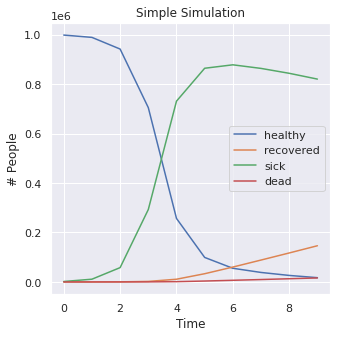

In [185]:
test.plot_simulation(10)

In [182]:
df=test.log(name='total')
df

,day,healthy,recovered,sick,dead,convalescence
0,0,999000,0,1000,0,0
1,0,996047,0,3953,0,0
2,1,983008,107,16869,16,0
3,2,923751,618,75565,66,0
4,3,694974,2828,301904,294,0
5,4,273267,12039,713354,1340,0
6,5,118787,33835,843615,3763,0
7,6,73815,60108,859344,6733,0
8,7,41478,88043,860729,9750,0
9,8,22315,116832,847890,12963,0


### With Qurantine

In [186]:
 test1=ComplexVirus(n=10**6, l=5, nh=10**6-1000, nr=0, ns=1000, nu=0, mu=0.002, healthy_flag=True, qurantine_flag=True)

100%|██████████| 100/100 [00:40<00:00,  2.49it/s]


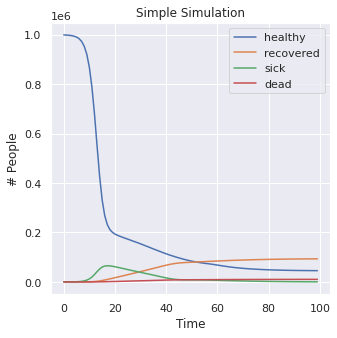

In [187]:
test1.plot_simulation(100)

In [183]:
test1.log(name='total')

,day,healthy,recovered,sick,dead,convalescence
0,0,999000,0,1000,0,0
1,0,998743,0,128,0,0
2,1,998424,19,136,1,0
3,2,997990,32,162,2,0
4,3,997392,52,211,3,0
...,...,...,...,...,...,...
94,93,44186,93825,497,10303,0
95,94,44130,93899,436,10311,0
96,95,44067,93965,386,10314,0
97,96,44042,94028,343,10317,0


# Test

In [385]:
test.number_dead

14879

In [386]:
test.number_healthy

14220

In [387]:
test.number_recovered

135016

In [354]:
test.districts_day(FLAG=True)

In [373]:
df=test.log()
df.loc[df['day'] == 4]

,day,healthy,recovered,sick,dead,convalescence,mu
name,,,,,,,
district0,4,10181,0,11,0,0,0.0120
district1,4,10742,1,23,0,1,0.0582
district2,4,9952,7,40,1,7,0.0666
district3,4,9955,3,42,0,3,0.1726
district4,4,15349,4,42,0,4,0.1264
district5,4,9987,2,12,0,2,0.0182
district6,4,10163,1,15,0,1,0.0670
district7,4,299010,9,291,1,9,0.0810
district8,4,9959,3,38,0,3,0.1880


In [292]:
test.calc_group_mu(test.districts)

[0.2898,
 0.31520000000000004,
 0.1716,
 0.10570000000000002,
 0.08030000000000001,
 0.41900000000000004,
 0.4536,
 0.2539,
 0.14350000000000002,
 0.10890000000000001,
 0.6608,
 1.2610000000000001,
 1.076,
 0.7072,
 0.107,
 0.501,
 1.0935000000000004,
 1.0174,
 0.6806000000000001,
 0.0881,
 0.3718000000000001,
 0.9551000000000001,
 0.9351,
 0.6428,
 0.059500000000000004]

In [293]:
mu=0
for other_place in test.districts:
    temp= (other_place.number_sick+other_place.nu)*Place.f1(place1=test.districts[0], place2=other_place, mu=test.mu, c=2)
    mu+= temp
    print(temp, other_place.name)
mu

0.0456 district0
0.0466 district1
0 district2
0 district3
0 district4
0.1384 district5
0.0592 district6
0 district7
0 district8
0 district9
0 district10
0 district11
0 district12
0 district13
0 district14
0 district15
0 district16
0 district17
0 district18
0 district19
0 district20
0 district21
0 district22
0 district23
0 district24


0.2898

In [250]:
0.002*67

0.134

In [194]:
sum([place.number_healthy for place in test.districts])

599687

In [195]:
400313+599687

1000000

In [127]:
for i in range(5):
    print(partions[i*5:i*5+5])

[2368, 1939, 0, 2, 0]
[284, 4, 68649, 0, 0]
[297, 0, 21994, 0, 1]
[0, 0, 0, 2, 9948]
[644281, 0, 0, 231, 0]


In [22]:
a=list(range(10))
a[sum(a[:3]):sum(a[:4])]
sum(a[:3])
sum(a[:4])

6

In [134]:
a=[]
for i in range(5):
    temp=[]
    for j in range(5):
        temp.append(partions[i*5+j])
    a.append(temp[:])


sum([sum(i) for i in a])

750000

In [123]:
counter=0
for i in a:
    counter+= sum(i)
counter

144700

In [39]:
def survived(n):
        nr=np.random.binomial(n,0.9)
        return nr, n-nr
    
contagius_count, death_count = survived(10)
print(contagius_count, death_count)

9 1


In [14]:
a=list(range(2,10))
b=list(range(1,11))
c=list(range(0,4))
min(a,b,c)

[0, 1, 2, 3]

In [181]:
s=0
for i in range(25):
    s+=np.random.binomial(1000,1/25)
s

1011

In [23]:
a=list(range(15))
b=[time for time in a if time>=5 and time<=11]
a=[time for time in a if time not in b]


[0, 1, 2, 3, 4, 12, 13, 14]

In [335]:
def F(x='a'):
    return 1
def F(x='b'):
    return 2

F(x='b')

2